# Sports memory data

## Parts of this notebook:
1. Characterize responses overall in terms of space/time.
2. Read in play-by-play data + win probability information from 'NBAplaybyplay.ipynb' output.
3. Read in our sports memory data and plot surprise and other attributes for play, game, and season memories.

Run this within Google colab by loading the 'nba_odds_all.xlsx' and 'Sports memory rubric.xlsx' files and the 'pydata' folder. You will also need to create a 'figs' folder. At the end, figures produced by this notebook will be downloaded.

In [ ]:
import io
import time
import math
import requests
import collections
import numpy as np
import pandas as pd
import seaborn as sns
!pip install stats
from scipy import stats
import scipy.stats as sss
from copy import deepcopy
from datetime import date
from matplotlib import cm
from datetime import datetime
from scipy import interpolate
import matplotlib.pyplot as plt
!pip install basemap # added for colab
from mpl_toolkits.basemap import Basemap
from scipy.stats import pearsonr,ttest_ind,ttest_rel,mannwhitneyu
fs,fsz,lw,msz=33,10,5,10 #presets for plotting 
plt.rcParams.update({'font.size': fs*2/3})
pd.set_option('display.max_rows',400)
print(np.version.version)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.6/127.6 KB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for stats: filename=stats-0.1.2a0-py3-none-any.whl size=24297 sha256=545fc53987e92445465b9d7a55f754bd386dbe08a80214fb628d89a261d8c454
  Stored in directory: /root/.cache/pip/wheels/64/d6/01/2701e2703a6fbd73f8b994044b8bf1b154cc7808bd1b88df49
Successfully built stats
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 863.9/863.9 KB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.7 MB/s eta 0:00

In [ ]:
# load in data and characterize responses in terms of time and geolocation
nba3=['ATL','BKN','BOS','CHA','CHI','CLE','DAL','DEN','DET','GSW',
      'HOU','IND','LAC','LAL','MEM','MIA','MIL','MIN','NOP','NYK',
      'OKC','ORL','PHI','PHX','POR','SAC','SAS','TOR','UTA','WSH'] #quick 3-letter NBA codes
szns=18 #seasons for which we have PBP data
szn_f=2004 #first season
t_sec=4*12*60 #seconds in regulation game
#read in all dataframes from worksheet output
#plays
dfp=pd.read_excel('Sports memory rubric.xlsx',sheet_name='Positive Play',header=1) #read in data
dfp=dfp[~dfp['Year'].isna()]
#all, including ones we couldn't identify
dfp=dfp[dfp['NCAAM/W/NBA/WNBA (1-4)']==3] #enforce NBA + ones we could identify
dfn=pd.read_excel('Sports memory rubric.xlsx',sheet_name='Negative Play',header=1)
dfn=dfn[~dfn['Year'].isna()]
dfn=dfn[dfn['NCAAM/W/NBA/WNBA (1-4)']==3]
#games
dfgp=pd.read_excel('Sports memory rubric.xlsx',sheet_name='Positive Game',header=1)
dfgp=dfgp[~dfgp['Year'].isna()]
dfgp=dfgp[dfgp['NCAAM/W/NBA/WNBA (1-4)']==3]
dfgn=pd.read_excel('Sports memory rubric.xlsx',sheet_name='Negative Game',header=1)
dfgn=dfgn[~dfgn['Year'].isna()]
dfgn=dfgn[dfgn['NCAAM/W/NBA/WNBA (1-4)']==3]
#season
dfsp=pd.read_excel('Sports memory rubric.xlsx',sheet_name='Positive Seasonpseason',header=1) #read in data
dfsp=dfsp[~dfsp['Year'].isna()]
dfsp=dfsp[dfsp['NCAAM/W/NBA/WNBA (1-4)']==3]
dfsp=dfsp[dfsp['Cheering FOR this team (1) or AGAINST them (-1)']==1]
dfsn=pd.read_excel('Sports memory rubric.xlsx',sheet_name='Negative Seasonpseason',header=1)
dfsn=dfsn[~dfsn['Year'].isna()]
dfsn=dfsn[dfsn['NCAAM/W/NBA/WNBA (1-4)']==3]
dfsn=dfsn[dfsn['Cheering FOR this team (1) or AGAINST them (-1)']==1]

#basic data about odds and records
df_svr=pd.read_excel('Sports memory rubric.xlsx',sheet_name='SeasonsVsRecords',header=0) #read in data
df_ots=pd.read_excel('Sports memory rubric.xlsx',sheet_name='OddsThroughSeason',header=0)
df_svr=df_svr[:-len(nba3)] #cut off 2021-2022
df_ots=df_ots[:-len(nba3)]

print('# pos play entries: %s' %len(dfp))
print('# neg play entries: %s' %len(dfn))
print('# pos game entries: %s' %len(dfgp))
print('# neg game entries: %s' %len(dfgn))
print('# pos szn entries: %s' %len(dfsp))
print('# neg szn entries: %s' %len(dfsn))

# pos play entries: 70
# neg play entries: 74
# pos game entries: 77
# neg game entries: 74
# pos szn entries: 96
# neg szn entries: 83


In [ ]:
#find team indices for pos/neg play games
all_i=[]
npp,npn=len(dfp),len(dfn)
v_i_p,h_i_p,v_i_n,h_i_n=np.zeros((npp)),np.zeros((npp)),np.zeros((npn)),np.zeros((npn))
dfp=dfp.astype({'Month/date':'str'})
dfp=dfp.astype({'Study date':'str'})
dfn=dfn.astype({'Month/date':'str'})
dfn=dfn.astype({'Study date':'str'})
for ha in range(2):
    for i in range(npp):
        if ha==0:
            v_i_p[i]=nba3.index(dfp['Visiting team'][dfp.index[i]][:3])
        elif ha==1:
            h_i_p[i]=nba3.index(dfp['Home team'][dfp.index[i]][:3])
    for i in range(npn):
        if ha==0:
            v_i_n[i]=nba3.index(dfn['Visiting team'][dfn.index[i]][:3])
        elif ha==1:
            h_i_n[i]=nba3.index(dfn['Home team'][dfn.index[i]][:3])
dfp['home'],dfp['vis'],dfn['home'],dfn['vis']=h_i_p,v_i_p,h_i_n,v_i_n
all_i=np.hstack([h_i_p,v_i_p])
all_i=np.hstack([all_i,h_i_n])
all_i=np.hstack([all_i,v_i_n])

dfgp=dfgp.astype({'Month/date':'str'})
dfgp=dfgp.astype({'Study date':'str'})
dfgn=dfgn.astype({'Month/date':'str'})
dfgn=dfgn.astype({'Study date':'str'})
ngp,ngn=len(dfgp),len(dfgn)
v_i_p,h_i_p,v_i_n,h_i_n=np.zeros((ngp)),np.zeros((ngp)),np.zeros((ngn)),np.zeros((ngn))
for ha in range(2):
    for i in range(ngp):
        if ha==0:
            v_i_p[i]=nba3.index(dfgp['Visiting team'][dfgp.index[i]][:3])
        elif ha==1:
            h_i_p[i]=nba3.index(dfgp['Home team'][dfgp.index[i]][:3])
    for i in range(ngn):
        if ha==0:
            v_i_n[i]=nba3.index(dfgn['Visiting team'][dfgn.index[i]][:3])
        elif ha==1:
            h_i_n[i]=nba3.index(dfgn['Home team'][dfgn.index[i]][:3])
dfgp['home'],dfgp['vis'],dfgn['home'],dfgn['vis']=h_i_p,v_i_p,h_i_n,v_i_n
all_i=np.hstack([all_i,h_i_p])
all_i=np.hstack([all_i,v_i_p])
all_i=np.hstack([all_i,h_i_n])
all_i=np.hstack([all_i,v_i_n])

nsp,nsn=len(dfsp),len(dfsn)
dfsp['Year'],dfsn['Year']=dfsp['Year'].astype(str),dfsn['Year'].astype(str)
dfsp=dfsp.astype({'Study date':'str'})
dfsn=dfsn.astype({'Study date':'str'})
h_i_p,h_i_n=np.zeros((nsp)),np.zeros((nsn))
for i in range(nsp):
    h_i_p[i]=nba3.index(dfsp['Team'][dfsp.index[i]][:3])
for i in range(nsn):
    h_i_n[i]=nba3.index(dfsn['Team'][dfsn.index[i]][:3])
dfsp['home'],dfsn['home']=h_i_p,h_i_n
all_i=np.hstack([all_i,h_i_p])
all_i=np.hstack([all_i,h_i_n])

[  3.  10.  31.   0.   3. 117.   3.  14.   1. 261.   2.   2.  20.  83.
   2.  32.  13.   1.   2.   2.  35.   1.   7.  21.  16.  22.  14.  32.
  16.   3.]
# GSW entries: 261 ; # LAL entries: 83


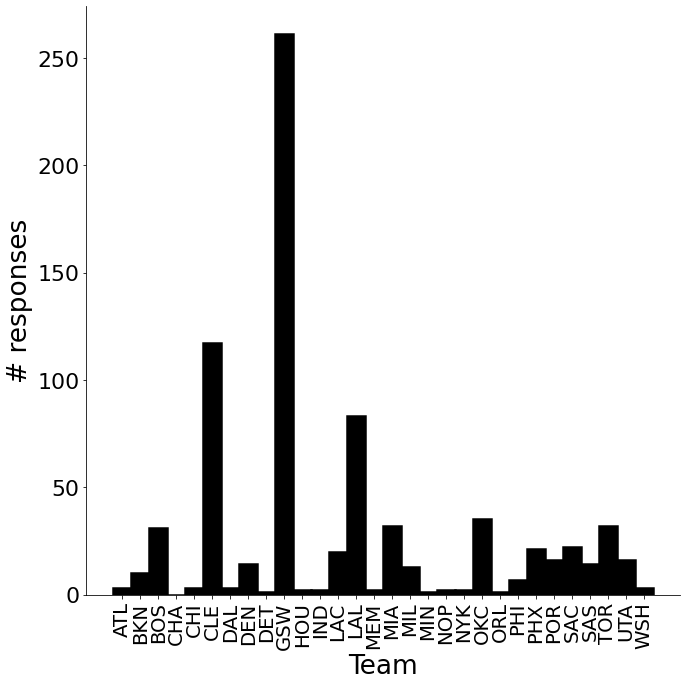

In [ ]:
# plot distribution of reported teams
qq=np.linspace(-0.5,len(nba3)-0.5,len(nba3)+1)
f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
histo=plt.hist(all_i,bins=qq,linewidth=lw/2,color='k',ec='black')
ax.set_ylabel('# responses',fontsize=fs*4/5)
ax.set_xlabel('Team',fontsize=fs*4/5)
ax.set_xticks(np.linspace(0,len(nba3)-1,len(nba3)))
ax.set_xticklabels(nba3,rotation=90,fontsize=fs*0.6)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
f.tight_layout()
f.savefig('figs/response_across_teams.pdf', transparent=True)
print(histo[0])
print('# GSW entries:',int(histo[0][9]),'; # LAL entries:',int(histo[0][13]))

33.7
84.3
3719673.3115181653
1038427.1220274605


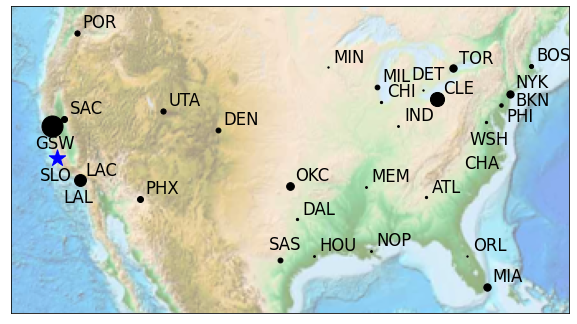

In [ ]:
# plot geographical distribution
#https://www.oreilly.com/library/view/python-data-science/9781491912126/ch04.html
dfgeo = pd.read_excel('Sports memory rubric.xlsx',sheet_name='Geolocation',header=0) #read in data

f = plt.figure(figsize=(fsz,fsz))
mstyle=1
if mstyle==1:
    m=Basemap(projection='aea', resolution=None,width=5E6, height=2.75E6,lat_0=37.5, lon_0=-97.5,)
    m.etopo(scale=0.5, alpha=0.5)
elif mstyle==2:
    m=Basemap(llcrnrlon=-120,llcrnrlat=23,urcrnrlon=-65,urcrnrlat=47,projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
    m.drawmapboundary(fill_color='aqua')
    m.fillcontinents(color='coral',lake_color='aqua')
    m.drawcountries()
    m.drawstates()
    m.drawcoastlines()

for i in range(len(dfgeo)):
    tn,lat,lon=dfgeo['Team'][i],dfgeo['Latitude'][i],dfgeo['Longitude'][i]
    lat,lon=float(lat[:4]),float(lon[:4])
    x,y=m(-lon,lat)
    if i==0:
        print(lat)
        print(lon)
        print(x)
        print(y)
    fact=50000 #scaling factor
    plt.scatter(x,y,c='k',s=histo[0][i]*1.7)
    if np.logical_or(np.logical_or(tn=='GSW',tn=='WSH'),tn=='LAL'):
        plt.text(x-fact*3,y-fact*4,tn,fontsize=fs/2)
    elif np.logical_or(tn=='SAS',tn=='DET'):
        plt.text(x-fact*2,y+fact*2,tn,fontsize=fs/2)
    elif tn=='PHI':
        plt.text(x+fact,y-fact*3,tn,fontsize=fs/2)
    elif tn=='BKN':
        plt.text(x+fact,y-fact*2,tn,fontsize=fs/2)
    else:
        plt.text(x+fact,y+fact,tn,fontsize=fs/2)

x,y=m(-120.7,35.3)
plt.scatter(x,y,c='b',marker='*',s=300)#add San Luis Obispo
plt.text(x-fact*3,y-fact*4,'SLO',fontsize=fs/2)
plt.show()
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
f.tight_layout()
f.savefig('figs/geo_data.pdf', transparent=True)

['2004-2005', '2005-2006', '2006-2007', '2007-2008', '2008-2009', '2009-2010', '2010-2011', '2011-2012', '2012-2013', '2013-2014', '2014-2015', '2015-2016', '2016-2017', '2017-2018', '2018-2019', '2019-2020', '2020-2021', '2021-2022']


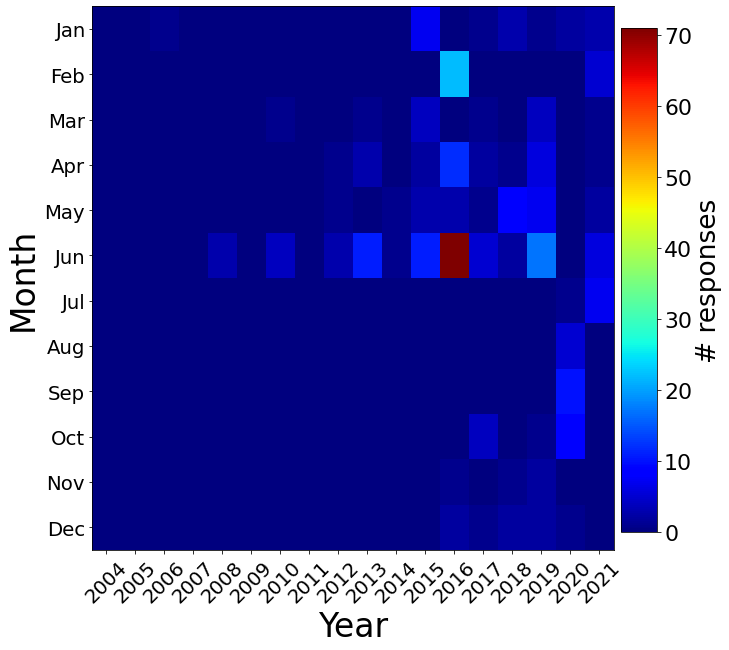

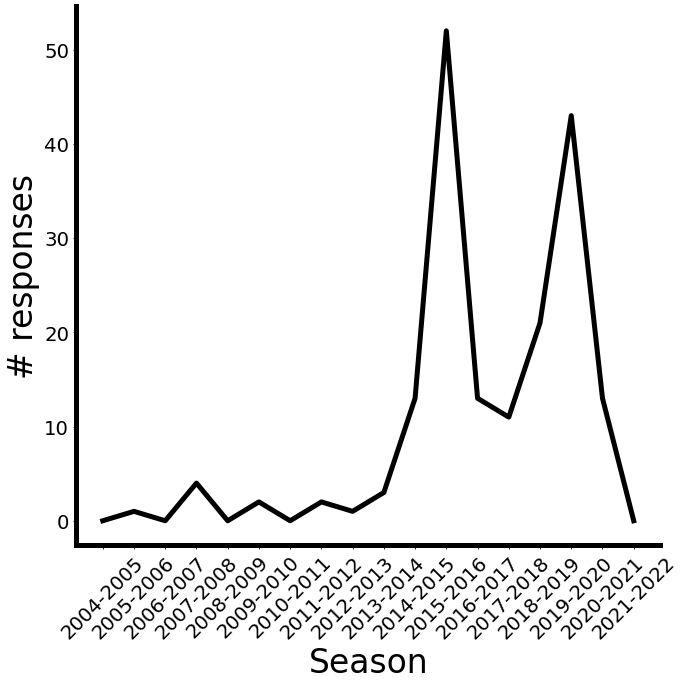

In [ ]:
#characterize month/date/year of game
mos=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
szn_nms=np.linspace(szn_f,szn_f+szns-1,szns).astype(int)
szn_nms2=[]
for i in range(szns):
    szn_nms2.append(str(szn_f+i)+'-'+str(szn_f+i+1))
print(szn_nms2)
y_m_ind,y_ind_szn,mem_ages,szn_mem_ages=np.zeros((szns,12)),np.zeros((szns)),[],[]
for i in range(npp):
    y_ind=int(dfp['Year'][dfp.index[i]])
    m_ind=int(dfp['Month/date'][dfp.index[i]][5:7])
    d_ind=int(dfp['Month/date'][dfp.index[i]][8:10])
    y_m_ind[y_ind-szn_f,m_ind-1]=y_m_ind[y_ind-szn_f,m_ind-1]+1
    y_ind_s=int(dfp['Study date'][dfp.index[i]][:4])
    m_ind_s=int(dfp['Study date'][dfp.index[i]][5:7])
    d_ind_s=int(dfp['Study date'][dfp.index[i]][8:10])
    mem_age=datetime(y_ind_s,m_ind_s,d_ind_s)-datetime(y_ind,m_ind,d_ind)
    mem_ages.append(mem_age.days)
for i in range(npn):
    y_ind=int(dfn['Year'][dfn.index[i]])
    m_ind=int(dfn['Month/date'][dfn.index[i]][5:7])
    d_ind=int(dfn['Month/date'][dfn.index[i]][8:10])
    y_m_ind[y_ind-szn_f,m_ind-1]=y_m_ind[y_ind-szn_f,m_ind-1]+1
    y_ind_s=int(dfn['Study date'][dfn.index[i]][:4])
    m_ind_s=int(dfn['Study date'][dfn.index[i]][5:7])
    d_ind_s=int(dfn['Study date'][dfn.index[i]][8:10])
    mem_age=datetime(y_ind_s,m_ind_s,d_ind_s)-datetime(y_ind,m_ind,d_ind)
    mem_ages.append(mem_age.days)
for i in range(ngp):
    y_ind=int(dfgp['Year'][dfgp.index[i]])
    m_ind=int(dfgp['Month/date'][dfgp.index[i]][5:7])
    d_ind=int(dfgp['Month/date'][dfgp.index[i]][8:10])
    y_m_ind[y_ind-szn_f,m_ind-1]=y_m_ind[y_ind-szn_f,m_ind-1]+1
    y_ind_s=int(dfgp['Study date'][dfgp.index[i]][:4])
    m_ind_s=int(dfgp['Study date'][dfgp.index[i]][5:7])
    d_ind_s=int(dfgp['Study date'][dfgp.index[i]][8:10])
    mem_age=datetime(y_ind_s,m_ind_s,d_ind_s)-datetime(y_ind,m_ind,d_ind)
    mem_ages.append(mem_age.days)
for i in range(ngn):
    y_ind=int(dfgn['Year'][dfgn.index[i]])
    m_ind=int(dfgn['Month/date'][dfgn.index[i]][5:7])
    d_ind=int(dfgn['Month/date'][dfgn.index[i]][8:10])
    y_m_ind[y_ind-szn_f,m_ind-1]=y_m_ind[y_ind-szn_f,m_ind-1]+1
    y_ind_s=int(dfgn['Study date'][dfgn.index[i]][:4])
    m_ind_s=int(dfgn['Study date'][dfgn.index[i]][5:7])
    d_ind_s=int(dfgn['Study date'][dfgn.index[i]][8:10])
    mem_age=datetime(y_ind_s,m_ind_s,d_ind_s)-datetime(y_ind,m_ind,d_ind)
    mem_ages.append(mem_age.days)
for i in range(nsp):
    y_ind=int(dfsp['Year'][dfsp.index[i]][:4])
    y_ind_szn[y_ind-szn_f]=y_ind_szn[y_ind-szn_f]+1
    y_ind_s=int(dfsp['Study date'][dfsp.index[i]][:4])
    mem_age=y_ind_s-y_ind
    szn_mem_ages.append(mem_age)
for i in range(nsn):
    y_ind=int(dfsn['Year'][dfsn.index[i]][:4])
    y_ind_szn[y_ind-szn_f]=y_ind_szn[y_ind-szn_f]+1
    y_ind_s=int(dfsn['Study date'][dfsn.index[i]][:4])
    mem_age=y_ind_s-y_ind
    szn_mem_ages.append(mem_age)
    
f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
im=ax.imshow(y_m_ind.T,interpolation='none',aspect='auto',cmap='jet')
ax.set_ylabel('Month',fontsize=fs)
ax.set_xlabel('Year',fontsize=fs)
ax.set_yticks(np.linspace(0,len(mos)-1,len(mos)))
ax.set_yticklabels(mos,fontsize=fs*0.6)
ax.set_xticks(np.linspace(0,szns-1,szns))
ax.set_xticklabels(szn_nms, rotation = 45,fontsize=fs*0.6)
f.subplots_adjust(right=0.85) #adjust so we can add colorbar
cbar_ax = f.add_axes([0.86, 0.15, 0.05, 0.7])
cbar=f.colorbar(im, cax=cbar_ax)
cbar.set_label('# responses',fontsize=fs*0.8)
f.savefig('figs/time_playgame.pdf', transparent=True)

f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
ax.plot(y_ind_szn,'k',linewidth=lw)
ax.set_ylabel('# responses',fontsize=fs)
ax.tick_params(axis='y',labelsize=fs*0.6)
ax.set_xlabel('Season',fontsize=fs)
ax.set_xticks(np.linspace(0,szns-1,szns))
ax.set_xticklabels(szn_nms2, rotation = 45,fontsize=fs*0.6)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(lw)
f.tight_layout()
f.savefig('figs/time_season.pdf', transparent=True)

[19. 20.  2. 12.  3. 17.  8. 11. 10.  2.  9.  4.  7.  4. 34. 31. 29. 15.
 15.  7.  4.  3.  0.  0.  8.  3.  3.  3.  1.  2.  0.  0.  0.  0.  3.  2.
  0.  0.  0.  0.  3.  0.  0.  0.  0.  0.  0.  0.  0.  1.]


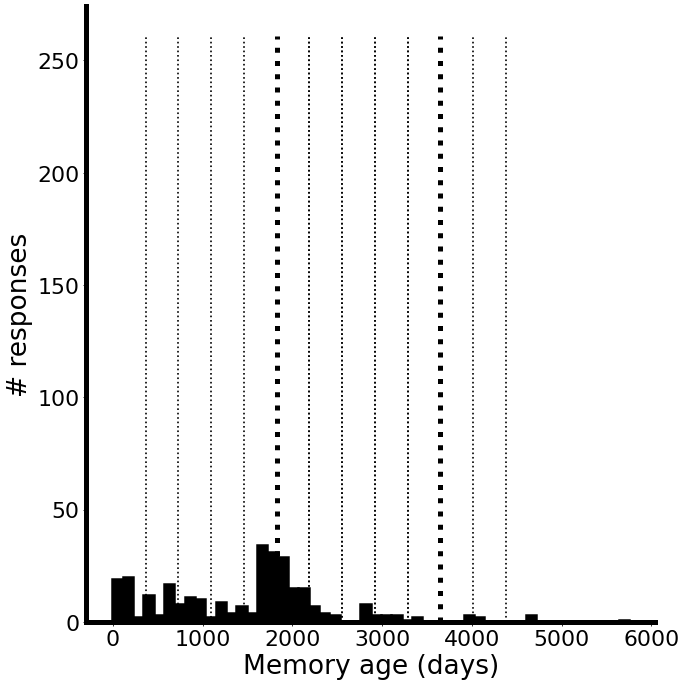

In [ ]:
#plot memory age
yr_b=4
f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
#line for every year + darker every 5
plt.vlines(365*5,0,np.max(histo[0]),linewidth=lw,colors='k',linestyles='dotted')
plt.vlines(365*10,0,np.max(histo[0]),linewidth=lw,colors='k',linestyles='dotted')
plt.vlines(np.linspace(365,365*4,yr_b),0,np.max(histo[0]),linewidth=lw/3,colors='k',linestyles='dotted')
plt.vlines(np.linspace(365*6,365*9,yr_b),0,np.max(histo[0]),linewidth=lw/3,colors='k',linestyles='dotted')
plt.vlines(np.linspace(365*6,365*9,yr_b),0,np.max(histo[0]),linewidth=lw/3,colors='k',linestyles='dotted')
plt.vlines(np.linspace(365*11,365*12,2),0,np.max(histo[0]),linewidth=lw/3,colors='k',linestyles='dotted')
histo=plt.hist(mem_ages,bins=50,linewidth=lw/2,color='black',ec='black')
ax.set_ylabel('# responses',fontsize=fs*4/5)
ax.set_xlabel('Memory age (days)',fontsize=fs*4/5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(lw)
f.tight_layout()
f.savefig('figs/response_ages.pdf', transparent=True)
print(histo[0])

(array([13., 43., 21., 11., 13., 52., 13.,  3.,  1.,  2.,  0.,  2.,  0.,
        4.,  1.]), array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16.]), <a list of 15 Patch objects>)


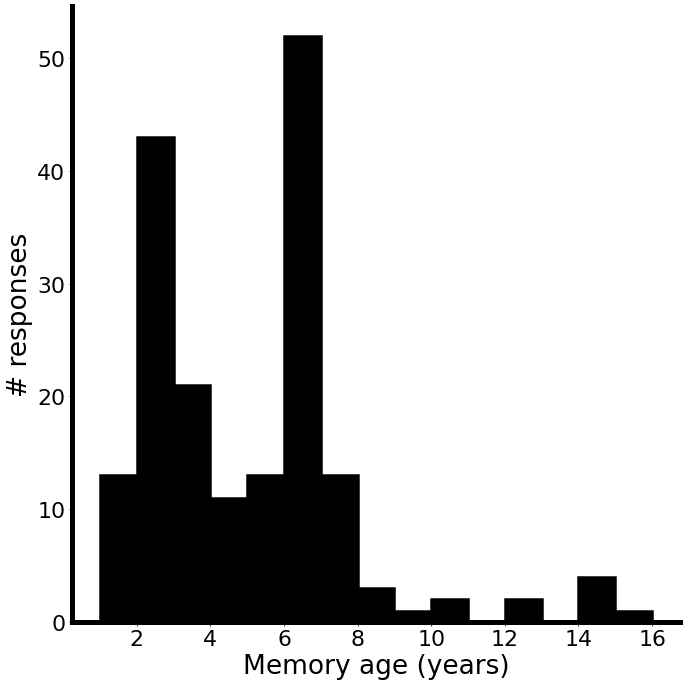

In [ ]:
yr_b=4
f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
histo=plt.hist(szn_mem_ages,linewidth=lw/2,color='black',ec='black',bins=15)
ax.set_ylabel('# responses',fontsize=fs*4/5)
ax.set_xlabel('Memory age (years)',fontsize=fs*4/5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(lw)
f.tight_layout()
f.savefig('figs/response_ages_szn.pdf', transparent=True)
print(histo)

# 1. Load play-by-play data & plot basics

In [ ]:
# load data from pydata folder
allsurs=np.load('pydata/allsurs.npy')
mwwps=np.load('pydata/mwwps.npy')
mwwp_ts=np.load('pydata/mwwp_ts.npy')
maxsurs=np.load('pydata/maxsurs.npy')
df1=pd.read_csv('pydata/df1.csv')
fwwps=np.load('pydata/fwwps.npy')
secB=np.load('pydata/secB.npy')
print(df1[:2])

# print some curiosities
qq=np.where(abs(allsurs)<0.01)
lil_i=len(qq[0])/len(allsurs)
print('% plays with <1% impact on game:',lil_i)

qq=np.where(abs(allsurs)<0.05)
lil_i5=len(qq[0])/len(allsurs)
print('% plays with <5% impact on game:',lil_i5)

qq=np.where(abs(allsurs)>0.25)
big_i=len(qq[0])/len(allsurs)
print('% plays with <5% impact on game:',big_i)

       g_id         g_d    sl  sdiff  hp  home  vis  hw  sl_ot  year  month  \
0  40400407  2005-06-23  2880      0   0    26    8   1   2880  2005      6   
1  40400407  2005-06-23  2880      0   1    26    8   1   2880  2005      6   

   day  sdiff_adj       hwp      mwwp       sur     fgsur     wgsur    maxsur  \
0   23          4  0.702929  0.319512       NaN  0.297071  0.680488  0.098775   
1   23          4  0.702634  0.319512 -0.000295  0.297071  0.680488  0.098775   

   mwwp_t  
0  1184.0  
1  1184.0  
% plays with <1% impact on game: 0.34608928886236845
% plays with <5% impact on game: 0.8253828535453367
% plays with <5% impact on game: 0.0009720825247366121


In [ ]:
# find surprise attributes
sur_v=df1['sur']
sl_ot_v=df1['sl_ot']
sur_bm,sur_bs=np.zeros((len(secB)-1)),np.zeros((len(secB)-1))
for i in range(len(secB)-1):
    if i==0:
        qq=np.where(np.logical_and(sl_ot_v<=secB[i],sl_ot_v>=secB[i+1]))[0]
    else:
        qq=np.where(np.logical_and(sl_ot_v<secB[i],sl_ot_v>=secB[i+1]))[0]
    if i==0:
        print(sur_v[qq])
    sur_bm[i]=np.nanmean(np.absolute(sur_v[qq]))
    sur_bs[i]=np.nanstd(np.absolute(sur_v[qq]))

0               NaN
1         -0.000295
208             NaN
427             NaN
428       -0.000006
             ...   
5682754   -0.002254
5683053         NaN
5683054   -0.000006
5683313         NaN
5683314   -0.001125
Name: sur, Length: 45133, dtype: float64


a: 1.2857767970955852e-06, b: 0.025939052211879393
r-squared =  0.1753776345619509
a: -0.007213687352713369, b: 0.07739103776433244
r-squared =  0.8161658384543994


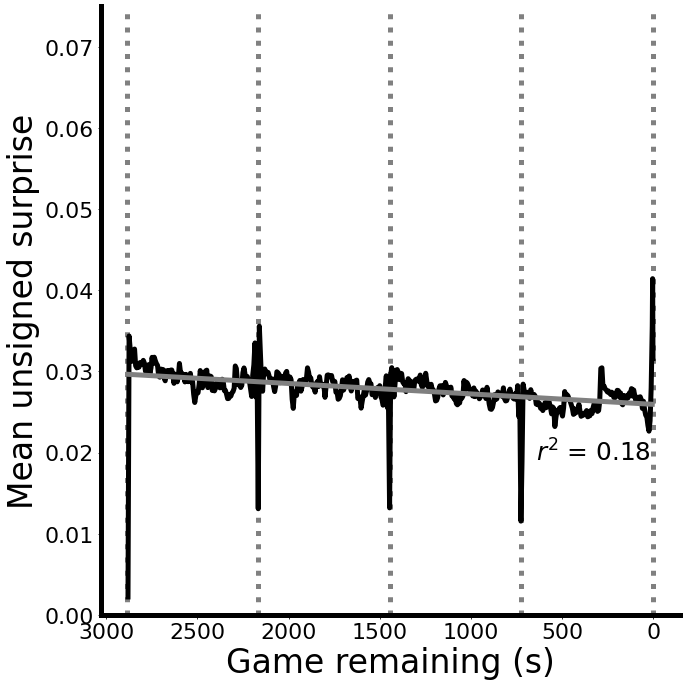

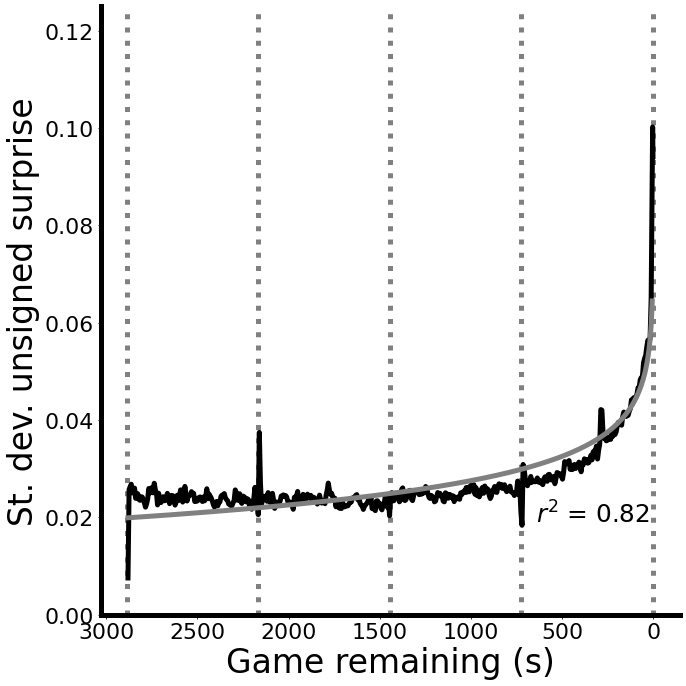

In [ ]:
# plot surprise attributes
def plot_sur_att(x,y,fitt,ymx,yl,sn):
    f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
    bf,bsz=-2,6 #bin size
    if fitt==1:
        xf=x+0
    else:
        xf=np.log(x)
    a,b=np.polyfit(xf,y,1)
    corr, _ = pearsonr(xf,y)
    print('a: %s, b: %s' %(a,b))
    print('r-squared = ',corr**2)
    plt.plot(x,y,'k',linewidth=lw)
    plt.plot(x[:bf], a*xf[:bf]+b,'gray',linewidth=lw)
    ax.invert_xaxis()
    ax.set_ylabel(yl,fontsize=fs)
    ax.set_xlabel('Game remaining (s)',fontsize=fs)
    ax.set_ylim(0,ymx)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.text(t_sec/4-75,0.019,'$r^{2}$ = %.2f' %corr**2,fontsize=fs*3/4,color='k')
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(lw)
    plt.vlines([t_sec+bsz,t_sec*3/4+bsz,t_sec/2+bsz,t_sec/4+bsz,0],0,ymx,linewidth=lw,colors='gray',linestyles='dotted')
    f.tight_layout()
    f.savefig(sn, transparent=True)
    
plot_sur_att(secB[:-1],sur_bm,1,0.075,'Mean unsigned surprise','figs/surprise_mean.pdf')
plot_sur_att(secB[:-1],sur_bs,2,0.125,'St. dev. unsigned surprise','figs/surprise_stdev.pdf')

In [ ]:
# main function for plotting surprise distributions
def kdeplotf(dat,dat2,dat3,xl,xlim,fn,exv):
    #exv is an extra variable to adjust one thing or another
    fs,binn,legg,lw2,bwa=25,120,[],5,1.333
    f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
    if xlim[0]<xlim[1]:
        binns=np.linspace(xlim[0],xlim[1],binn+1)
    else:
        binns=np.linspace(xlim[1],xlim[0],binn+1)
    if len(dat3)>0:
        sns.kdeplot(dat,color='k',linewidth=lw,bw_adjust=bwa,cut=0)
        sns.kdeplot(dat2,color='b',linewidth=lw,bw_adjust=bwa,cut=0)
        sns.kdeplot(dat3,color='r',linewidth=lw,bw_adjust=bwa,cut=0)
        #sns.rugplot(dat,color='k')
        #sns.histplot(dat2,color='b',linewidth=lw2,bins=binns)
        #sns.rugplot(dat2,color='b')
        #sns.rugplot(dat3,color='r')
        #sns.histplot(dat3,color='r',linewidth=lw2,bins=binns)
        legg=['All','Positive','Negative']
        if exv==2:
            legg[0]='''All, 
same game'''
        elif exv==3:
            legg[0]='''All, 4Q of 
same game'''
        elif exv==6:
            legg[0]='''All, 4Q of 
same game'''
    elif len(dat2)>0:
        sns.kdeplot(dat,color='b',linewidth=lw,bw_adjust=bwa,cut=0)
        sns.kdeplot(dat2,color='r',linewidth=lw,bw_adjust=bwa,cut=0)
        #sns.rugplot(dat,color='b')
        #sns.histplot(dat,color='b',linewidth=lw2,bins=binns,kde=True)
        #sns.rugplot(dat2,color='r')
        #sns.histplot(dat2,color='r',linewidth=lw2,bins=binns,kde=True)
        legg=['Positive','Negative']
    else:
        sns.kdeplot(dat,color='k',linewidth=lw,bw_adjust=bwa,cut=0)
        #sns.rugplot(dat,color='k')
    ax.set_ylabel('Density',fontsize=fs*5/4)
    ax.set_xlabel(xl,fontsize=fs*5/4)
    ax.set_xlim(xlim)
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(lw)
    if len(legg)>0:
        if exv!=5:
            ax.legend(legg,ncol=1,loc='upper left',fontsize=fs)
        if exv==4:
            ax.legend(legg,ncol=1,loc='upper center',fontsize=fs)
        #elif exv==5:
        #    ax.legend(legg,ncol=3,loc='upper center',fontsize=fs)
        elif exv==6:
            ax.legend(legg,ncol=1,loc='upper right',fontsize=fs)
    if exv==1: #plot vertical lines to demarcate quarters / OT periods
        ymin, ymax = ax.get_ylim()
        plt.vlines([t_sec,t_sec*3/4,t_sec/2,t_sec/4,0,-(5*60)],ymin,ymax,
                   linewidth=lw,colors='k',linestyles='dotted')
        ax.set_ylim([ymin, ymax])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.show()
    if len(fn)>0:
        f.tight_layout()
        f.savefig(fn, transparent=True)

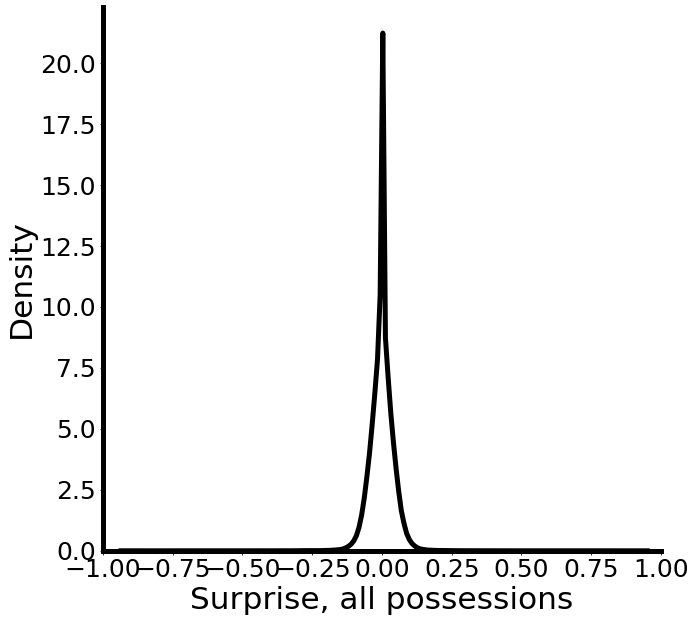

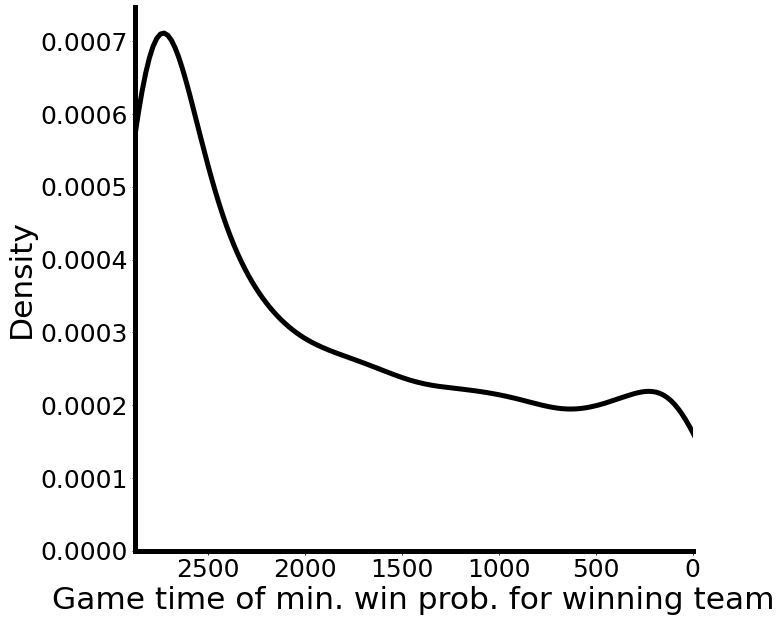

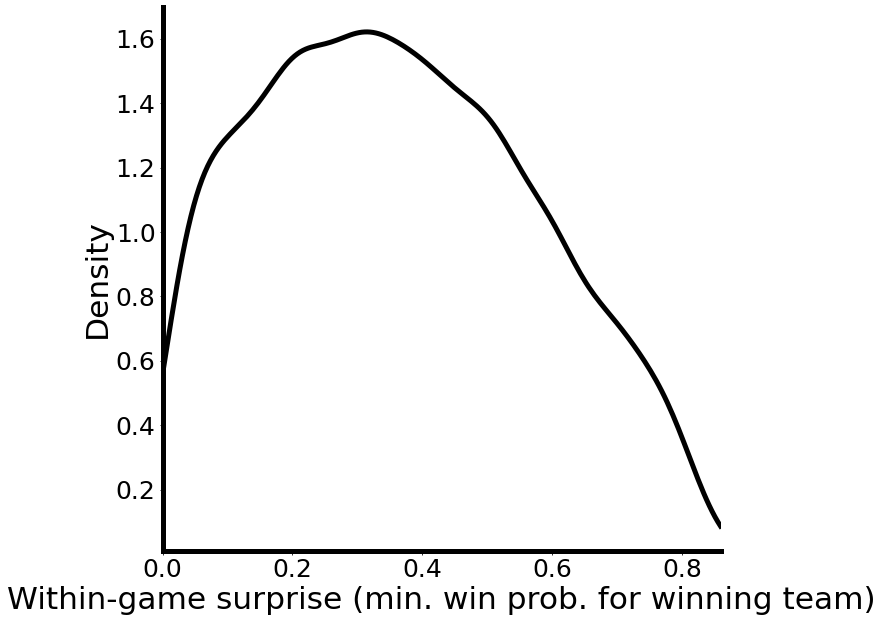

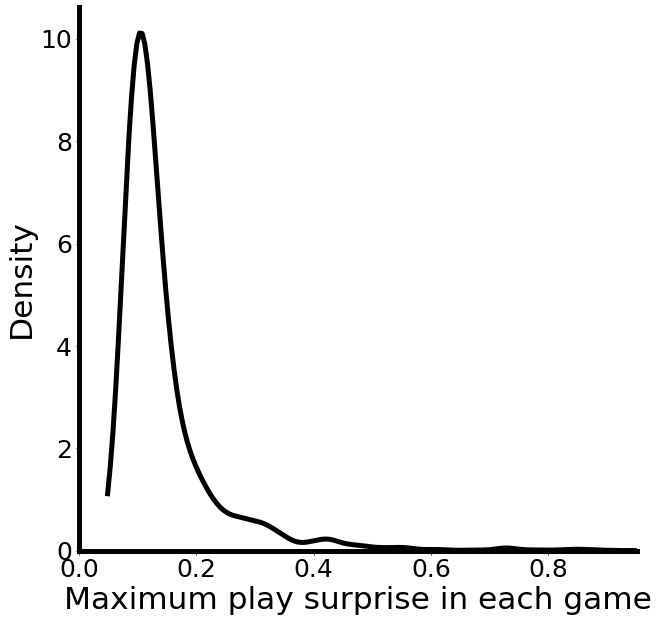

In [ ]:
# basic plots showing distributions
##possession level
kdeplotf(allsurs,[],[],'Surprise, all possessions',[-1,1],'figs/all_surs.pdf',0)
##game level
kdeplotf(mwwp_ts[:,0],[],[],'Game time of min. win prob. for winning team',[t_sec,0],
         'figs/all_comeback_times.pdf',0)
kdeplotf(mwwps[:,0],[],[],'Within-game surprise (min. win prob. for winning team)',[0,np.max(mwwps)],
         'figs/all_comebacks.pdf',0)
kdeplotf(maxsurs[:,0],[],[],'Maximum play surprise in each game',[0,np.max(maxsurs)],
         'figs/max_play_sur_game.pdf',0)

prior: 0.7650933040614709
max: 0.8434782608695652
last 100: [0.         0.01603376 0.01603376 0.01603376 0.01603376 0.01603376
 0.01603376 0.01603376 0.01603376 0.01603376 0.03341149 0.03341149
 0.03341149 0.03341149 0.03341149 0.03341149 0.03341149 0.03341149
 0.03341149 0.03341149 0.03341149 0.05369128 0.05369128 0.05369128
 0.05369128 0.05369128 0.05369128 0.05369128 0.05369128 0.19612591
 0.19612591 0.19612591 0.19612591 0.19612591 0.19612591 0.19612591
 0.19612591 0.19612591 0.19612591 0.19612591 0.19612591 0.19612591
 0.19612591 0.19612591 0.19612591 0.19612591 0.19612591 0.19612591
 0.19612591 0.19612591 0.19612591 0.19612591 0.19612591 0.46091015
 0.46091015 0.46091015 0.46091015 0.46091015 0.46091015 0.46091015
 0.46091015 0.46091015 0.46091015 0.46091015 0.46091015 0.46091015
 0.46091015 0.46091015 0.46091015 0.49075216 0.49075216 0.49075216
 0.49075216 0.57810414 0.57810414 0.57810414 0.57810414 0.57810414
 0.57810414 0.57810414 0.57810414 0.57810414 0.57810414 0.57810414
 0

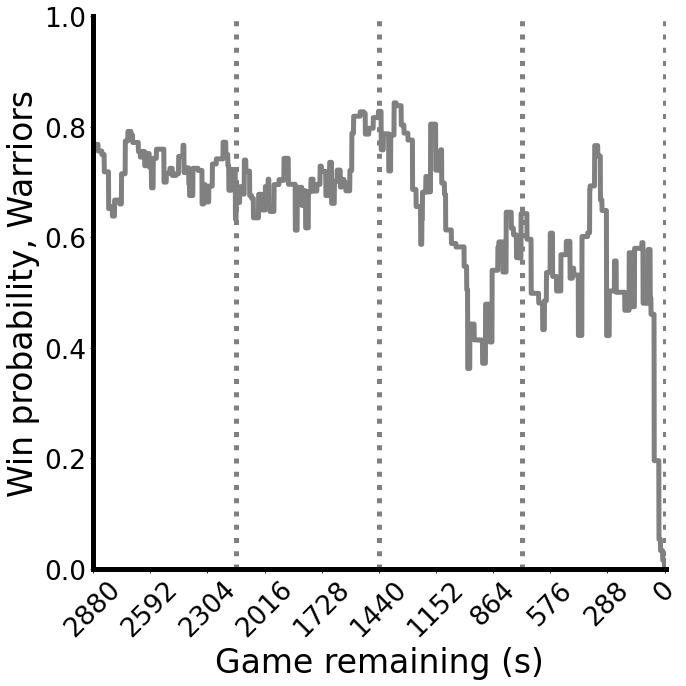

In [ ]:
#plot one game - Cavs-Warriors 2016-06-19
qq=np.where(np.logical_and(np.logical_and(df1['year']==2016,df1['month']==6),df1['day']==19))[0]
sec_ds=df1['sl'][df1.index[qq]].values
wp_ds=df1['hwp'][df1.index[qq]].values
sec_ex,wp_ex=np.linspace(0,t_sec,t_sec+1),np.zeros((t_sec+1))
for i in range(len(wp_ds)-1):
    wp_ex[sec_ds[i+1]:sec_ds[i]]=wp_ds[i]
wp_ex[0],wp_ex[-1]=0,wp_ds[0]

f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
ax.plot(sec_ex,wp_ex,'gray',linewidth=lw)
ax.set_ylabel('Win probability, Warriors',fontsize=fs)
ax.set_ylim([0,1])
ax.tick_params(axis='y',labelsize=fs*4/5)
ax.set_xlabel('Game remaining (s)',fontsize=fs)
ax.set_xticklabels(np.linspace(t_sec,0,int(t_sec/(48*6))+1).astype(int), rotation = 45,fontsize=fs*4/5)
ax.set_xticks(np.linspace(t_sec,0,int(t_sec/(48*6))+1).astype(int))
ax.set_xlim([-5,t_sec])
ax.invert_xaxis()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.vlines([t_sec,t_sec*3/4,t_sec/2,t_sec/4,0],0,1,linewidth=lw,colors='gray',linestyles='dotted')
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(lw)
f.tight_layout()
f.savefig('figs/example_game.pdf', transparent=True)
print('prior:',wp_ex[-1])
print('max:',np.max(wp_ex))
print('last 100:',wp_ex[:100]) # win probabilities… note they are in reverse order

['Oct 1', 'Nov 1', 'Dec 1', 'Jan 1', 'Feb 1', 'Mar 1', 'Apr 1', 'May 1', 'Round 1', 'Round 2', 'Round 3', 'Finals']
[0.05128205 0.08333333 0.11111111 0.11764706 0.09756098 0.08510638
 0.07407407 0.09302326 0.10695187 0.10582011 0.3030303  1.        ]


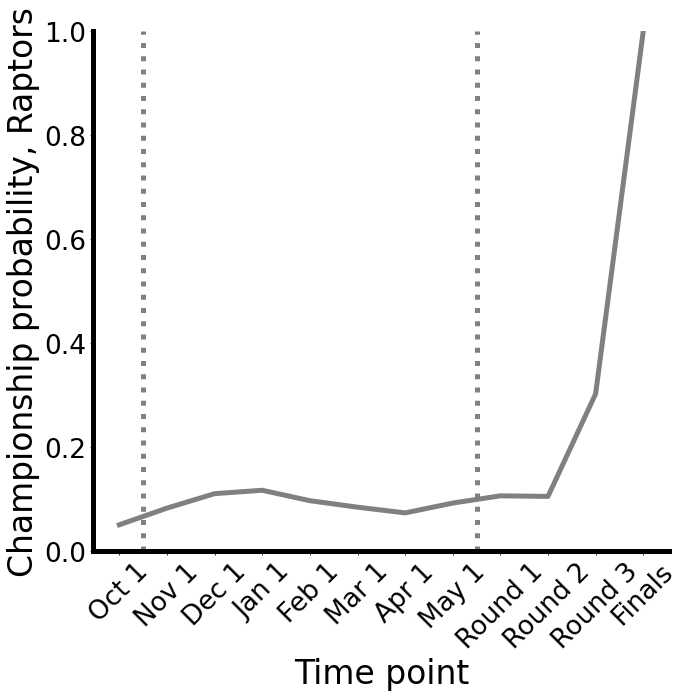

In [ ]:
#plot odds updates for one season - Raptors 2019
ou=['Oct 1','Nov 1','Dec 1','Jan 1','Feb 1','Mar 1','Apr 1','May 1','Round 1','Round 2','Round 3','Finals']
qq=df_ots.loc[np.logical_and(df_ots['Team']=='TOR',df_ots['Starting year']==2018)]
odds=np.zeros((len(ou)))
odds[:11]=df_ots.loc[df_ots.index==447].values[0][4:15]
odds=100/(100+odds)
odds[11]=1
print(ou)
print(odds)

f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
ax.plot(odds,'gray',linewidth=lw)
ax.set_ylabel('Championship probability, Raptors',fontsize=fs)
ax.set_ylim([0,1])
ax.tick_params(axis='y',labelsize=fs*4/5)
ax.set_xlabel('Time point',fontsize=fs)
ax.set_xticks(np.linspace(0,len(ou),len(ou)+1))
ax.set_xticklabels(ou, rotation = 45,fontsize=fs*4/5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.vlines([0.5,7.5],0,1,linewidth=lw,colors='gray',linestyles='dotted')
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(lw)
f.tight_layout()
f.savefig('figs/example_season.pdf', transparent=True)

# 3. Input data from our study & plot

# First: play data

In [ ]:
# functions for reading in data
def findsecs(tstring):
    if isHMS(tstring):
        date_time = datetime.strptime(tstring, "%M:%S:%f") #datetime
        a_timedelta = date_time - datetime(1900, 1, 1) #datetime
        seconds = a_timedelta.total_seconds()
        return seconds
    elif isMS(tstring):
        date_time = datetime.strptime(tstring, "%M:%S") 
        a_timedelta = date_time 
        seconds = a_timedelta.total_seconds()
        return seconds
def isHMS(input):
    try:
        time.strptime(input, '%H:%M:%S')
        return True
    except ValueError:
        return False
def isMS(input):
    try:
        time.strptime(input, '%M:%S')
        return True
    except ValueError:
        return False

In [ ]:
print('# final entries, pos: %s' %npp)
timesp=np.zeros((npp)) #pre-assign empty secs column
for i in range(npp):
    if str(dfp['Game time for possession AFTER play'][dfp.index[i]])!='nan': #BEFORE
        timesp[i]=findsecs(str(dfp['Game time for possession AFTER play'][dfp.index[i]]))
        if dfp['Quarter'][dfp.index[i]]<4: #for regular game, non-4th quarter
            timesp[i]=timesp[i]+(4-dfp['Quarter'][dfp.index[i]])*(12*60)
        elif dfp['Quarter'][dfp.index[i]]>4: #for OT
            timesp[i]=timesp[i]+(4-dfp['Quarter'][dfp.index[i]])*(5*60)
dfp=dfp.rename(columns={"Spectacularity (1-4)": "Spectacularity"}) 
print('# final entries, neg: %s' %npn)
timesn=np.zeros((npn)) #pre-assign empty secs column
for i in range(npn):
    if str(dfn['Game time for possession AFTER play'][dfn.index[i]])!='nan':
        timesn[i]=findsecs(str(dfn['Game time for possession AFTER play'][dfn.index[i]]))
        if dfn['Quarter'][dfn.index[i]]<4:
            timesn[i]=timesn[i]+(4-dfn['Quarter'][dfn.index[i]])*(12*60)
        elif dfn['Quarter'][dfn.index[i]]>4:
            timesn[i]=timesn[i]+(4-dfn['Quarter'][dfn.index[i]])*(5*60)
dfn=dfn.rename(columns={"Spectacularity (1-4)": "Spectacularity"}) 

#OT games:separate time being looked up (for alignment w/ data) from the time left (for win probability)
timesp2=deepcopy(timesp)
qq=np.where(timesp<0)[0] #
timesp2[qq]=timesp[qq]+(60*5)
qq=np.where(timesp<0)[0] #repeat in case 2OT
timesp2[qq]=timesp[qq]+(60*5)
timesn2=deepcopy(timesn)
qq=np.where(timesn<0)[0]
timesn2[qq]=timesn[qq]+(60*5)
qq=np.where(timesn<0)[0]
timesn2[qq]=timesn[qq]+(60*5)

#clean up time info and data as ints
m_ind,d_ind=np.zeros((npp)),np.zeros((npp))
for i in range(npp):
    m_ind[i]=dfp['Month/date'][dfp.index[i]][5:7]
    d_ind[i]=dfp['Month/date'][dfp.index[i]][8:10]
dfp['month']=m_ind
dfp['day']=d_ind
dfp['gt']=timesp
dfp['gt2']=timesp2
dfp[['month','day','Year','home','gt','gt2']]=dfp[['month','day','Year','home','gt','gt2']].astype(int)

m_ind,d_ind=np.zeros((npn)),np.zeros((npn))
for i in range(npn):
    m_ind[i]=dfn['Month/date'][dfn.index[i]][5:7]
    d_ind[i]=dfn['Month/date'][dfn.index[i]][8:10]
dfn['month']=m_ind
dfn['day']=d_ind
dfn['gt']=timesn
dfn['gt2']=timesn2
dfn[['month','day','Year','home','gt','gt2']]=dfn[['month','day','Year','home','gt','gt2']].astype(int)

# final entries, pos: 70
# final entries, neg: 74


# find info from game for a given play

In [ ]:
#loop over all dfp, matching year/month/day/team
sursp_a,perc_g_surp,perc_g_surp_4q=np.zeros((npp)),np.zeros((npp)),np.zeros((npp))
sursp_a_abs,perc_g_surp_abs,perc_g_surp_4q_abs=np.zeros((npp)),np.zeros((npp)),np.zeros((npp))
perc_into_sznpp,t_i_pp=np.zeros((npp)),np.zeros((npp))
for i in range(npp):
    curr_y=dfp['Year'][dfp.index[i]] #match year
    q=np.where(df1['year']==curr_y)[0]
    curr_m=dfp['month'][dfp.index[i]] #match month
    qq=np.where(df1['month'][q]==curr_m)[0]
    curr_d=dfp['day'][dfp.index[i]] #match date
    qqq=np.where(df1['day'][q[qq]]==curr_d)[0]
    curr_ht=dfp['home'][dfp.index[i]] #match home team
    t_i_pp[i]=curr_ht
    qqqq=np.where(df1['home'][q[qq[qqq]]]==curr_ht)[0]
    df1gt=df1.iloc[q[qq[qqq[qqqq]]]] #dataframe representing full game
    tdiffs=np.absolute(df1gt['sl']-dfp['gt'][dfp.index[i]]) #match play by finding time diffs, min
    pos_m=np.where(tdiffs==np.min(tdiffs))[0]
    
    #sometimes it grabs two within the same second - must check these!
    print('Year, month, date, home:%s,%s,%s,%s' %(curr_y,curr_m,curr_d,curr_ht))
    print('rows, rows, rows, rows:%s,%s,%s,%s' %(len(q),len(qq),len(qqq),len(qqqq)))
    print('game time, RAs:%s;pbp:%s;#rs:%s' %(dfp['gt'][dfp.index[i]],df1gt['sl'][df1gt.index[pos_m]],len(pos_m)))
    if len(pos_m)>1:
        print('special i:',i)
        print('multiple surs:',df1gt['sur'][df1gt.index[pos_m]])
    if i==4: #fix specific spots w/ multiple plays within a second
        print(df1gt['sur'][df1gt.index[pos_m]])
        pos_m=pos_m[4]
    elif i==8:
        pos_m=pos_m[1]
    elif i==9:
        pos_m=pos_m[1]
    elif i==16:
        pos_m=pos_m[1] 
    else:
        pos_m=pos_m[0] #other cases
    sursp_a[i]=df1gt['sur'][df1gt.index[pos_m]] #relative surprise by the algorithm
    sursp_a_abs[i]=np.absolute(df1gt['sur'][df1gt.index[pos_m]]) #abs surprise by the algorithm
    pos_4q=np.where(df1gt['sl']<60*12)[0] #grab game events from 4th quarter
    if i==0:
        allgsursp=df1gt['sur'][1:] #all rel surprise values from that game
        allgsursp_4q=df1gt['sur'][df1gt.index[pos_4q]] #all surprise values in last five min
        allgsursp_abs=np.absolute(df1gt['sur'][1:]) #absolute surprise
        allgsursp_4q_abs=np.absolute(df1gt['sur'][df1gt.index[pos_4q]])
    else:
        allgsursp=np.hstack([allgsursp,df1gt['sur'][1:]])
        allgsursp_4q=np.hstack([allgsursp_4q,df1gt['sur'][df1gt.index[pos_4q]]])
        allgsursp_abs=np.hstack([allgsursp_abs,np.absolute(df1gt['sur'][1:])])
        allgsursp_4q_abs=np.hstack([allgsursp_4q_abs,np.absolute(df1gt['sur'][df1gt.index[pos_4q]])])
    perc_g_surp[i]=stats.percentileofscore(df1gt['sur'][1:].values,sursp_a[i])
    perc_g_surp_4q[i]=stats.percentileofscore(df1gt['sur'][df1gt.index[pos_4q]].values,sursp_a[i])
    perc_g_surp_abs[i]=stats.percentileofscore(np.absolute(df1gt['sur'][1:].values),sursp_a_abs[i])
    perc_g_surp_4q_abs[i]=stats.percentileofscore(np.absolute(df1gt['sur'][df1gt.index[pos_4q]].values),
                                                sursp_a_abs[i])
    print('expert sur:%s' %format(dfp['Relative surprise'][dfp.index[i]]/100,".2f"))
    print('sur, perc sur g, perc sur 4q:%s,%s,%s' 
          %(format(sursp_a[i],".2f"),format(perc_g_surp[i],".2f"),format(perc_g_surp_4q[i],".2f"),))
    print('abs sur, abs perc sur g, abs perc sur 4q:%s,%s,%s' 
          %(format(sursp_a_abs[i],".2f"),format(perc_g_surp_abs[i],".2f"),format(perc_g_surp_4q_abs[i],".2f"),))
    
    curr_g_id=df1gt['g_id'][df1gt.index[0]] #current game id
    if curr_y!=2020: #not bubble year
        mthc=8 #month cutoff
    else:
        mthc=11 #month cutoff
    if curr_m>mthc: #if happens in early part of season
        szn=curr_y+0
    else:
        szn=curr_y-1 #if happens in late part
    
    #find games in early part of season
    q=np.where(np.logical_and(np.logical_and(np.logical_or(df1['home']==curr_ht,df1['vis']==curr_ht),
                                             df1['year']==szn),df1['month']>mthc))[0]
    df1szne=df1.iloc[q] 
    #late part of season
    q=np.where(np.logical_and(np.logical_and(np.logical_or(df1['home']==curr_ht,df1['vis']==curr_ht),
                                             df1['year']==szn+1),df1['month']<mthc))[0]
    df1sznl=df1.iloc[q]
    df1szn=pd.concat([df1szne,df1sznl]) #combine df of all updates in this season!
    ids_tszn=df1szn.g_id.unique() #find unique games
    perc_into_sznpp[i]=stats.percentileofscore(ids_tszn,curr_g_id) #all in order by g_id so find %ile
    print('\n')

Year, month, date, home:2015,6,14,9
rows, rows, rows, rows:362147,1540,243,243
game time, RAs:453;pbp:3240049    453
Name: sl, dtype: int64;#rs:1
expert sur:0.10
sur, perc sur g, perc sur 4q:0.13,100.00,100.00
abs sur, abs perc sur g, abs perc sur 4q:0.13,99.59,98.46


Year, month, date, home:2013,6,18,15
rows, rows, rows, rows:359216,2153,269,269
game time, RAs:5;pbp:2552917    5
2552918    5
Name: sl, dtype: int64;#rs:2
special i: 1
multiple surs: 2552917    0.426566
2552918    0.000000
Name: sur, dtype: float64
expert sur:0.00
sur, perc sur g, perc sur 4q:0.43,100.00,100.00
abs sur, abs perc sur g, abs perc sur 4q:0.43,100.00,100.00


Year, month, date, home:2019,5,12,27
rows, rows, rows, rows:352368,7649,513,253
game time, RAs:0;pbp:4681818    0
4681819    0
4681820    0
Name: sl, dtype: int64;#rs:3
special i: 2
multiple surs: 4681818    0.393222
4681819    0.000000
4681820    0.031323
Name: sur, dtype: float64
expert sur:0.33
sur, perc sur g, perc sur 4q:0.39,100.00,100.00
abs sur

In [ ]:
#repeat for negative plays - for all comments, see above
sursn_a,perc_g_surn,perc_g_surn_4q=np.zeros((npn)),np.zeros((npn)),np.zeros((npn))
sursn_a_abs,perc_g_surn_abs,perc_g_surn_4q_abs=np.zeros((npn)),np.zeros((npn)),np.zeros((npn))
perc_into_sznpn,t_i_pn=np.zeros((npn)),np.zeros((npn))
for i in range(npn):
    curr_y=dfn['Year'][dfn.index[i]] 
    q=np.where(df1['year']==curr_y)[0]
    curr_m=dfn['month'][dfn.index[i]] 
    qq=np.where(df1['month'][q]==curr_m)[0]
    curr_d=dfn['day'][dfn.index[i]] 
    qqq=np.where(df1['day'][q[qq]]==curr_d)[0]
    curr_ht=dfn['home'][dfn.index[i]] 
    qqqq=np.where(df1['home'][q[qq[qqq]]]==curr_ht)[0]
    t_i_pn[i]=curr_ht
    df1gt=df1.iloc[q[qq[qqq[qqqq]]]]
    tdiffs=np.absolute(df1gt['sl']-dfn['gt'][dfn.index[i]]) 
    pos_m=np.where(tdiffs==np.min(tdiffs))[0]
    print('rows, rows, rows, rows:%s,%s,%s,%s' %(len(q),len(qq),len(qqq),len(qqqq)))
    print('game time, RAs:%s;pbp:%s;#rs:%s' %(dfn['gt'][dfn.index[i]],df1gt['sl'][df1gt.index[pos_m]],len(pos_m)))
    if len(pos_m)>1:
        print('special i:',i)
        print('multiple surs:',df1gt['sur'][df1gt.index[pos_m]])
    if i==15: 
        pos_m=pos_m[1]
    elif i==33: 
        pos_m=pos_m[2] #34, [3]
    elif i==37: 
        pos_m=pos_m[2]
    elif i==48: 
        pos_m=pos_m[2]
    elif i==52: 
        pos_m=pos_m[1]
    elif i==60: 
        pos_m=pos_m[2]
    elif i==68: 
        pos_m=pos_m[-1]
    elif i==73: 
        pos_m=pos_m[1]
    else:
        pos_m=pos_m[0] 
    print('game time, RAs:%s;pbp:%s' %(dfn['gt'][dfn.index[i]],df1gt['sl'][df1gt.index[pos_m]]))
    sursn_a[i]=df1gt['sur'][df1gt.index[pos_m]]
    sursn_a_abs[i]=np.absolute(df1gt['sur'][df1gt.index[pos_m]]) 
    pos_4q=np.where(df1gt['sl']<60*12)[0] 
    if i==0:
        allgsursn=df1gt['sur'][1:]
        allgsursn_4q=df1gt['sur'][df1gt.index[pos_4q]] 
        allgsursn_abs=np.absolute(df1gt['sur'][1:]) 
        allgsursn_4q_abs=np.absolute(df1gt['sur'][df1gt.index[pos_4q]])
    else:
        allgsursn=np.hstack([allgsursn,df1gt['sur'][1:]])
        allgsursn_4q=np.hstack([allgsursn_4q,df1gt['sur'][df1gt.index[pos_4q]]])
        allgsursn_abs=np.hstack([allgsursn_abs,np.absolute(df1gt['sur'][1:])])
        allgsursn_4q_abs=np.hstack([allgsursn_4q_abs,np.absolute(df1gt['sur'][df1gt.index[pos_4q]])])
    perc_g_surn[i]=stats.percentileofscore(df1gt['sur'][1:].values,sursn_a[i])
    perc_g_surn_4q[i]=stats.percentileofscore(df1gt['sur'][df1gt.index[pos_4q]].values,sursn_a[i])
    perc_g_surn_abs[i]=stats.percentileofscore(np.absolute(df1gt['sur'][1:].values),sursn_a_abs[i])
    perc_g_surn_4q_abs[i]=stats.percentileofscore(np.absolute(df1gt['sur'][df1gt.index[pos_4q]].values),
                                                sursn_a_abs[i])
    print('Year, month, date, home:%s,%s,%s,%s' %(curr_y,curr_m,curr_d,curr_ht))
    print('rows, rows, rows, rows:%s,%s,%s,%s' %(len(q),len(qq),len(qqq),len(qqqq)))
    print('expert sur:%s' %format(dfn['Relative surprise'][dfn.index[i]]/100,".2f"))
    print('sur, perc sur g, perc sur 4q:%s,%s,%s' 
          %(format(sursn_a[i],".3f"),format(perc_g_surn[i],".2f"),format(perc_g_surn_4q[i],".2f")))
    print('abs sur, abs perc sur g, abs perc sur 4q:%s,%s,%s' 
          %(format(sursn_a_abs[i],".2f"),format(perc_g_surn_abs[i],".2f"),format(perc_g_surn_4q_abs[i],".2f")))
    
    curr_g_id=df1gt['g_id'][df1gt.index[0]]
    if curr_y!=2020:
        mthc=8 
    else:
        mthc=11
    if curr_m>mthc: 
        szn=curr_y+0
    else:
        szn=curr_y-1 
    q=np.where(np.logical_and(np.logical_and(np.logical_or(df1['home']==curr_ht,df1['vis']==curr_ht),
                                             df1['year']==szn),df1['month']>mthc))[0]
    df1szne=df1.iloc[q] 
    q=np.where(np.logical_and(np.logical_and(np.logical_or(df1['home']==curr_ht,df1['vis']==curr_ht),
                                             df1['year']==szn+1),df1['month']<mthc))[0]
    df1sznl=df1.iloc[q]
    df1szn=pd.concat([df1szne,df1sznl])
    ids_tszn=df1szn.g_id.unique()
    perc_into_sznpn[i]=stats.percentileofscore(ids_tszn,curr_g_id)

rows, rows, rows, rows:367236,1730,236,236
game time, RAs:53;pbp:3600531    53
Name: sl, dtype: int64;#rs:1
game time, RAs:53;pbp:53
Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
expert sur:-0.31
sur, perc sur g, perc sur 4q:-0.265,0.43,1.89
abs sur, abs perc sur g, abs perc sur 4q:0.26,100.00,100.00
rows, rows, rows, rows:367236,1730,236,236
game time, RAs:110;pbp:3600527    109
Name: sl, dtype: int64;#rs:1
game time, RAs:110;pbp:109
Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
expert sur:-0.06
sur, perc sur g, perc sur 4q:-0.110,1.70,7.55
abs sur, abs perc sur g, abs perc sur 4q:0.11,97.45,92.45
rows, rows, rows, rows:367236,1730,236,236
game time, RAs:53;pbp:3600531    53
Name: sl, dtype: int64;#rs:1
game time, RAs:53;pbp:53
Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
expert sur:-0.31
sur, perc sur g, perc sur 4q:-0.265,0.43,1.89
abs sur, abs perc sur g, abs perc sur 4q:0.26,100.00,

In [ ]:
#fix quick thing with 'cheering for' being strings + nonconvertible to int quickly
chvp=np.zeros((npp)) 
for i in range(npp):
    if int(dfp['Cheering for (1=H,-1=V)'][dfp.index[i]])==1:
        chvp[i]=1
    elif int(dfp['Cheering for (1=H,-1=V)'][dfp.index[i]])==-1:
        chvp[i]=-1
dfp['chv']=chvp
chvn=np.zeros((npn))
for i in range(npn):
    if int(dfn['Cheering for (1=H,-1=V)'][dfn.index[i]])==1:
        chvn[i]=1
    elif int(dfn['Cheering for (1=H,-1=V)'][dfn.index[i]])==-1:
        chvn[i]=-1
dfn['chv']=chvn

dfp['relsur_a']=np.multiply(sursp_a,dfp['chv'].values) #relative surprise by algorithm
dfn['relsur_a']=np.multiply(sursn_a,dfn['chv'].values)

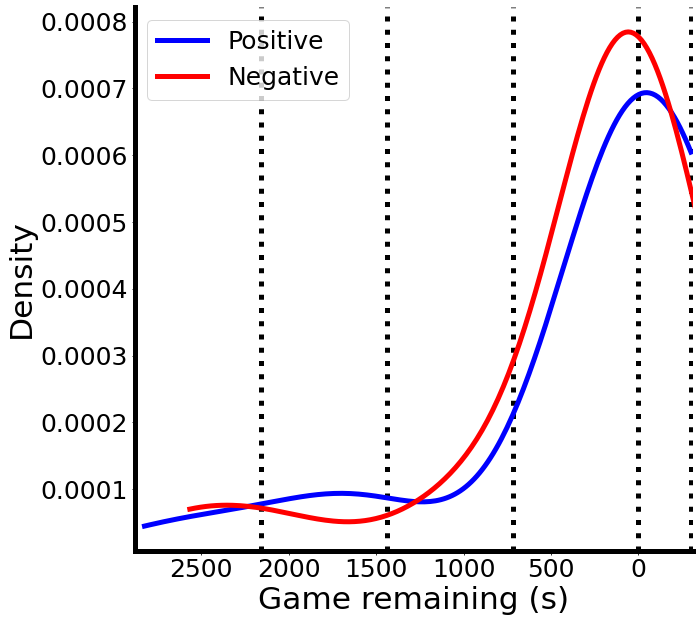

kurtosis g1: 2.959, p=0.003; kurtosis g2: 3.5, p=0.0
skewness g1: 5.155, p=0.0; kurtosis g2: 5.634, p=0.0
use mann-whitney!
times into game, pos v neg
   meth  g1n      g1m     g1s  g1med  g2n      g2m     g2s  g2med   df  \
0     2   70  270.629  93.232    5.0   74  344.838  82.319   53.0  142   

     stat  tstat      p  p_ttest    d  
0  1904.5 -0.594  0.006    0.553 -0.1  




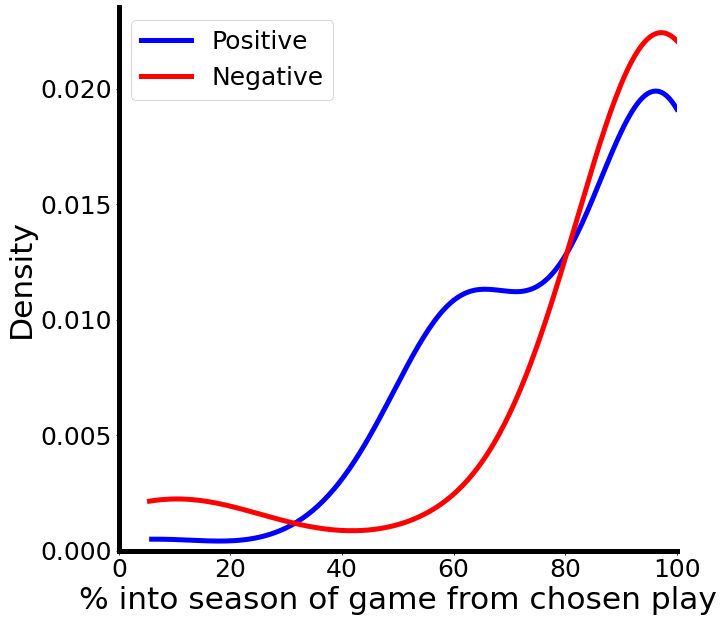

kurtosis g1: 1.843, p=0.065; kurtosis g2: 3.822, p=0.0
skewness g1: -3.469, p=0.001; kurtosis g2: -5.993, p=0.0
use mann-whitney!
times into szn, pos v neg
   meth  g1n     g1m    g1s      g1med  g2n     g2m    g2s      g2med   df  \
0     2   70  82.203  2.404  89.320388   74  87.534  3.009  99.047619  142   

     stat  tstat      p  p_ttest      d  
0  1922.0 -1.365  0.006    0.174 -0.229  




In [ ]:
#reporting Mann-Whitney tests: 
#https://stats.stackexchange.com/questions/393128/calculating-degrees-of-freedom-in-a-mann-whitney-u
def rd(dat,dig): #shorter rounding function
    r=round(dat,dig)
    return r

# functions for consolidating statistical reporting
def astats(g1,g2,tn): #not used, as it turns out!
    #outputs t-stat, p value, and cohen's dz, given two paired groups
    t,p=ttest_rel(g1,g2)
    n1,n2=np.sum(~np.isnan(g1)),np.sum(~np.isnan(g2))
    df,g3=n1-1,g1-g2
    dz=np.nanmean(g3)/np.nanstd(g3) #Cohen's dz
    g1m,g2m,g1s,g2s=np.nanmean(g1),np.nanmean(g2),np.nanstd(g1)/np.sqrt(n1),np.nanstd(g2)/np.sqrt(n2)
    r=pd.DataFrame()
    b,dg=np.zeros((1)),3 #pre-assign one blank row
    r['g1m'],r['g1s'],r['g2m'],r['g2s'],r['df'],r['t'],r['p'],r['dz']=b,b,b,b,b,b,b,b
    r['p'],r['t'],r['dz'],r['df']=rd(p,dg),rd(t,dg),rd(dz,dg),rd(df,dg)
    r['g1m'],r['g2m'],r['g1s'],r['g2s']=rd(g1m,dg),rd(g2m,dg),rd(g1s,dg),rd(g2s,dg)
    print(tn)
    print(r)
    print('\n')
    return r

def astats1(g1,popm,tn):
    #outputs t-stat, p value, and cohen's dz, given one sample group
    r=pd.DataFrame()
    b,dg=np.zeros((1)),3 #pre-assign one blank row
    sku1,pku1=stats.kurtosistest(g1,nan_policy='omit')
    print('kurtosis g1: %s, p=%s' %(rd(sku1,dg),rd(pku1,dg)))
    ske1,pke1=stats.skewtest(g1,nan_policy='omit')
    print('skewness g1: %s, p=%s' %(rd(ske1,dg),rd(pke1,dg)))
    if np.logical_or(pku1<0.05,pke1<0.05):
        #res=stats.wilcoxon(g1-popm,method = 'approx',nan_policy='omit') #
        #stat,p=res.zstatistic, res.pvalue
        res=stats.wilcoxon(g1-popm) #change for colab
        stat,p=res.statistic, res.pvalue
        print('use wilcoxon!')
        meth=2
        #include for reviewer - what would p val have been if we HAD done ttest
        tstat,p_ttest=stats.ttest_1samp(g1,popmean=popm) 
    else:
        stat,p=stats.ttest_1samp(g1,popmean=popm) #,nan_policy='omit' #colab
        print('assume normality')
        meth=1
        tstat,p_ttest=stat+0,p+0 #avoid errors
    n1=np.sum(~np.isnan(g1))
    df=n1-1
    dz=np.nanmean(g1)/np.nanstd(g1) #Cohen's dz
    g1m,g1s=np.nanmean(g1),np.nanstd(g1)/np.sqrt(n1)
    r['meth'],r['g1n'],r['g1m'],r['g1s'],r['df'],r['stat']=b,b,b,b,b,b
    r['tstat'],r['p'],r['dz'],r['g1med'],r['p_ttest']=b,b,b,b,b
    r['p'],r['p_ttest'],r['stat']=rd(p,dg),rd(p_ttest,dg),rd(stat,dg)
    r['tstat'],r['dz'],r['df']=rd(tstat,dg),rd(dz,dg),rd(df,dg)
    r['g1m'],r['g1s']=rd(g1m,dg),rd(g1s,dg)
    r['meth'],r['g1n'],r['g1med']=meth,n1,np.nanmedian(g1)
    print(tn)
    print(r)
    print('\n')
    return r

def astats2(g1,g2,tn):
    #outputs t-stat, p value, and cohen's d, given two unpaired groups
    r=pd.DataFrame()
    b,dg=np.zeros((1)),3 #pre-assign one blank row
    sku1,pku1=stats.kurtosistest(g1,nan_policy='omit')
    sku2,pku2=stats.kurtosistest(g2,nan_policy='omit')
    print('kurtosis g1: %s, p=%s; kurtosis g2: %s, p=%s' %(rd(sku1,dg),rd(pku1,dg),rd(sku2,dg),rd(pku2,dg)))
    ske1,pke1=stats.skewtest(g1,nan_policy='omit')
    ske2,pke2=stats.skewtest(g2,nan_policy='omit')
    print('skewness g1: %s, p=%s; kurtosis g2: %s, p=%s' %(rd(ske1,dg),rd(pke1,dg),rd(ske2,dg),rd(pke2,dg)))
    if np.logical_or(np.logical_or(np.logical_or(pku1<0.05,pku2<0.05),pke1<0.05),pke2<0.05):
        stat,p=stats.mannwhitneyu(g1,g2)#,nan_policy='omit') #colab
        print('use mann-whitney!')
        meth=2
        tstat,p_ttest=ttest_ind(g1,g2)
    else:
        stat,p=ttest_ind(g1,g2)#,nan_policy='omit')
        print('assume normality')
        meth=1
        tstat,p_ttest=stat+0,p+0
    #n1,n2,df=len(g1),len(g2),len(g1)+len(g2)-2
    n1,n2=np.sum(~np.isnan(g1)),np.sum(~np.isnan(g2))
    df=n1+n2-2
    pools=np.sqrt(((n1-1)*np.nanvar(g1)+(n2-1)*np.nanvar(g2))/df)
    d=(np.nanmean(g1)-np.nanmean(g2))/pools#Cohen's d
    g1m,g2m,g1s,g2s=np.nanmean(g1),np.nanmean(g2),np.nanstd(g1)/np.sqrt(n1),np.nanstd(g2)/np.sqrt(n2)
    r['meth'],r['g1n'],r['g1m'],r['g1s'],r['g1med'],r['g2n'],r['g2m'],r['g2s'],r['g2med']=b,b,b,b,b,b,b,b,b
    r['df'],r['stat'],r['tstat'],r['p'],r['p_ttest'],r['d']=b,b,b,b,b,b
    r['p'],r['p_ttest'],r['stat'],r['tstat'],r['d'],r['df']=rd(p,dg),rd(p_ttest,dg),rd(stat,dg),rd(tstat,dg),rd(d,dg),rd(df,dg)
    r['g1m'],r['g2m'],r['g1s'],r['g2s']=rd(g1m,dg),rd(g2m,dg),rd(g1s,dg),rd(g2s,dg)
    r['meth'],r['g1n'],r['g2n'],r['g1med'],r['g2med']=meth,n1,n2,np.nanmedian(g1),np.nanmedian(g2)
    print(tn)
    print(r)
    print('\n')
    return r

def astats3(g1,g2,tn):
    #outputs KS stat and p value, given two unpaired groups
    r=pd.DataFrame()
    b,dg=np.zeros((1)),3 #pre-assign one blank row
    stat,p=stats.ks_2samp(g1,g2)
    tstat,p_ttest=stats.ttest_ind(g1,g2)
    n1,n2=np.sum(~np.isnan(g1)),np.sum(~np.isnan(g2))
    df=n1+n2-2
    pools=np.sqrt(((n1-1)*np.nanvar(g1)+(n2-1)*np.nanvar(g2))/df)
    d=(np.nanmean(g1)-np.nanmean(g2))/pools #Cohen's d
    g1m,g2m,g1s,g2s=np.nanmean(g1),np.nanmean(g2),np.nanstd(g1)/np.sqrt(n1),np.nanstd(g2)/np.sqrt(n2)
    r['g1n'],r['g1m'],r['g1s'],r['g1med'],r['g2n'],r['g2m'],r['g2s'],r['g2med']=b,b,b,b,b,b,b,b
    r['df'],r['stat'],r['tstat'],r['p'],r['p_ttest'],r['d']=b,b,b,b,b,b
    r['p'],r['p_ttest'],r['stat'],r['tstat'],r['d'],r['df']=rd(p,dg),rd(p_ttest,dg),rd(stat,dg),rd(tstat,dg),rd(d,dg),rd(df,dg)
    r['g1m'],r['g2m'],r['g1s'],r['g2s']=rd(g1m,dg),rd(g2m,dg),rd(g1s,dg),rd(g2s,dg)
    r['g1n'],r['g2n'],r['g1med'],r['g2med']=n1,n2,np.nanmedian(g1),np.nanmedian(g2)
    print(tn)
    print(r)
    print('\n')
    return r

# plot when chosen plays happen in game
figp=1
nseci=t_sec/2 #2880 #720
max_gl,min_gl=t_sec+0,-(5*60)-10 #add 10 s buffer so we can see rugplot points
sec_a=np.linspace(min_gl,max_gl,51) #last quarter
kdeplotf(timesp,timesn,[],'Game remaining (s)',[max_gl,min_gl],'figs/play_recalltimes.pdf',1)

x,y=timesp,timesn
out=astats2(x,y,'times into game, pos v neg')

#plot when chosen plays happen in season
kdeplotf(perc_into_sznpp,perc_into_sznpn,[],'% into season of game from chosen play',
         [0,100],'figs/play_recalltimes_szn.pdf',0)

x,y=perc_into_sznpp,perc_into_sznpn
out=astats2(x,y,'times into szn, pos v neg')

(0.9442398158906452,
 0.01841126416515815,
 0.8754650193612041,
 -0.018769280049418358)

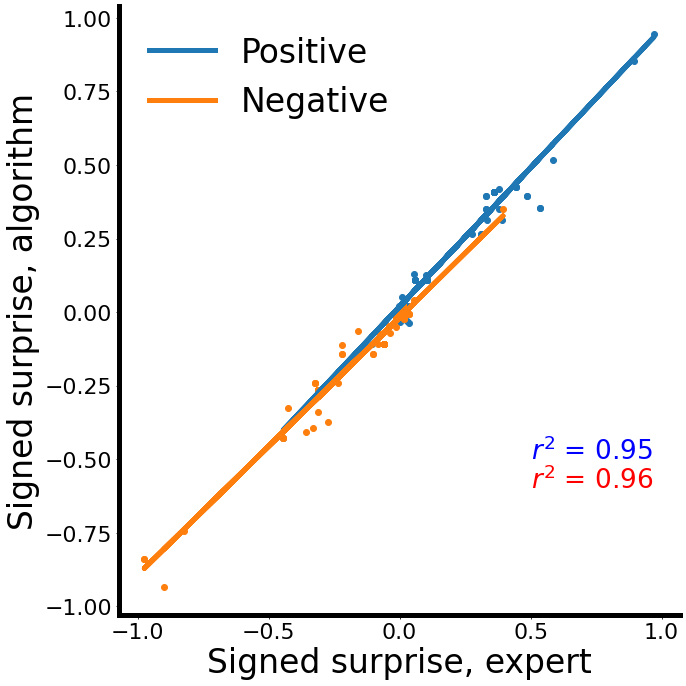

In [ ]:
#check algo vs expert
def scatterp(x1,y1,x2,y2,xl,yl,fn,exv):
    f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
    plt.scatter(x1,y1)
    a1,b1=np.polyfit(x1,y1,1)
    plt.plot(x1, a1*x1+b1,linewidth=lw)
    if len(x2)>0:
        plt.scatter(x2,y2)
        a2,b2=np.polyfit(x2,y2,1)
        plt.plot(x2, a2*x2+b2,linewidth=lw)
    ax.set_xlabel(xl,fontsize=fs)
    ax.set_ylabel(yl,fontsize=fs)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(lw)
    ax.legend(['Positive','Negative'],ncol=1,loc='upper left',fontsize=fs,frameon=False)
    if exv>0:
        ax.legend(['Positive','Negative'],ncol=1,loc='upper right',fontsize=fs,frameon=False)
    corr1, _ = pearsonr(x1,y1)
    corr2, _ = pearsonr(x2,y2)
    if len(fn)>0:
        if exv==1:
            ax.text(0.5,1.3,'$r^{2}$ = %.2f' %corr1**2,fontsize=fs*4/5,color='b')
            ax.text(0.5,1.1,'$r^{2}$ = %.2f' %corr2**2,fontsize=fs*4/5,color='r')
        elif exv==2:
            ax.text(15,1.3,'$r^{2}$ = %.2f' %corr1**2,fontsize=fs*4/5,color='b')
            ax.text(15,1.1,'$r^{2}$ = %.2f' %corr2**2,fontsize=fs*4/5,color='r')
        else:
            ax.text(0.5,-0.5,'$r^{2}$ = %.2f' %corr1**2,fontsize=fs*4/5,color='b')
            ax.text(0.5,-0.6,'$r^{2}$ = %.2f' %corr2**2,fontsize=fs*4/5,color='r')
        f.tight_layout()
        f.savefig(fn, transparent=True)
    return a1,b1,a2,b2

def scatterp2(x1,y1,xl,yl,fn,exv):
    f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
    plt.scatter(x1,y1)
    a1,b1=np.polyfit(x1,y1,1)
    plt.plot(x1, a1*x1+b1,linewidth=lw)
    ax.set_xlabel(xl,fontsize=fs)
    ax.set_ylabel(yl,fontsize=fs)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(lw)
    corr1, _ = pearsonr(x1,y1)
    corr2, _ = pearsonr(x2,y2)
    if len(fn)>0:
        ax.text(15,1.3,'$r^{2}$ = %.2f' %corr1**2,fontsize=fs*4/5,color='k')
        f.tight_layout()
        f.savefig(fn, transparent=True)
    return a1,b1,a2,b2

scatterp(dfp['Relative surprise']/100,dfp['relsur_a'],dfn['Relative surprise']/100,dfn['relsur_a'],
        'Signed surprise, expert','Signed surprise, algorithm','figs/play_algoVexpert.pdf',0)

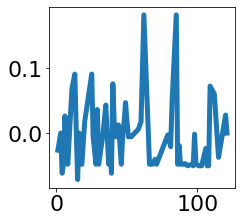

In [ ]:
#plot differences between expert & algorithm to see how much day differed
f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz/3,fsz/3))
plt.plot((dfp['Relative surprise']/100-dfp['relsur_a']),linewidth=lw)

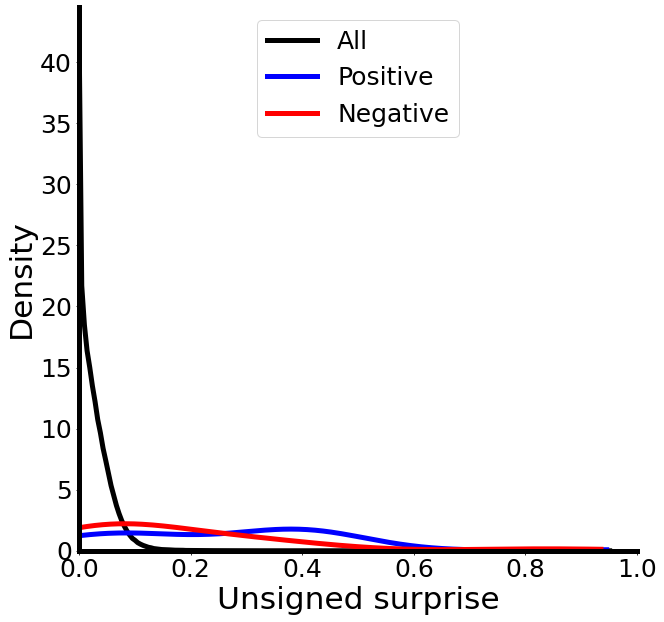

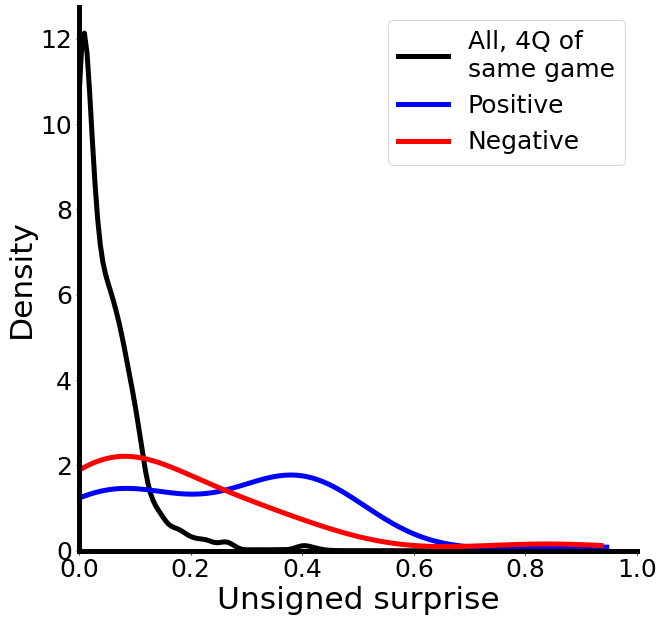

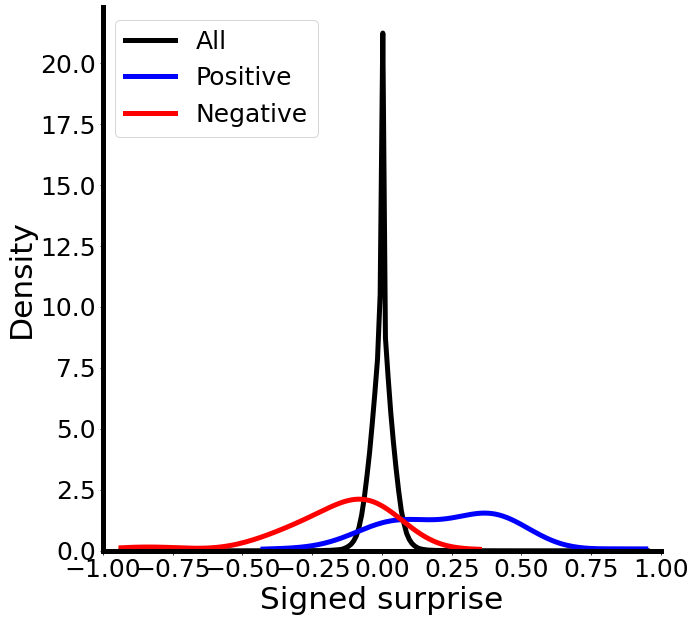

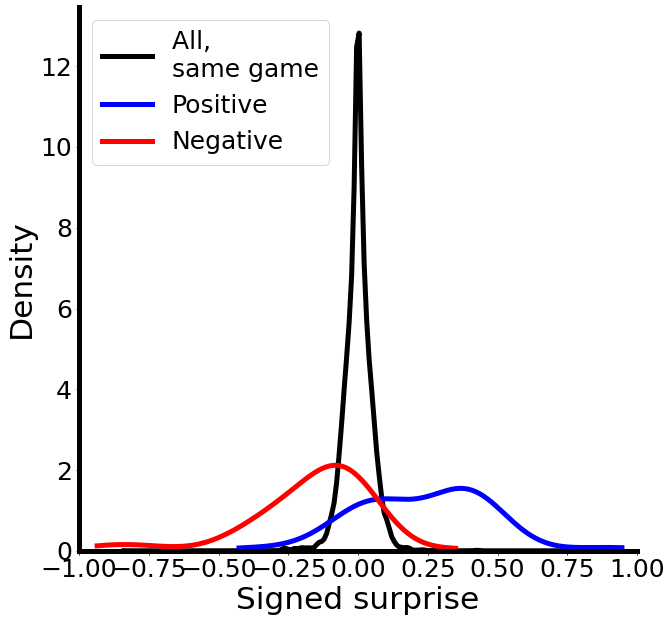

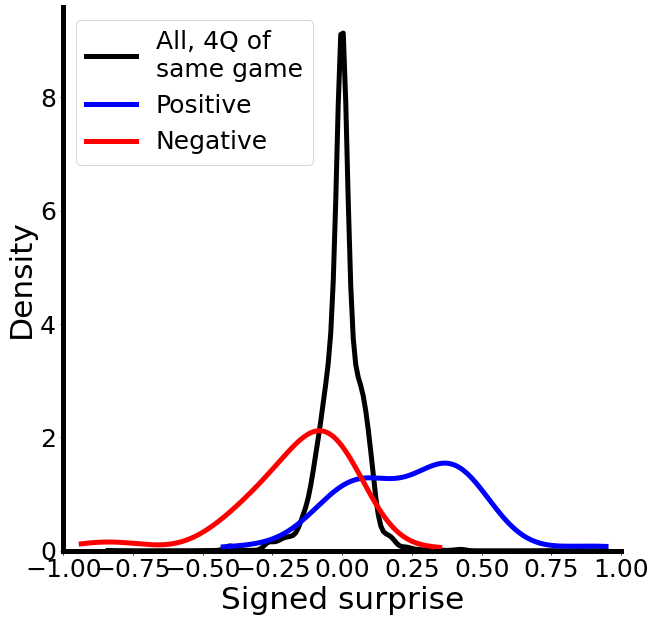

In [ ]:
# plot comparisons between reported memories and null distributions
expert_algo=2 #1=use expert #s, 2=use algorithm
if expert_algo==1:
    sursp,sursn=dfp['Signed surprise']/100,dfn['Signed surprise']/100
elif expert_algo==2:
    sursp,sursn=dfp['relsur_a'],dfn['relsur_a']
    
allgsurs=np.hstack([allgsursp,allgsursn])
allgsurs_4q=np.hstack([allgsursp_4q,allgsursn_4q])

##possession level
nb=100
kdeplotf(np.absolute(allsurs),np.absolute(sursp),np.absolute(sursn),
         'Unsigned surprise',[0,1],'figs/play_abs_surprise.pdf',4)
kdeplotf(np.absolute(allgsurs_4q),np.absolute(sursp),np.absolute(sursn),
         'Unsigned surprise',[0,1],'figs/play_abs_surprise_4q.pdf',6)

kdeplotf(allsurs,sursp,sursn,'Signed surprise',[-1,1],'figs/play_surprise.pdf',0)
kdeplotf(allgsurs,sursp,sursn,'Signed surprise',[-1,1],'figs/play_surprise_allgsurs.pdf',2)
kdeplotf(allgsurs_4q,sursp,sursn,'Signed surprise',[-1,1],'figs/play_surprise_allgsurs_4q.pdf',3)

In [ ]:
# statistical tests
#unsigned
astats2(np.absolute(sursp),np.absolute(allsurs),'unsigned play sur, pos vs allsurs')
astats2(np.absolute(sursp),np.absolute(allgsursp),'unsigned play sur, pos vs allsurs, same game')
astats2(np.absolute(sursp),np.absolute(allgsursp_4q),'unsigned play sur, pos vs allsurs, 4q of same game')
astats2(np.absolute(sursn),np.absolute(allsurs),'unsigned play sur, neg vs allsurs')
astats2(np.absolute(sursn),np.absolute(allgsursn),'unsigned play sur, neg vs allsurs, same game')
astats2(np.absolute(sursn),np.absolute(allgsursn_4q),'unsigned play sur, neg vs allsurs, 4q of same game')
astats2(np.absolute(sursp),np.absolute(sursn),'unsigned play sur, pos vs neg')

#signed
astats2(sursp,allsurs,'signed play sur, pos vs allsurs')
astats2(sursp,allgsursp,'signed play sur, pos vs allsurs, same game')
astats2(sursp,allgsursp_4q,'signed play sur, pos vs allsurs, 4q of same game')
astats2(sursn,allsurs,'signed play sur, neg vs allsurs')
astats2(sursn,allgsursn,'signed play sur, neg vs allsurs, same game')
astats2(sursn,allgsursn_4q,'signed play sur, neg vs allsurs, 4q of same game')
astats2(sursp,sursn,'signed play sur, pos vs neg')

#other qualitative aspects
qq=np.where(abs(sursp)>0.05)
big_i=len(qq[0])/len(sursp)
print('% + plays with >5% impact on game:',big_i)
qq=np.where(abs(sursn)>0.05)
big_i=len(qq[0])/len(sursn)
print('% - plays with >5% impact on game:',big_i)
qq=np.where(abs(sursp)>0.25)
big_i=len(qq[0])/len(sursp)
print('% + plays with >25% impact on game:',big_i)
qq=np.where(abs(sursn)>0.25)
big_i=len(qq[0])/len(sursn)
print('% - plays with >25% impact on game:',big_i)

kurtosis g1: 1.642, p=0.101; kurtosis g2: 1315.464, p=0.0
skewness g1: 2.27, p=0.023; kurtosis g2: 1682.901, p=0.0
use mann-whitney!
unsigned play sur, pos vs allsurs
   meth  g1n    g1m    g1s     g1med      g2n    g2m  g2s     g2med       df  \
0     2   70  0.261  0.024  0.313701  5661042  0.027  0.0  0.019384  5661110   

          stat   tstat    p  p_ttest      d  
0  344307235.5  65.756  0.0      0.0  7.859  


kurtosis g1: 1.642, p=0.101; kurtosis g2: 76.594, p=0.0
skewness g1: 2.27, p=0.023; kurtosis g2: 107.747, p=0.0
use mann-whitney!
unsigned play sur, pos vs allsurs, same game
   meth  g1n    g1m    g1s     g1med    g2n    g2m  g2s     g2med     df  \
0     2   70  0.261  0.024  0.313701  18202  0.034  0.0  0.024241  18270   

        stat   tstat    p  p_ttest      d  
0  1086322.0  44.671  0.0      0.0  5.353  


kurtosis g1: 1.642, p=0.101; kurtosis g2: 37.196, p=0.0
skewness g1: 2.27, p=0.023; kurtosis g2: 52.391, p=0.0
use mann-whitney!
unsigned play sur, pos vs allsu

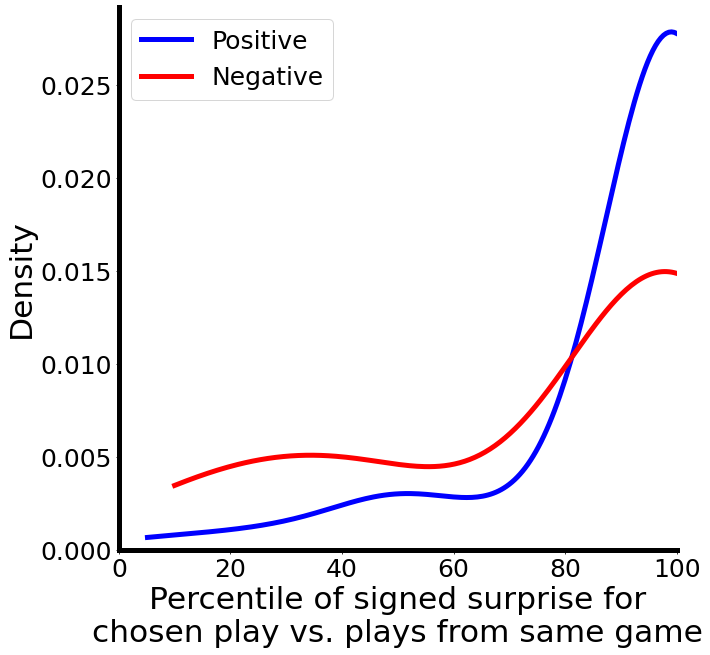

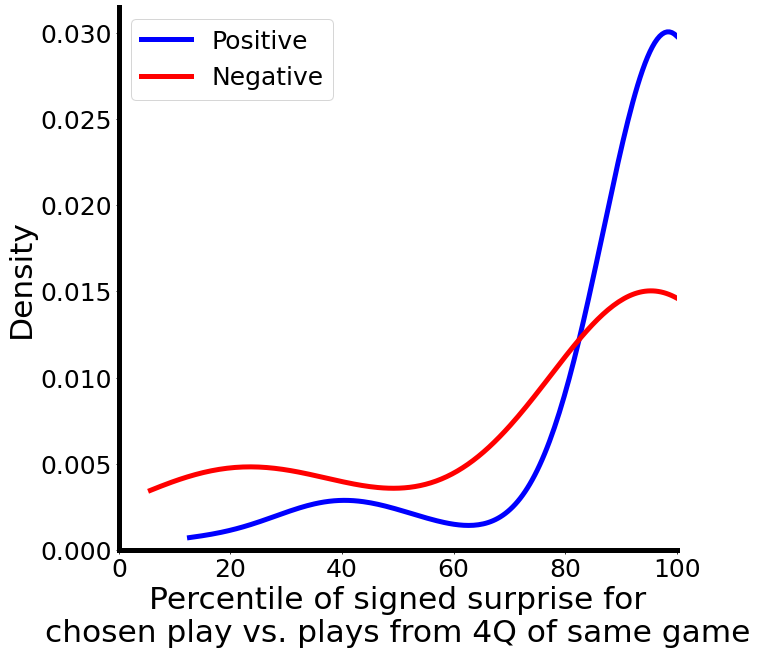

In [ ]:
# play percentiles of surprise against the same game or fourth quarter
kdeplotf(perc_g_surp_abs,perc_g_surn_abs,[],'''Percentile of signed surprise for
chosen play vs. plays from same game''',[0,100],'figs/recalltimes_play.pdf',0)
kdeplotf(perc_g_surp_4q_abs,perc_g_surn_4q_abs,[],'''Percentile of signed surprise for
chosen play vs. plays from 4Q of same game''',[0,100],'figs/recalltimes_play_4q.pdf',0)

In [ ]:
# function for plotting basic comparisons
def barswarm(dp,dn,lab,yl,fn,exv):
    dat1=pd.DataFrame({'Condition':['Positive']*len(dp),lab:dp})
    dat2=pd.DataFrame({'Condition':['Negative']*len(dn),lab:dn})
    dat=dat1.append(dat2)
    f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
    colors = ["blue", "red"] #"#FF0B04", "#4374B3"
    cp = sns.set_palette(sns.color_palette(colors))
    #ax=sns.barplot(x=dat['Condition'],y=dat[lab],facecolor=(1, 1, 1, 0),errcolor=".2",
    #               edgecolor=".2",palette=cp,saturation=1,linewidth=lw,capsize=.3)
    ax=sns.pointplot(x=dat['Condition'],y=dat[lab],color='k',saturation=1,
                     errwidth=lw,capsize=.1)
    ax=sns.violinplot(x=dat['Condition'],y=dat[lab],palette=cp,saturation=0.9,
                      linewidth=lw,inner=None)
    #ax=sns.swarmplot(x=dat['Condition'],y=dat[lab],palette=cp,facecolor=None,size=msz)
    ax.set_ylabel(yl,fontsize=fs)
    ax.set_xlabel('Condition',fontsize=fs)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(lw)
    if exv==0:
        ax.hlines(0,-0.5,1.5,color="black")
    elif exv==1:
        ax.tick_params(axis='x',labelsize=fs*4/5)
        ax.tick_params(axis='y',labelsize=fs*4/5)
        ax.set_yticks(np.linspace(1,4,4))
        ax.set_yticklabels(['Routine','Top 3/game','Top 10/week','Top 10/year'])
    elif exv==2:
        ax.tick_params(axis='x',labelsize=fs*4/5)
        ax.tick_params(axis='y',labelsize=fs*4/5)
        ax.set_yticks(np.linspace(1,4,4))
        ax.set_yticklabels(['Routine','''Good solo
performance or
hyped narrative''','''Performance
in top 10/week''','''Performance
in top 10/year'''])
    elif exv==3:
        ax.hlines(15.5,-0.5,1.5,colors='k', linestyles='dashed',linewidth=lw)
    f.tight_layout()
    f.savefig(fn, transparent=True)

spectacularity, pos vs neg
   g1n    g1m    g1s  g1med  g2n    g2m    g2s  g2med  df  stat  tstat    p  \
0   45  2.044  0.089    2.0   48  1.583  0.121    1.0  91  0.49  3.011  0.0   

   p_ttest      d  
0    0.003  0.631  


r-squared,both = 0.01717066689088297, pval = 0.2105737024054804
r-squared,positive = 0.015555014041321234, pval = 0.41433056874620333
r-squared,negative = 0.013841806545850207, pval = 0.425801381076066
r-squared,unsigned,both = 0.008438505835819706, pval = 0.3811653879375573
r-squared,unsigned,positive = 0.011595658478823673, pval = 0.4813801503947981
r-squared,unsigned,negative = 0.011168941450192382, pval = 0.47467075328229497


(-0.29922417975933174,
 2.1288571116724895,
 0.4793317520818941,
 1.5011734116351938)

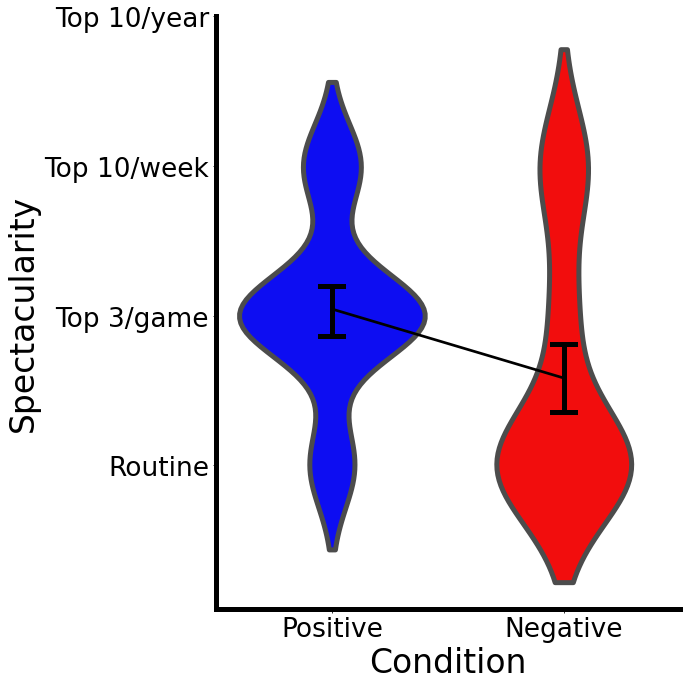

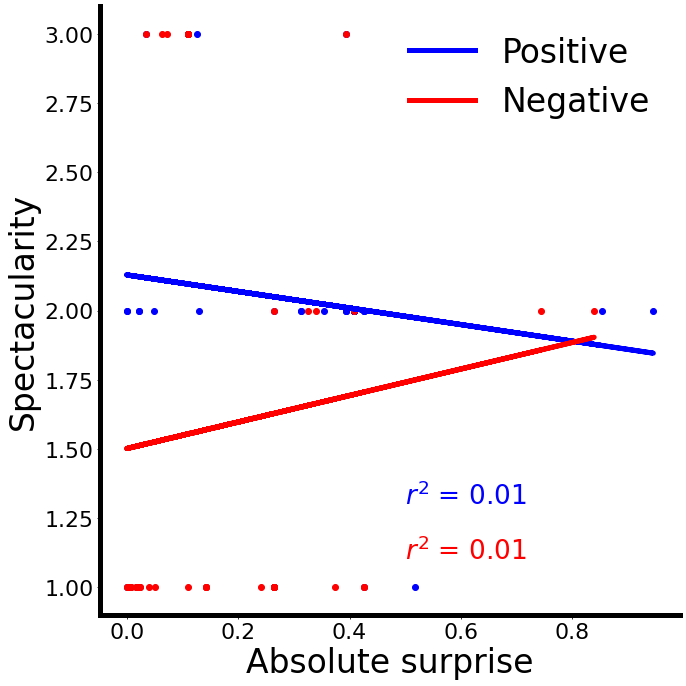

In [ ]:
#spectacularity
ystr1,ybr1='relsur_a','Absolute surprise'
ystr2,ybr2='Spectacularity','Spectacularity'
qp=np.where(dfp[ystr2].isna()==0)[0]
qn=np.where(dfn[ystr2].isna()==0)[0]
x1,x2=dfp[ystr1].values,dfn[ystr1].values
y1,y2=dfp[ystr2].values,dfn[ystr2].values

fn='figs/play_'+str(ystr2)+'.pdf'
barswarm(y1[qp],y2[qn],ybr2,ybr2,fn,1)

astats3(y1[qp],y2[qn],'spectacularity, pos vs neg')

#signed
corr, pval = pearsonr(np.hstack([x1[qp],x2[qn]]),np.hstack([y1[qp],y2[qn]]))
print('r-squared,both = %s, pval = %s' %(corr**2,pval))
corr, pval = pearsonr(x1[qp],y1[qp])
print('r-squared,positive = %s, pval = %s' %(corr**2,pval))
corr, pval = pearsonr(x2[qn],y2[qn])
print('r-squared,negative = %s, pval = %s' %(corr**2,pval))

#unsigned
x1,x2=np.absolute(dfp[ystr1].values),np.absolute(dfn[ystr1].values)
corr, pval = pearsonr(np.hstack([x1[qp],x2[qn]]),np.hstack([y1[qp],y2[qn]]))
print('r-squared,unsigned,both = %s, pval = %s' %(corr**2,pval))
corr, pval = pearsonr(x1[qp],y1[qp])
print('r-squared,unsigned,positive = %s, pval = %s' %(corr**2,pval))
corr, pval = pearsonr(x2[qn],y2[qn])
print('r-squared,unsigned,negative = %s, pval = %s' %(corr**2,pval))

scatterp(x1[qp],y1[qp],x2[qn],y2[qn],ybr1,ybr2,'figs/play_'+str(ystr1)+'_'+str(ystr2)+'.pdf',1)

time affected, pos vs neg
   g1n    g1m    g1s  g1med  g2n    g2m   g2s  g2med   df  stat  tstat      p  \
0   68  3.162  0.145    3.0   73  2.836  0.15    3.0  139  0.12  1.548  0.634   

   p_ttest      d  
0    0.124  0.263  


r-squared,positive = 0.0071634075685594, pval = 0.49256988810321245
r-squared,negative = 0.025852422435812244, pval = 0.17417420585825613


(-0.506377762139756, 3.291865429389867, -1.0137971115924105, 3.016604146533269)

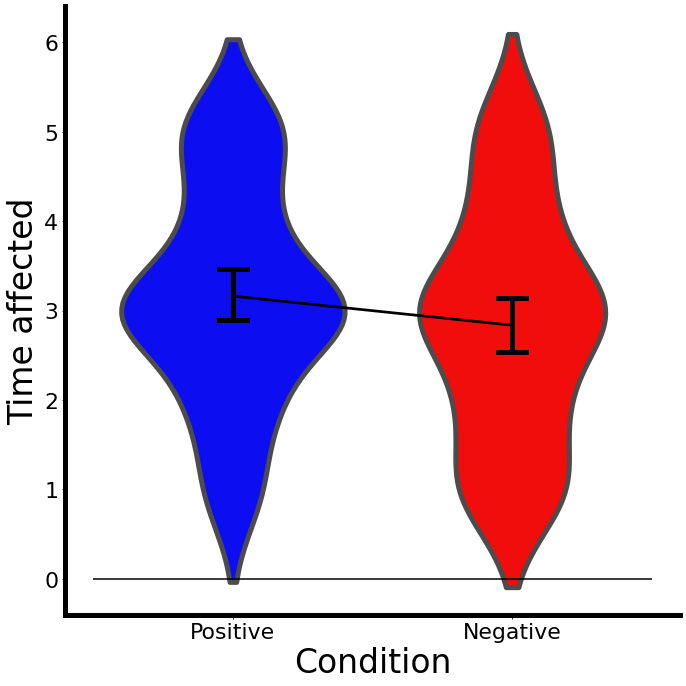

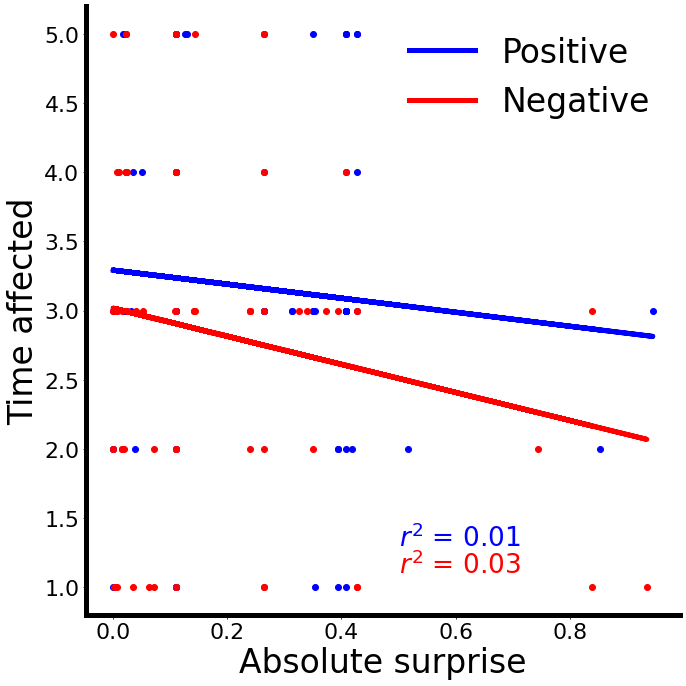

In [ ]:
# time affected
ystr2,ybr2='How long affected? (1=minutes,2=hours,3=days,4=months,5=still affected)','Time affected'
qp=np.where(dfp[ystr2].isna()==0)[0]
qn=np.where(dfn[ystr2].isna()==0)[0]
x1,x2=np.absolute(dfp[ystr1].values),np.absolute(dfn[ystr1].values)
y1,y2=dfp[ystr2].values,dfn[ystr2].values

fn='figs/play_'+str(ybr2)+'.pdf'
barswarm(y1[qp],y2[qn],ybr2,ybr2,fn,0)

astats3(y1[qp],y2[qn],'time affected, pos vs neg')
corr, pval = pearsonr(x1[qp],y1[qp])
print('r-squared,positive = %s, pval = %s' %(corr**2,pval))
corr, pval = pearsonr(x2[qn],y2[qn])
print('r-squared,negative = %s, pval = %s' %(corr**2,pval))

scatterp(x1[qp],y1[qp],x2[qn],y2[qn],ybr1,ybr2,'figs/play_'+str(ystr1)+'_'+str(ystr2)+'.pdf',1)

# Game data

In [ ]:
# clean up and organize game data
m_ind,d_ind=np.zeros((ngp)),np.zeros((ngp))
for i in range(ngp):
    m_ind[i]=dfgp['Month/date'][dfgp.index[i]][5:7]
    d_ind[i]=dfgp['Month/date'][dfgp.index[i]][8:10]
dfgp['month']=m_ind
dfgp['day']=d_ind
dfgp[['month','day','Year','home']] = dfgp[['month','day','Year','home']].astype(int)
m_ind,d_ind=np.zeros((ngn)),np.zeros((ngn))
for i in range(ngn):
    m_ind[i]=dfgn['Month/date'][dfgn.index[i]][5:7]
    d_ind[i]=dfgn['Month/date'][dfgn.index[i]][8:10]
dfgn['month']=m_ind
dfgn['day']=d_ind
dfgn[['month','day','Year','home']] = dfgn[['month','day','Year','home']].astype(int)
#read in odds data
dfgo=pd.read_excel('nba_odds_all.xlsx',sheet_name='odds',header=0) 
ngo=len(dfgo)
dfgo.head()


SY  Ind  Date  Rot VH        Team Team3  1st  2nd  3rd  4th  Final  \
0  2007  914   102  702  H     Orlando   ORL   31   15   31   18     95   
1  2007  916   102  704  H  Washington   WSH   27   20   25   21     93   
2  2007  918   102  706  H   Charlotte   CHA   28   29   22   18     97   
3  2007  920   102  708  H   Cleveland   CLE   22   15   32   29     98   
4  2007  922   102  710  H     Indiana   IND   22   22   19    9     72   

    Open Close   ML   2H     Date_f  
0    6.5   6.5 -260    1 2008-01-02  
1  192.5   192  190  0.5 2008-01-02  
2    1.5   191  100   95 2008-01-02  
3    4.5     5 -215    4 2008-01-02  
4    6.5     6 -255    3 2008-01-02

In [ ]:
# break down game odds data
t_i,o_i=np.zeros((ngo)),np.zeros((ngo))
buff1,buff2,buff3=np.zeros((ngo)),np.zeros((ngo)),np.zeros((ngo))
for i in range(ngo):
    t_i[i]=nba3.index(dfgo['Team3'][i][:3]) #team index
    ob=int(dfgo['ML'][i])
    if ob>0:
        o_i[i]=100/(100+ob) #odds index
    else:
        o_i[i]=np.absolute(ob)/(100+np.absolute(ob))
    buff1[i]=int(str(dfgo['Date_f'][i])[0:4]) #year
    buff2[i]=int(str(dfgo['Date_f'][i])[5:7]) #month
    buff3[i]=int(str(dfgo['Date_f'][i])[8:10]) #date
dfgo['t_i']=t_i
dfgo['o_i']=o_i
dfgo['year']=buff1
dfgo['month']=buff2
dfgo['day']=buff3

In [ ]:
#make fwwps_o - find final outcomes using df1 and find how wrong
#probabilities based on odds data were. then we can also correlate pre-game 
#probs with both methods
ids,c,k=df1.g_id.unique(),0,0
print('# games:',len(ids))
for i,ii in enumerate(ids): #loop through all games
    proc=0
    qq=np.where(df1['g_id']==ii)[0] # find rows of this game
    curr_y=df1['year'][df1.index[qq[-1]]]
    if curr_y>=2007:
        proc=1
        curr_m=df1['month'][df1.index[qq[-1]]]
        if np.logical_and(curr_y==2007,curr_m<7):
            proc=0
    if proc:
        pgp=df1['hwp'][qq[0]] #pre-game odds, home
        
        curr_d=df1['day'][df1.index[qq[-1]]]
        curr_ht=df1['home'][df1.index[qq[-1]]]
        buff=np.where(np.logical_and(np.logical_and(np.logical_and(
            curr_y==dfgo['year'],curr_m==dfgo['month']),
            curr_d==dfgo['day']),curr_ht==dfgo['t_i']))[0]
        if len(buff)>0:
            pgp_o=dfgo['o_i'][buff[0]]
            if int(df1['sdiff'][qq[-1]])>0: #if home team won
                firstwwp_o=pgp
            else: #away team won
                firstwwp_o=1-pgp
            if c==0:
                pgps,pgps_o,c=pgp,pgp_o,1
                fwwps_o=firstwwp_o+0
            else:
                pgps,pgps_o=np.vstack([pgps,pgp]),np.vstack([pgps_o,pgp_o])
                fwwps_o=np.vstack([fwwps_o,firstwwp_o])
    q2=df1['fgsur'][df1.index[qq[0]]]
    if q2==0: # in some cases, differences in pre-team strengths were never overcome and show up as 0% surprise from the algorithm
        q2=0.002 # ceiling
    if k==0:
        fgsur_a=q2
        k=1
    else:
        fgsur_a=np.hstack([fgsur_a,q2])
    if i%10000==0: #progress
        print(i)

# games: 22539
0
10000
20000


In [ ]:
# compare methods
corr, pval = pearsonr(pgps_o[:,0],pgps[:,0])
print('r-squared,positive = %s, pval = %s' %(corr**2,pval))

r-squared,positive = 0.5535394860039119, pval = 0.0


In [ ]:
#find null distribution of full-game surprise by algorithm - redundant w/ 1-fwwps - internal check
ids,k=df1.g_id.unique(),0
print('# games:',len(ids))
for iii,ii in enumerate(ids): #loop through all games
    q1=np.where(df1['g_id']==ii)[0] # find rows of this game
    q2=df1['fgsur'][df1.index[q1[0]]]
    if q2==0: # in some cases, differences in pre-team strengths were never over come and show up as 0% surprise from the algorithm
        q2=0.002 # ceiling
    if k==0:
        fgsur_a=q2
        k=1
    else:
        fgsur_a=np.hstack([fgsur_a,q2])
    if i%10000==0: #progress
        print(i)

# games: 22539


In [ ]:
#find and align reported games!!!!! #positive first
gsursp_a,perc_s_surp,perc_s_surp_poffs=np.zeros((ngp)),np.zeros((ngp)),np.zeros((ngp))
gsursp_a_abs,perc_s_surp_abs,perc_into_szngp=np.zeros((ngp)),np.zeros((ngp)),np.zeros((ngp))
perc_s_surp_poffs_abs,gmaxsursp_a,gsursp_st_a=np.zeros((ngp)),np.zeros((ngp)),np.zeros((ngp))
gsursp_t_a,g_oddsp_a,gsursp_st_odds_a=np.zeros((ngp)),np.zeros((ngp)),np.zeros((ngp))
t_i_gp,y_i_gp,k=np.zeros((ngp)),np.zeros((ngp)),0
for i in range(ngp):
    curr_y=dfgp['Year'][dfgp.index[i]] #match year
    curr_m=dfgp['month'][dfgp.index[i]] #match month
    curr_d=dfgp['day'][dfgp.index[i]] #match date
    curr_ht=dfgp['home'][dfgp.index[i]] #match home team
    q=np.where(df1['year']==curr_y)[0]
    qq=np.where(df1['month'][q]==curr_m)[0]
    qqq=np.where(df1['day'][q[qq]]==curr_d)[0]
    qqqq=np.where(df1['home'][q[qq[qqq]]]==curr_ht)[0]
    t_i_gp[i],y_i_gp[i]=curr_ht,curr_y
    
    # all games for this team for this season
    if curr_y!=2020:
        mthc=8 
    else:
        mthc=11
    if curr_m>mthc: 
        szn=curr_y+0
    else:
        szn=curr_y-1 
    qqqqq=np.where(np.logical_and(np.logical_and(np.logical_or(df1['home']==curr_ht,df1['vis']==curr_ht),
                                             df1['year']==szn),df1['month']>mthc))[0]
    df1szne=df1.iloc[qqqqq] 
    qqqqq=np.where(np.logical_and(np.logical_and(np.logical_or(df1['home']==curr_ht,df1['vis']==curr_ht),
                                             df1['year']==szn+1),df1['month']<mthc))[0]
    df1sznl=df1.iloc[qqqqq]
    df1szn=pd.concat([df1szne,df1sznl]) 
    ids_tszn=df1szn.g_id.unique()
    print('# games:',len(ids_tszn))
    for iii,ii in enumerate(ids_tszn): #loop through all games
        q1=np.where(df1szn['g_id']==ii)[0] # find rows of this game
        q2=df1szn['fgsur'][df1szn.index[q1[0]]]
        #print('fgsur:',q2)
        if q2==0: # in some cases, differences in pre-team strengths were never over come and show up as 0% surprise from the algorithm
            q2=0.002 # ceiling
        if k==0:
            fgsur_szn_games,fgsur_szn_gamesp=q2,q2
            k=1
        else:
            fgsur_szn_games=np.hstack([fgsur_szn_games,q2])
            fgsur_szn_gamesp=np.hstack([fgsur_szn_gamesp,q2])
    
    print('i, Year, month, date, home:%s,%s,%s,%s,%s' %(dfgp.index[i],curr_y,curr_m,curr_d,curr_ht))
    print('rows, rows, rows, rows:%s,%s,%s,%s' %(len(q),len(qq),len(qqq),len(qqqq)))
    df1gt=df1.iloc[q[qq[qqq[qqqq]]]] #dataframe representing full game
    gmaxsursp_a[i]=df1gt['maxsur'][df1gt.index[0]] #max PLAY surprise in game
    gsursp_st_a[i]=df1gt['hwp'][df1gt.index[-1]]-df1gt['hwp'][df1gt.index[0]] #game surprise end vs. start
    
    if df1gt['hwp'][df1gt.index[-1]]==1: #home team won
        gsursp_a[i]=1-df1gt['mwwp'][df1gt.index[0]] #relative comeback effect by the algorithm
        #use absolute here because there are some miniscule rounding errors
        mwwpi=np.where(np.absolute(df1gt['hwp'][df1gt.index]-df1gt['mwwp'][df1gt.index[0]])<0.0001)[0]
    else:
        gsursp_a[i]=-(1-df1gt['mwwp'][df1gt.index[0]])
        mwwpi=np.where(np.absolute(df1gt['hwp'][df1gt.index]-(1-df1gt['mwwp'][df1gt.index[0]]))<0.0001)[0]
    gsursp_t_a[i]=df1gt['sl'][df1gt.index[mwwpi[0]]] #time in game of moment furthest from comeback        
        
    gsursp_a_abs[i]=np.absolute(df1gt['mwwp'][df1gt.index[0]]) #abs comeback effect by the algorithm
    print('gsur, gmaxsur,gsur_st:%s,%s,%s' #    print('gsur, gmaxsur,gsur_st:%s,%s,%s,%s' #
          %(format(gsursp_a[i],".2f"), #,format(perc_g_surp[i],".2f")
            format(gmaxsursp_a[i],".2f"),format(gmaxsursp_a[i],".2f"))) 
    
    print('\n')
    #find % of way into season of games
    curr_g_id=df1gt['g_id'][df1gt.index[0]] #current game id
    if curr_y!=2020: #not bubble year
        mthc=8 #month cutoff
    else:
        mthc=11 #month cutoff
    if curr_m>mthc: #if happens in early part of season
        szn=curr_y+0
    else:
        szn=curr_y-1 #if happens in late part
    #find games in early part of year
    q=np.where(np.logical_and(np.logical_and(np.logical_or(df1['home']==curr_ht,df1['vis']==curr_ht),
                                             df1['year']==szn),df1['month']>mthc))[0]
    df1szne=df1.iloc[q] 
    q=np.where(np.logical_and(np.logical_and(np.logical_or(df1['home']==curr_ht,df1['vis']==curr_ht),
                                             df1['year']==szn+1),df1['month']<mthc))[0]
    df1sznl=df1.iloc[q]
    df1szn=pd.concat([df1szne,df1sznl])
    ids_tszn=df1szn.g_id.unique()
    perc_into_szngp[i]=stats.percentileofscore(ids_tszn,curr_g_id)

    #grab pre-game betting odds
    if curr_y>=2007:
        q=np.where(dfgo['year']==curr_y)[0]
        qq=np.where(dfgo['month'][q]==curr_m)[0]
        qqq=np.where(dfgo['day'][q[qq]]==curr_d)[0]
        qqqq=np.where(dfgo['t_i'][q[qq[qqq]]]==curr_ht)[0]
        g_oddsp_a[i]=dfgo['o_i'][q[qq[qqq[qqqq]]]] #pre-game odds
        gsursp_st_odds_a[i]=df1gt['hwp'][df1gt.index[-1]]-g_oddsp_a[i] #game surprise end vs. start

# games: 111
i, Year, month, date, home:1,2015,1,23,9
rows, rows, rows, rows:362147,58278,2764,280
gsur, gmaxsur,gsur_st:0.31,0.20,0.20


# games: 108
i, Year, month, date, home:3,2008,6,17,2
rows, rows, rows, rows:330313,1470,257,257
gsur, gmaxsur,gsur_st:0.82,0.11,0.11


# games: 113
i, Year, month, date, home:4,2016,6,5,9
rows, rows, rows, rows:367236,1730,241,241
gsur, gmaxsur,gsur_st:0.49,0.09,0.09


# games: 111
i, Year, month, date, home:5,2015,1,23,9
rows, rows, rows, rows:362147,58278,2764,280
gsur, gmaxsur,gsur_st:0.31,0.20,0.20


# games: 88
i, Year, month, date, home:7,2018,11,19,25
rows, rows, rows, rows:358838,57070,2360,281
gsur, gmaxsur,gsur_st:0.61,0.14,0.14


# games: 106
i, Year, month, date, home:8,2016,12,5,9
rows, rows, rows, rows:367236,59347,2919,286
gsur, gmaxsur,gsur_st:0.19,0.06,0.06


# games: 113
i, Year, month, date, home:9,2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
gsur, gmaxsur,gsur_st:-0.84,0.18,0.18


# games: 79
i, Year, month, date, home:

In [ ]:
# find and align negative games
gsursn_a,perc_s_surn,perc_s_surn_poffs=np.zeros((ngn)),np.zeros((ngn)),np.zeros((ngn))
gsursn_a_abs,perc_s_surn_abs,perc_into_szngn=np.zeros((ngn)),np.zeros((ngn)),np.zeros((ngn))
perc_s_surn_poffs_abs,gmaxsursn_a,gsursn_st_a=np.zeros((ngn)),np.zeros((ngn)),np.zeros((ngn))
gsursn_t_a,g_oddsn_a,gsursn_st_odds_a=np.zeros((ngn)),np.zeros((ngn)),np.zeros((ngn))
t_i_gn,y_i_gn,k2=np.zeros((ngn)),np.zeros((ngn)),0
for i in range(ngn):
    curr_y=dfgn['Year'][dfgn.index[i]] #match year
    q=np.where(df1['year']==curr_y)[0]
    curr_m=dfgn['month'][dfgn.index[i]] #match month
    qq=np.where(df1['month'][q]==curr_m)[0]
    curr_d=dfgn['day'][dfgn.index[i]] #match date
    qqq=np.where(df1['day'][q[qq]]==curr_d)[0]
    curr_ht=dfgn['home'][dfgn.index[i]] #match home team
    qqqq=np.where(df1['home'][q[qq[qqq]]]==curr_ht)[0]
    t_i_gn[i],y_i_gn[i]=curr_ht,curr_y

    # all games for this team for this season
    if curr_y!=2020:
        mthc=8 
    else:
        mthc=11
    if curr_m>mthc: 
        szn=curr_y+0
    else:
        szn=curr_y-1 
    qqqqq=np.where(np.logical_and(np.logical_and(np.logical_or(df1['home']==curr_ht,df1['vis']==curr_ht),
                                             df1['year']==szn),df1['month']>mthc))[0]
    df1szne=df1.iloc[qqqqq] 
    qqqqq=np.where(np.logical_and(np.logical_and(np.logical_or(df1['home']==curr_ht,df1['vis']==curr_ht),
                                             df1['year']==szn+1),df1['month']<mthc))[0]
    df1sznl=df1.iloc[qqqqq]
    df1szn=pd.concat([df1szne,df1sznl]) 
    ids_tszn=df1szn.g_id.unique()
    print('# games:',len(ids_tszn))
    for iii,ii in enumerate(ids_tszn): #loop through all games
        q1=np.where(df1szn['g_id']==ii)[0] # find rows of this game
        q2=df1szn['fgsur'][df1szn.index[q1[0]]]
        fgsur_szn_games=np.hstack([fgsur_szn_games,q2])
        if k2==0:
            fgsur_szn_gamesn=q2
            k2=1
        else:
            fgsur_szn_gamesn=np.hstack([fgsur_szn_gamesn,q2])
    
    print('Year, month, date, home:%s,%s,%s,%s' %(curr_y,curr_m,curr_d,curr_ht))
    print('rows, rows, rows, rows:%s,%s,%s,%s' %(len(q),len(qq),len(qqq),len(qqqq)))
    df1gt=df1.iloc[q[qq[qqq[qqqq]]]] #dataframe representing full game
    gmaxsursn_a[i]=df1gt['maxsur'][df1gt.index[0]] #max PLAY surprise in game
    gsursn_st_a[i]=df1gt['hwp'][df1gt.index[-1]]-df1gt['hwp'][df1gt.index[0]] #game surprise end vs. start
    if df1gt['hwp'][df1gt.index[-1]]==1: #home team won
        gsursn_a[i]=1-df1gt['mwwp'][df1gt.index[0]] #relative game surprise by the algorithm
        mwwpi=np.where(np.absolute(df1gt['hwp'][df1gt.index]-df1gt['mwwp'][df1gt.index[0]])<0.0001)[0]
        gsursn_t_a[i]=df1gt['sl'][df1gt.index[mwwpi[0]]]      
    else:
        gsursn_a[i]=-(1-df1gt['mwwp'][df1gt.index[0]])
        mwwpi=np.where(np.absolute(df1gt['hwp'][df1gt.index]-(1-df1gt['mwwp'][df1gt.index[0]]))<0.0001)[0]
        gsursn_t_a[i]=df1gt['sl'][df1gt.index[mwwpi[0]]]       
        
        
    gsursn_a_abs[i]=np.absolute(df1gt['mwwp'][df1gt.index[0]]) #abs game surprise by the algorithm
    print('gsur, gmaxsur,gsur_st:%s,%s,%s' #    print('gsur, gmaxsur,gsur_st:%s,%s,%s,%s' #
          %(format(gsursn_a[i],".2f"), #,format(perc_g_surp[i],".2f")
            format(gmaxsursn_a[i],".2f"),format(gmaxsursn_a[i],".2f"))) 
    print('\n')
    curr_g_id=df1gt['g_id'][df1gt.index[0]] #current game id
    if curr_y!=2020: #not bubble year
        mthc=8 #month cutoff
    else:
        mthc=11 #month cutoff
    if curr_m>mthc: #if happens in early part of season
        szn=curr_y+0
    else:
        szn=curr_y-1 #if happens in late part
    #find games in early part of year
    q=np.where(np.logical_and(np.logical_and(np.logical_or(df1['home']==curr_ht,df1['vis']==curr_ht),
                                             df1['year']==szn),df1['month']>mthc))[0]
    df1szne=df1.iloc[q] 
    q=np.where(np.logical_and(np.logical_and(np.logical_or(df1['home']==curr_ht,df1['vis']==curr_ht),
                                             df1['year']==szn+1),df1['month']<mthc))[0]
    df1sznl=df1.iloc[q]
    df1szn=pd.concat([df1szne,df1sznl]) #df of all updates in this season!
    ids_tszn=df1szn.g_id.unique()
    perc_into_szngn[i]=stats.percentileofscore(ids_tszn,curr_g_id)

    #grab pre-game betting odds
    if curr_y>=2007:
      q=np.where(dfgo['year']==curr_y)[0]
      qq=np.where(dfgo['month'][q]==curr_m)[0]
      qqq=np.where(dfgo['day'][q[qq]]==curr_d)[0]
      qqqq=np.where(dfgo['t_i'][q[qq[qqq]]]==curr_ht)[0]
      g_oddsn_a[i]=dfgo['o_i'][q[qq[qqq[qqqq]]]] #pre-game odds
      gsursn_st_odds_a[i]=df1gt['hwp'][df1gt.index[-1]]-g_oddsn_a[i] #game surprise end vs. start

# games: 113
Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
gsur, gmaxsur,gsur_st:-0.84,0.18,0.18


# games: 109
Year, month, date, home:2019,6,13,9
rows, rows, rows, rows:352368,1274,260,260
gsur, gmaxsur,gsur_st:-0.75,0.19,0.19


# games: 76
Year, month, date, home:2020,9,30,13
rows, rows, rows, rows:205965,9067,248,248
gsur, gmaxsur,gsur_st:0.68,0.09,0.09


# games: 79
Year, month, date, home:2020,9,27,15
rows, rows, rows, rows:205965,9067,247,247
gsur, gmaxsur,gsur_st:0.70,0.12,0.12


# games: 59
Year, month, date, home:2020,1,12,14
rows, rows, rows, rows:205965,57836,1820,285
gsur, gmaxsur,gsur_st:0.42,0.09,0.09


# games: 113
Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
gsur, gmaxsur,gsur_st:-0.84,0.18,0.18


# games: 113
Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
gsur, gmaxsur,gsur_st:-0.84,0.18,0.18


# games: 88
Year, month, date, home:2019,3,22,13
rows, rows, rows, rows:35236

kurtosis g1: -1.198, p=0.231; kurtosis g2: 4.052, p=0.0
skewness g1: -3.317, p=0.001; kurtosis g2: -6.111, p=0.0
use mann-whitney!
times into game, pos vs neg
   meth  g1n     g1m   g1s      g1med  g2n     g2m    g2s  g2med   df    stat  \
0     2   77  79.467  3.18  98.837209   74  91.785  2.111  100.0  149  2225.0   

   tstat      p  p_ttest      d  
0  -3.18  0.012    0.002 -0.521  




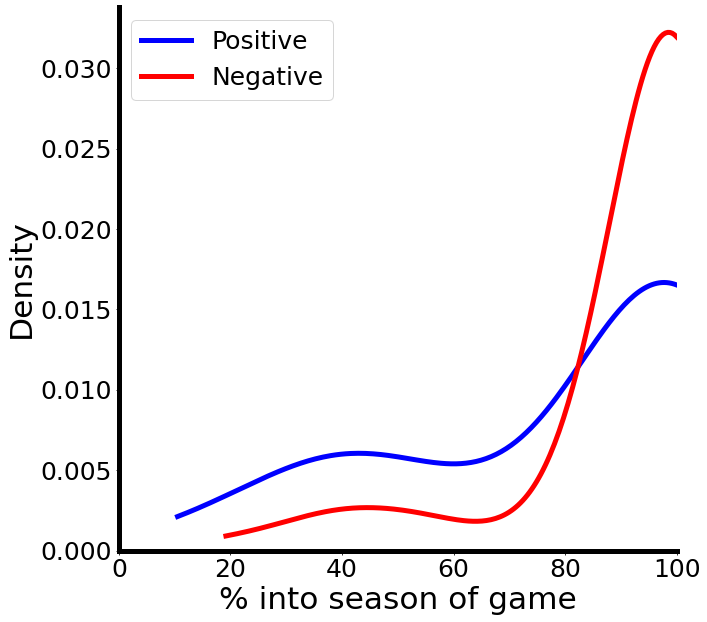

In [ ]:
# plot percentile into the season of game
x,y=perc_into_szngp+0,perc_into_szngn+0
astats2(x,y,'times into game, pos vs neg')

kdeplotf(x,y,[],'% into season of game',[0,100],'figs/game_perc_into_szn.pdf',0)

In [ ]:
qq=100==perc_into_szngp
print('# last game',np.sum(qq))
print('# games',len(perc_into_szngp))
lastgameperc=np.sum(qq)/len(perc_into_szngp)
print(lastgameperc)

# last game 35
# games 77
0.45454545454545453


(0.9542329708687951,
 0.03587358487346553,
 0.9883486876040508,
 -0.022160767793215522)

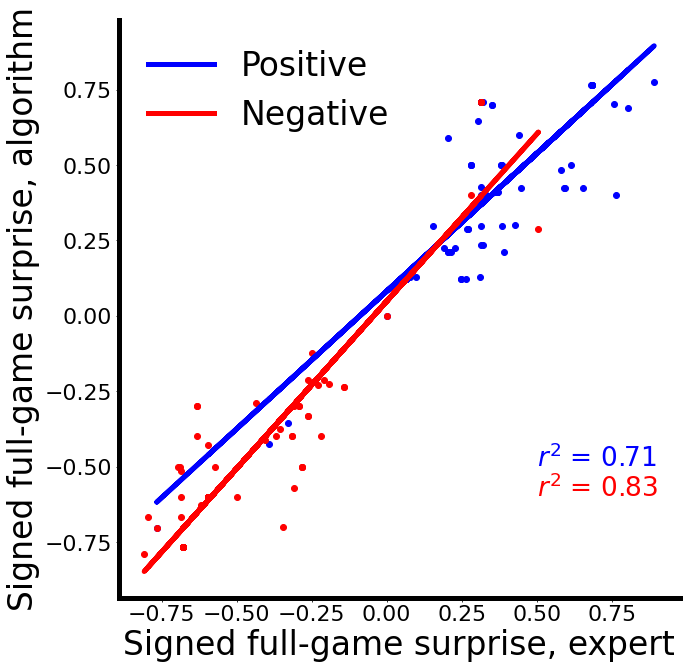

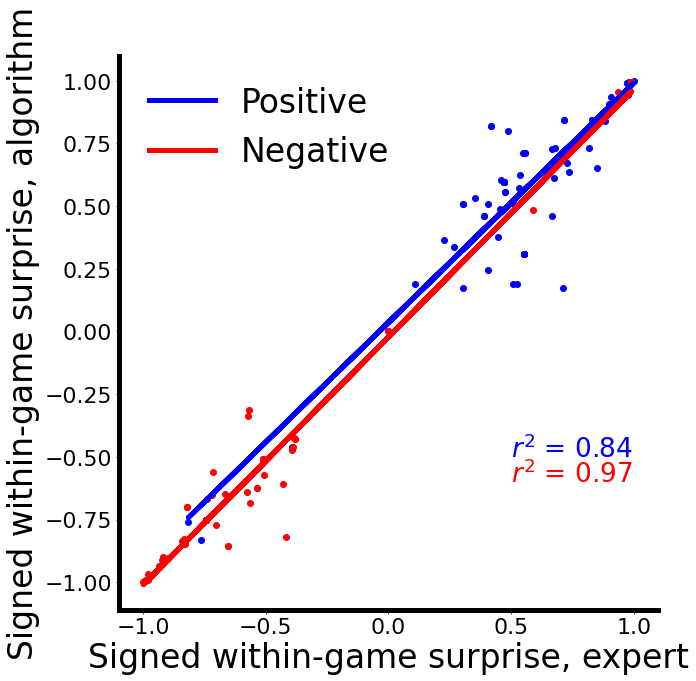

In [ ]:
#check algo vs expert
chvp=np.zeros((ngp))
for i in range(ngp):
    if int(dfgp['Cheering for? (1=H,-1=V)'][dfgp.index[i]])==1:
        chvp[i]=1
    elif int(dfgp['Cheering for? (1=H,-1=V)'][dfgp.index[i]])==-1:
        chvp[i]=-1
dfgp['chv']=chvp
chvn=np.zeros((ngn)) #fix quick thing with cheering for being strings / inconvertible to int quickly
for i in range(ngn):
    if int(dfgn['Cheering for? (1=H,-1=V)'][dfgn.index[i]])==1:
        chvn[i]=1
    elif int(dfgn['Cheering for? (1=H,-1=V)'][dfgn.index[i]])==-1:
        chvn[i]=-1
dfgn['chv']=chvn

dfgp['relcbsur_a']=np.multiply(gsursp_a,dfgp['chv'].values) #relative within-game surprise by algorithm
dfgn['relcbsur_a']=np.multiply(gsursn_a,dfgn['chv'].values)
dfgp['relgsur_a']=np.multiply(gsursp_st_a,dfgp['chv'].values) #post- minus pre-game surprise by algorithm
dfgn['relgsur_a']=np.multiply(gsursn_st_a,dfgn['chv'].values)

scatterp(dfgp['Relative surprise (game-level)']/100,dfgp['relgsur_a'],
        dfgn['Relative surprise (game-level)']/100,dfgn['relgsur_a'],
        'Signed full-game surprise, expert','Signed full-game surprise, algorithm',
        'figs/game_fullgame_algoVexpert.pdf',0)

scatterp(dfgp['Comeback via website (if NBA/WNBA)']/100,dfgp['relcbsur_a'],
        dfgn['Comeback via website (if NBA/WNBA)']/100,dfgn['relcbsur_a'],
        'Signed within-game surprise, expert','Signed within-game surprise, algorithm',
        'figs/game_cb_algoVexpert.pdf',0)

(0.9417779565015822,
 0.054263370837764766,
 1.0653516675679697,
 0.0067096716736531805)

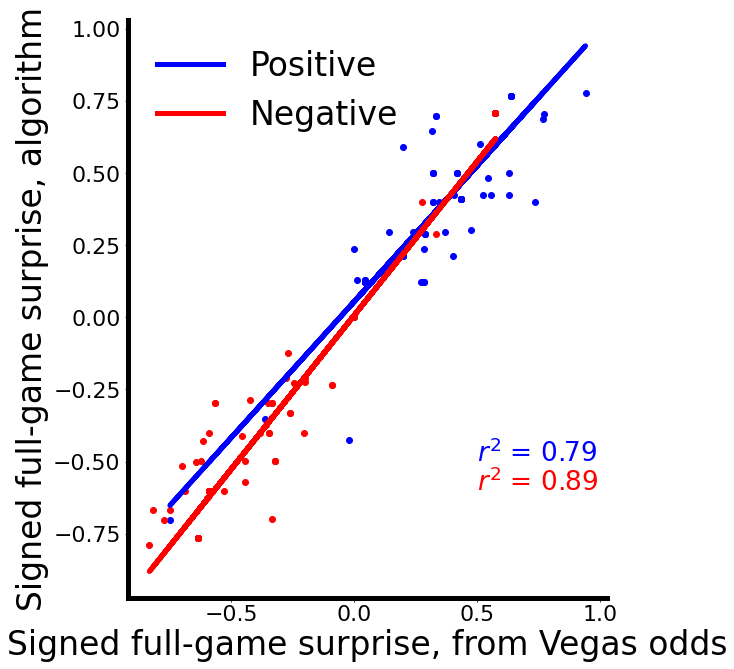

In [ ]:
#check algo vs betting odds
dfgp['relg_odds_a']=np.multiply(gsursp_st_odds_a,dfgp['chv'].values) #post- minus pre-game surprise by algorithm
dfgn['relg_odds_a']=np.multiply(gsursn_st_odds_a,dfgn['chv'].values)

scatterp(dfgp['relg_odds_a'],dfgp['relgsur_a'],
        dfgn['relg_odds_a'],dfgn['relgsur_a'],
        'Signed full-game surprise, from Vegas odds','Signed full-game surprise, algorithm',
        'figs/game_fullgame_algoVodds.pdf',0)

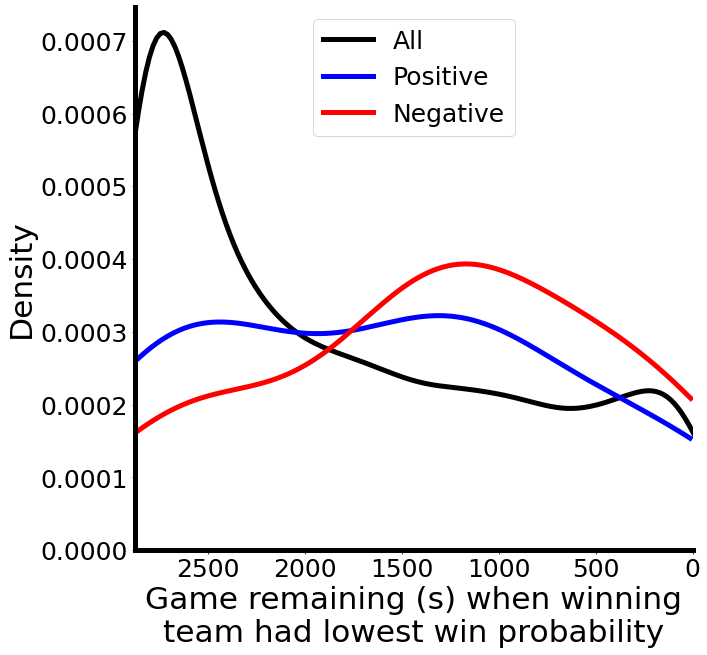

kurtosis g1: -67.683, p=0.0; kurtosis g2: -4.94, p=0.0
skewness g1: -33.386, p=0.0; kurtosis g2: -0.757, p=0.449
use mann-whitney!
game remaining, pos vs null
   meth    g1n       g1m    g1s   g1med  g2n       g2m      g2s   g2med  \
0     2  22539  1821.159  6.185  2081.0   77  1608.935  104.927  1364.0   

      df      stat  tstat      p  p_ttest      d  
0  22614  992516.5  2.002  0.029    0.045  0.229  


kurtosis g1: -67.683, p=0.0; kurtosis g2: -2.906, p=0.004
skewness g1: -33.386, p=0.0; kurtosis g2: 0.924, p=0.356
use mann-whitney!
game remaining, neg vs null
   meth    g1n       g1m    g1s   g1med  g2n       g2m     g2s   g2med     df  \
0     2  22539  1821.159  6.185  2081.0   74  1317.176  99.995  1364.0  22611   

        stat  tstat    p  p_ttest      d  
0  1099629.5  4.662  0.0      0.0  0.543  


kurtosis g1: -4.94, p=0.0; kurtosis g2: -2.906, p=0.004
skewness g1: -0.757, p=0.449; kurtosis g2: 0.924, p=0.356
use mann-whitney!
game remaining, pos vs neg
   meth  g1n   

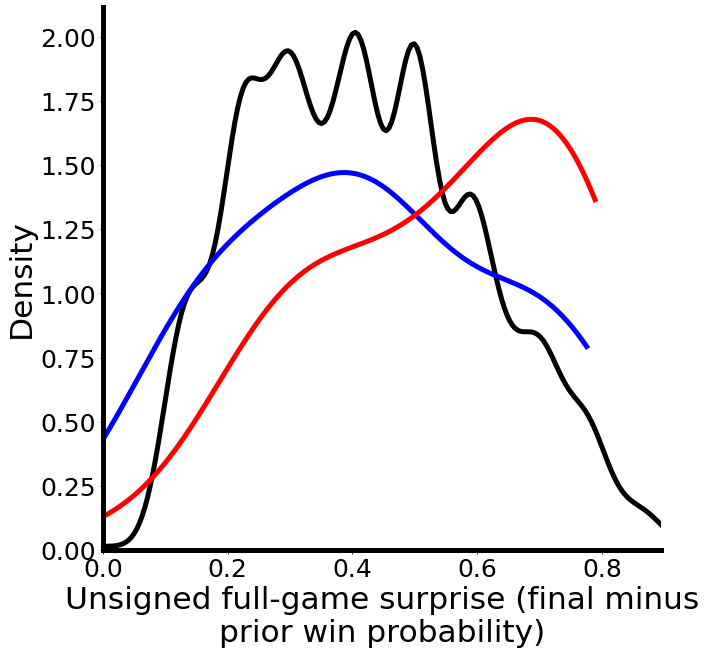

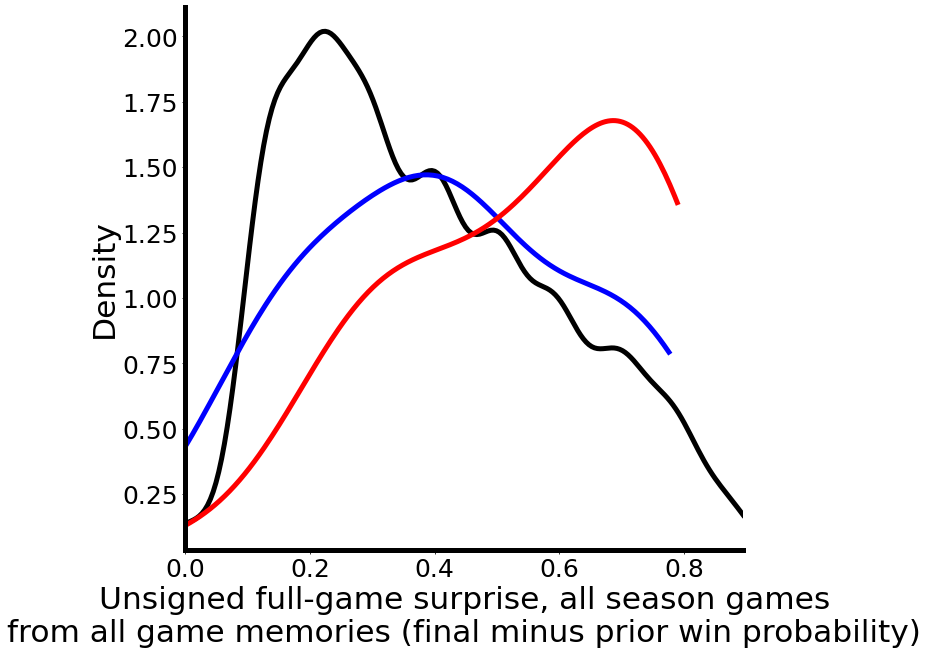

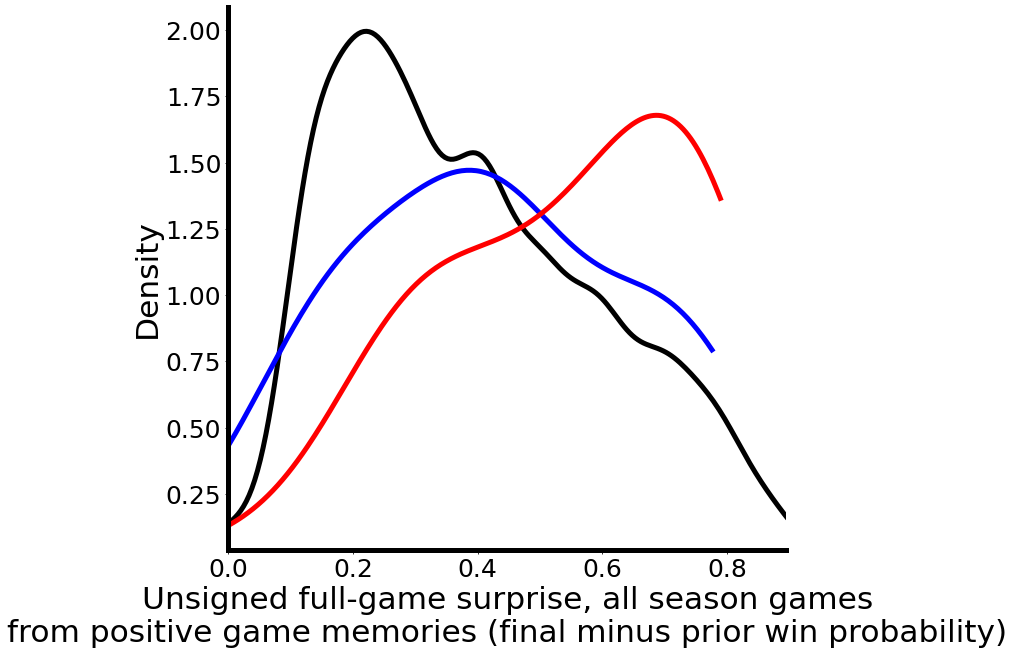

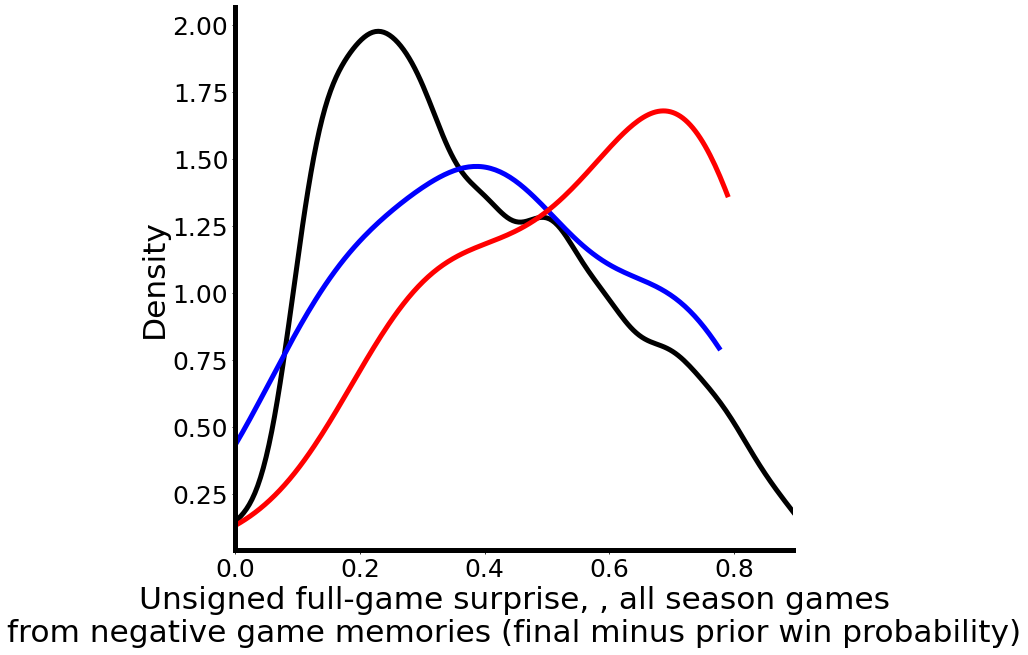

kurtosis g1: -32.311, p=0.0; kurtosis g2: -3.964, p=0.0
skewness g1: 17.739, p=0.0; kurtosis g2: 0.367, p=0.713
use mann-whitney!
full-game surprise, pos vs null
   meth    g1n    g1m    g1s    g1med  g2n    g2m    g2s     g2med     df  \
0     2  22539  0.421  0.001  0.41012   77  0.424  0.025  0.410526  22614   

       stat  tstat      p  p_ttest      d  
0  867914.0 -0.125  0.998    0.901 -0.014  


kurtosis g1: -32.311, p=0.0; kurtosis g2: -2.199, p=0.028
skewness g1: 17.739, p=0.0; kurtosis g2: -1.821, p=0.069
use mann-whitney!
full-game surprise, neg vs null
   meth    g1n    g1m    g1s    g1med  g2n    g2m    g2s    g2med     df  \
0     2  22539  0.421  0.001  0.41012   74  0.541  0.024  0.60039  22611   

       stat  tstat    p  p_ttest      d  
0  546094.0 -5.635  0.0      0.0 -0.656  


kurtosis g1: -3.964, p=0.0; kurtosis g2: -2.199, p=0.028
skewness g1: 0.367, p=0.713; kurtosis g2: -1.821, p=0.069
use mann-whitney!
full-game surprise, pos vs neg
   meth  g1n    g1m    g1

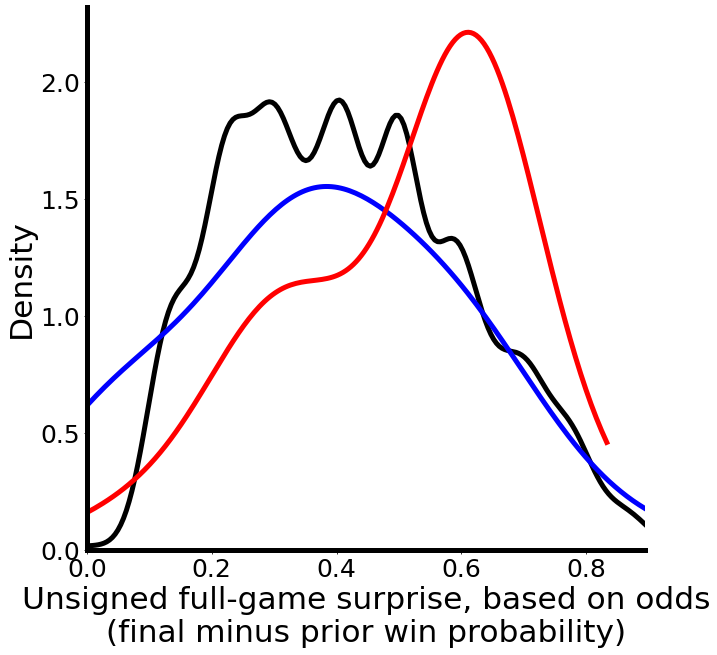

kurtosis g1: -29.769, p=0.0; kurtosis g2: -3.964, p=0.0
skewness g1: 16.592, p=0.0; kurtosis g2: 0.367, p=0.713
use mann-whitney!
full-game surprise, pos vs null, based on odds
   meth    g1n    g1m    g1s    g1med  g2n    g2m    g2s     g2med     df  \
0     2  17823  0.418  0.001  0.41012   77  0.424  0.025  0.410526  17898   

       stat  tstat      p  p_ttest      d  
0  678440.5 -0.243  0.864    0.808 -0.028  


kurtosis g1: -29.769, p=0.0; kurtosis g2: -2.199, p=0.028
skewness g1: 16.592, p=0.0; kurtosis g2: -1.821, p=0.069
use mann-whitney!
full-game surprise, neg vs null, based on odds
   meth    g1n    g1m    g1s    g1med  g2n    g2m    g2s    g2med     df  \
0     2  17823  0.418  0.001  0.41012   74  0.541  0.024  0.60039  17895   

       stat  tstat    p  p_ttest      d  
0  426974.0 -5.657  0.0      0.0 -0.659  




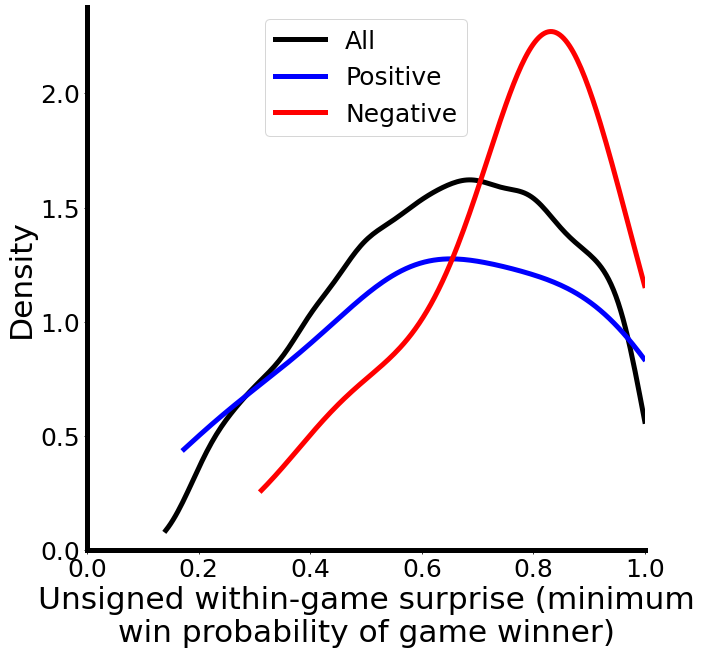

kurtosis g1: -50.885, p=0.0; kurtosis g2: -2.843, p=0.004
skewness g1: -13.595, p=0.0; kurtosis g2: -0.888, p=0.374
use mann-whitney!
unsigned within-game surprise, pos vs null
   meth    g1n    g1m    g1s     g1med  g2n    g2m    g2s     g2med     df  \
0     2  22539  0.638  0.001  0.650831   77  0.647  0.028  0.624294  22614   

       stat  tstat      p  p_ttest      d  
0  834067.0 -0.395  0.556    0.693 -0.045  


kurtosis g1: -50.885, p=0.0; kurtosis g2: 0.043, p=0.966
skewness g1: -13.595, p=0.0; kurtosis g2: -2.62, p=0.009
use mann-whitney!
unsigned within-game surprise, neg vs null
   meth    g1n    g1m    g1s     g1med  g2n    g2m   g2s     g2med     df  \
0     2  22539  0.638  0.001  0.650831   74  0.763  0.02  0.839474  22611   

       stat  tstat    p  p_ttest      d  
0  539131.0 -5.171  0.0      0.0 -0.602  


kurtosis g1: -2.843, p=0.004; kurtosis g2: 0.043, p=0.966
skewness g1: -0.888, p=0.374; kurtosis g2: -2.62, p=0.009
use mann-whitney!
unsigned within-game surpr

meth  g1n    g1m    g1s     g1med  g2n    g2m   g2s     g2med   df    stat  \
0     2   77  0.647  0.028  0.624294   74  0.763  0.02  0.839474  149  2055.0   

   tstat      p  p_ttest      d  
0 -3.326  0.003    0.001 -0.545

In [ ]:
# calculate based on fll-game surprise, not within-game
expert_algo=2 #1=use expert #s, 2=use algorithm
if expert_algo==1:
    cbsp,cbsn=dfgp['Comeback via website (if NBA/WNBA)'],dfgn['Comeback via website (if NBA/WNBA)']
    cbsp,cbsn=1-cbsp/100,1-cbsn/100 #normalize - put in same space as other data
    fgsp,fgsp=dfgp['Absolute surprise (game-level)'],dfgn['Absolute surprise (game-level)']
elif expert_algo==2:
    cbsp,cbsn=gsursp_a_abs+0,gsursn_a_abs+0
    fgsp,fgsn=dfgp['relgsur_a'],dfgn['relgsur_a']
    fgsp_odds,fgsn_odds=dfgp['relg_odds_a'],dfgn['relg_odds_a']

kdeplotf(mwwp_ts[:,0],gsursp_t_a,gsursn_t_a,'''Game remaining (s) when winning
team had lowest win probability''',[t_sec,0],
         'figs/game_comeback_times.pdf',4)

astats2(mwwp_ts[:,0],gsursp_t_a,'game remaining, pos vs null')
astats2(mwwp_ts[:,0],gsursn_t_a,'game remaining, neg vs null')
astats2(gsursp_t_a,gsursn_t_a,'game remaining, pos vs neg')

#full-game sur
kdeplotf(1-fwwps[:,0],np.absolute(fgsp),np.absolute(fgsn),'''Unsigned full-game surprise (final minus
prior win probability)''',[0,max(1-fwwps)],
         'figs/game_fullgamesurprise_abs.pdf',5)
#compare against games from just reported seasons
kdeplotf(np.absolute(fgsur_szn_games),np.absolute(fgsp),np.absolute(fgsn),'''Unsigned full-game surprise, all season games
from all game memories (final minus prior win probability)''',[0,max(1-fwwps)],
         'figs/game_fullgamesurprise_abs_chosengames.pdf',5)
kdeplotf(np.absolute(fgsur_szn_gamesp),np.absolute(fgsp),np.absolute(fgsn),'''Unsigned full-game surprise, all season games
from positive game memories (final minus prior win probability)''',[0,max(1-fwwps)],
         'figs/game_fullgamesurprise_abs_chosenpgames.pdf',5)
kdeplotf(np.absolute(fgsur_szn_gamesn),np.absolute(fgsp),np.absolute(fgsn),'''Unsigned full-game surprise, , all season games
from negative game memories (final minus prior win probability)''',[0,max(1-fwwps)],
         'figs/game_fullgamesurprise_abs_chosenngames.pdf',5)

# do statistics
astats2(1-fwwps[:,0],np.absolute(fgsp),'full-game surprise, pos vs null')
astats2(1-fwwps[:,0],np.absolute(fgsn),'full-game surprise, neg vs null')
astats2(np.absolute(fgsp),np.absolute(fgsn),'full-game surprise, pos vs neg')
astats2(np.absolute(fgsur_szn_games),np.absolute(fgsp),'full-game surprise, pos vs null, all games from chosen seasons')
astats2(np.absolute(fgsur_szn_games),np.absolute(fgsn),'full-game surprise, neg vs null, all games from chosen seasons')
astats2(np.absolute(fgsur_szn_gamesp),np.absolute(fgsp),'full-game surprise, pos vs null, all games from chosen pseasons')
astats2(np.absolute(fgsur_szn_gamesn),np.absolute(fgsn),'full-game surprise, neg vs null, all games from chosen nseasons')

#re-run with Vegas odds for reviewer
kdeplotf(1-fwwps_o[:,0],np.absolute(fgsp_odds),np.absolute(fgsn_odds),'''Unsigned full-game surprise, based on odds
(final minus prior win probability)''',[0,max(1-fwwps)],
         'figs/game_fullgamesurprise_abs.pdf',5)

astats2(1-fwwps_o[:,0],np.absolute(fgsp),'full-game surprise, pos vs null, based on odds')
astats2(1-fwwps_o[:,0],np.absolute(fgsn),'full-game surprise, neg vs null, based on odds')

#within-game sur
kdeplotf(1-mwwps[:,0],1-cbsp,1-cbsn,'''Unsigned within-game surprise (minimum
win probability of game winner)''',[0,1],
         'figs/game_comeback_abs.pdf',4)

astats2(1-mwwps[:,0],1-cbsp,'unsigned within-game surprise, pos vs null')
astats2(1-mwwps[:,0],1-cbsn,'unsigned within-game surprise, neg vs null')
astats2(1-cbsp,1-cbsn,'unsigned within-game surprise, pos vs neg')

In [ ]:
#plot histogram of resampled statistical results
def adj_histo(dat,lim,col,yls,sn):
    f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
    histo=plt.hist(dat,linewidth=lw/2,color=col,ec='black')
    yl=yls+', t-stat'
    if lim==1: # pearsonr
        yl=yls+', pearson r'
    elif lim==0.1: # pearsonr
        yl=yls+', pval'
    ax.set_ylabel('Count',fontsize=fs*4/5)
    ax.set_xlabel(yl,fontsize=fs*4/5)
    ax.set_xlim(-lim,lim)
    plt.vlines(np.mean(dat),0,np.max(histo[0]),linewidth=lw,colors='k',linestyles='dotted')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(lw)
    f.tight_layout()
    f.savefig(sn, transparent=True)

32
0.43243243243243246
74
kurtosis g1: -32.311, p=0.0; kurtosis g2: -1.449, p=0.147
skewness g1: 17.739, p=0.0; kurtosis g2: -0.607, p=0.544
use mann-whitney!
full-game surprise, neg vs null
   meth    g1n    g1m    g1s    g1med  g2n   g2m    g2s     g2med     df  \
0     2  22539  0.421  0.001  0.41012   51  0.48  0.027  0.499582  22588   

       stat  tstat      p  p_ttest      d  
0  470082.0 -2.296  0.024    0.022 -0.322  


kurtosis g1: -50.885, p=0.0; kurtosis g2: -1.923, p=0.054
skewness g1: -13.595, p=0.0; kurtosis g2: -1.263, p=0.207
use mann-whitney!
within-game surprise, neg vs null
   meth    g1n    g1m    g1s     g1med  g2n    g2m    g2s     g2med     df  \
0     2  22539  0.638  0.001  0.650831   51  0.745  0.027  0.770833  22588   

       stat  tstat    p  p_ttest      d  
0  406870.5 -3.665  0.0      0.0 -0.514  


kurtosis g1: -32.311, p=0.0; kurtosis g2: -1.838, p=0.066
skewness g1: 17.739, p=0.0; kurtosis g2: -0.511, p=0.609
use mann-whitney!
full-game surprise, ne

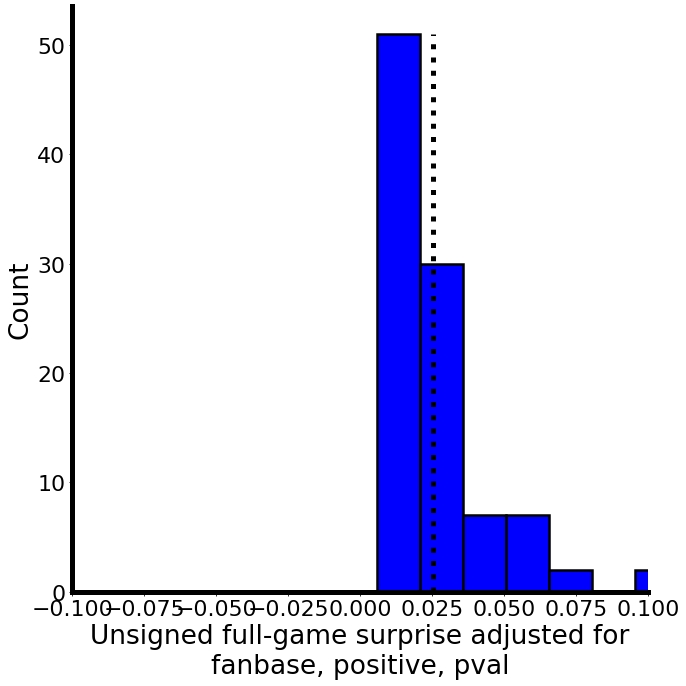

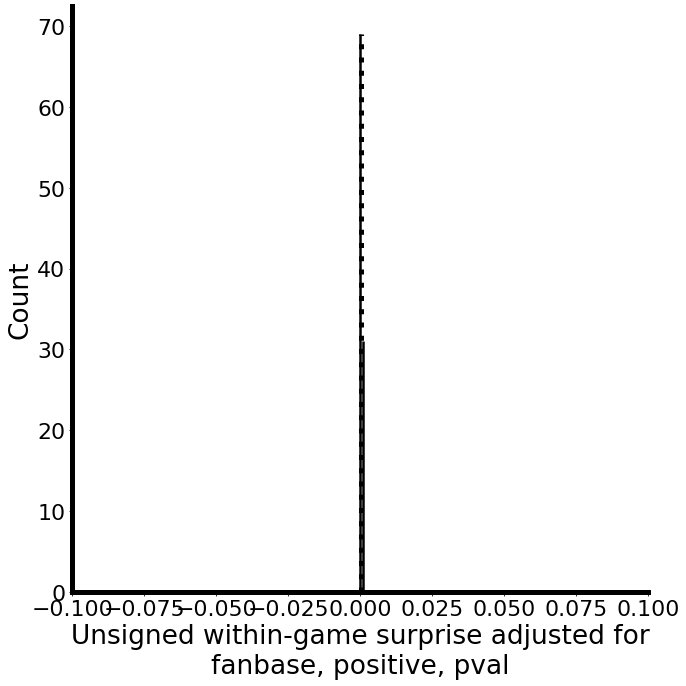

In [ ]:
#check results if GSW fandom is aligned with its base rate in US (~17%), 
#per https://www.stadium-maps.com/facts/nba-teams-popularity.html 
gswi,nk=9,9 # Warriors team ID, number to keep
gsw_gn=t_i_gn==gswi
ngsw_gn=t_i_gn!=gswi
print(np.sum(gsw_gn))
print(np.sum(gsw_gn)/len(gsw_gn))
print(len(gsw_gn)) #add 9 gsw
n_iters=100
adj_pvals_fgn_gsw,adj_pvals_wgn_gsw=np.zeros((n_iters)),np.zeros((n_iters))
gsw_ind=np.where(gsw_gn==1)[0]
for i in range(n_iters):
    ngsw_gn2=ngsw_gn+0
    q0=np.random.permutation(gsw_ind)
    qvec=q0[:nk]
    for ii in range(nk):
        ngsw_gn2[qvec[ii]]=True
    outp=astats2(1-fwwps[:,0],np.absolute(fgsn[ngsw_gn2==1]),'full-game surprise, neg vs null')
    adj_pvals_fgn_gsw[i]=outp.p
    outp=astats2(1-mwwps[:,0],1-cbsn[ngsw_gn2==1],'within-game surprise, neg vs null')
    adj_pvals_wgn_gsw[i]=outp.p

qq=adj_pvals_fgn_gsw<0.05
print('neg, adj for fanbase, nsig:%s' %(np.sum(qq)/len(adj_pvals_fgn_gsw)))
qq=adj_pvals_wgn_gsw<0.05
print('neg, adj for fanbase, nsig:%s' %(np.sum(qq)/len(adj_pvals_wgn_gsw)))

adj_histo(adj_pvals_fgn_gsw,0.1,'b','''Unsigned full-game surprise adjusted for
fanbase, positive''','figs/game_adj_histo_fullgamesurprise_neg_fans.pdf')

adj_histo(adj_pvals_wgn_gsw,0.1,'b','''Unsigned within-game surprise adjusted for
fanbase, positive''','figs/game_adj_histo_withingamesurprise_neg_fans.pdf')

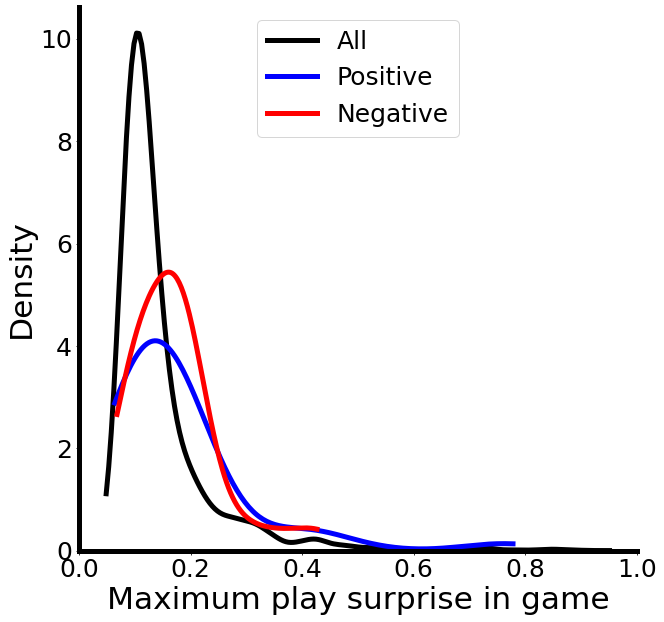

kurtosis g1: 71.326, p=0.0; kurtosis g2: 4.986, p=0.0
skewness g1: 107.655, p=0.0; kurtosis g2: 6.632, p=0.0
use mann-whitney!
max play sur, pos vs null
   meth    g1n    g1m    g1s     g1med  g2n    g2m    g2s     g2med     df  \
0     2  22539  0.146  0.001  0.117841   77  0.178  0.015  0.133898  22614   

       stat  tstat      p  p_ttest      d  
0  692714.5 -3.008  0.002    0.003 -0.343  


kurtosis g1: 71.326, p=0.0; kurtosis g2: 3.172, p=0.002
skewness g1: 107.655, p=0.0; kurtosis g2: 4.667, p=0.0
use mann-whitney!
max play sur, neg vs null
   meth    g1n    g1m    g1s     g1med  g2n    g2m    g2s     g2med     df  \
0     2  22539  0.146  0.001  0.117841   74  0.171  0.009  0.178961  22611   

       stat  tstat    p  p_ttest      d  
0  585431.0 -2.331  0.0     0.02 -0.271  


kurtosis g1: 4.986, p=0.0; kurtosis g2: 3.172, p=0.002
skewness g1: 6.632, p=0.0; kurtosis g2: 4.667, p=0.0
use mann-whitney!
max play sur, pos vs neg
   meth  g1n    g1m    g1s     g1med  g2n    g2m   

meth  g1n    g1m    g1s     g1med  g2n    g2m    g2s     g2med   df  \
0     2   77  0.178  0.015  0.133898   74  0.171  0.009  0.178961  149   

     stat  tstat      p  p_ttest      d  
0  2660.0  0.387  0.482    0.699  0.063

In [ ]:
#max surprise play - higher in chosen games - must adjust by resampling below
kdeplotf(maxsurs[:,0],gmaxsursp_a,gmaxsursn_a,'Maximum play surprise in game',[0,1],
         'figs/game_max_play_sur_pn.pdf',4)

astats2(maxsurs[:,0],gmaxsursp_a,'max play sur, pos vs null')
astats2(maxsurs[:,0],gmaxsursn_a,'max play sur, neg vs null')
astats2(gmaxsursp_a,gmaxsursn_a,'max play sur, pos vs neg')

In [ ]:
#control analyses - resample w/ replacement
fgsp,fgsn=fgsp.values,fgsn.values
iters,n_iters=0,100
adj_tstats_wgp,adj_pvals_wgp=np.zeros((n_iters)),np.zeros((n_iters))
adj_tstats_fgp,adj_pvals_fgp=np.zeros((n_iters)),np.zeros((n_iters))
adj_tstats_wgn,adj_pvals_wgn=np.zeros((n_iters)),np.zeros((n_iters))
adj_tstats_fgn,adj_pvals_fgn=np.zeros((n_iters)),np.zeros((n_iters))
cumu_p,cumu_n,cumu_wgp,cumu_wgn,cumu_fgp,cumu_fgn=[],[],[],[],[],[] #cumulative distributions
while iters<n_iters:
    # positive
    nv=gmaxsursp_a.shape[0]
    q0=np.random.choice(nv,nv)
    qval=gmaxsursp_a[q0]
    stat,pval=ttest_ind(maxsurs[:,0],qval,nan_policy='omit')
    if pval>0.1:
        cumu_p=np.hstack([cumu_p,qval])
        stat,pval=ttest_ind(mwwps,cbsp[q0],nan_policy='omit')
        adj_tstats_wgp[iters]=stat
        adj_pvals_wgp[iters]=pval
        cumu_wgp=np.hstack([cumu_wgp,cbsp[q0]])
        stat,pval=ttest_ind(1-fwwps,np.absolute(fgsp[q0]),nan_policy='omit')
        adj_tstats_fgp[iters]=stat
        adj_pvals_fgp[iters]=pval
        cumu_fgp=np.hstack([cumu_fgp,np.absolute(fgsp[q0])])
        iters+=1

iters=0
while iters<n_iters:
    # negative
    nv=gmaxsursn_a.shape[0]
    q1=np.random.choice(nv,nv)
    qval=gmaxsursn_a[q1]
    stat,pval=ttest_ind(maxsurs[:,0],qval,nan_policy='omit')
    if pval>0.1:
        cumu_n=np.hstack([cumu_n,qval])
        stat,pval=ttest_ind(mwwps,cbsn[q1],nan_policy='omit')
        adj_tstats_wgn[iters]=stat
        adj_pvals_wgn[iters]=pval
        cumu_wgn=np.hstack([cumu_wgn,cbsn[q1]])
        stat,pval=ttest_ind(1-fwwps,np.absolute(fgsn[q1]),nan_policy='omit')
        adj_tstats_fgn[iters]=stat
        adj_pvals_fgn[iters]=pval
        cumu_fgn=np.hstack([cumu_fgn,np.absolute(fgsn[q1])])
        iters+=1

pos, adj for fg, nsig:0.07
neg, adj for fg, nsig:1.0
pos, adj for wg, nsig:0.03
neg, adj for wg, nsig:1.0


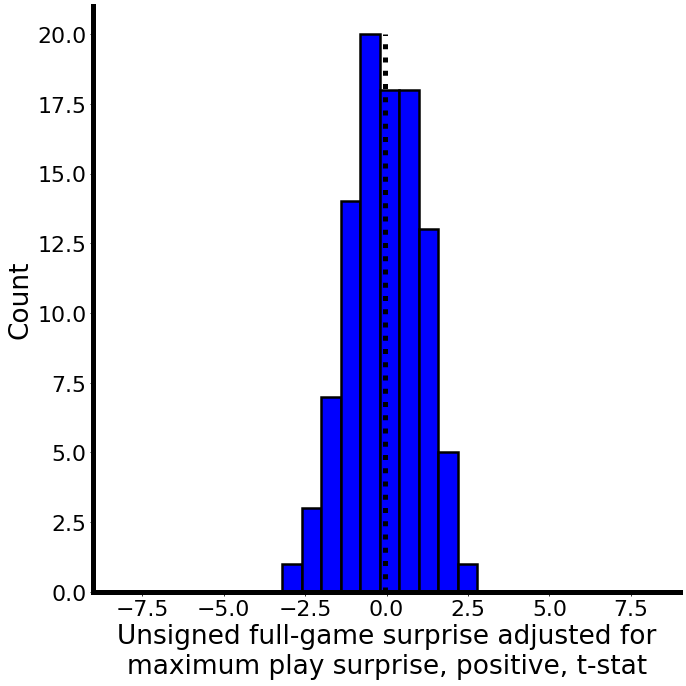

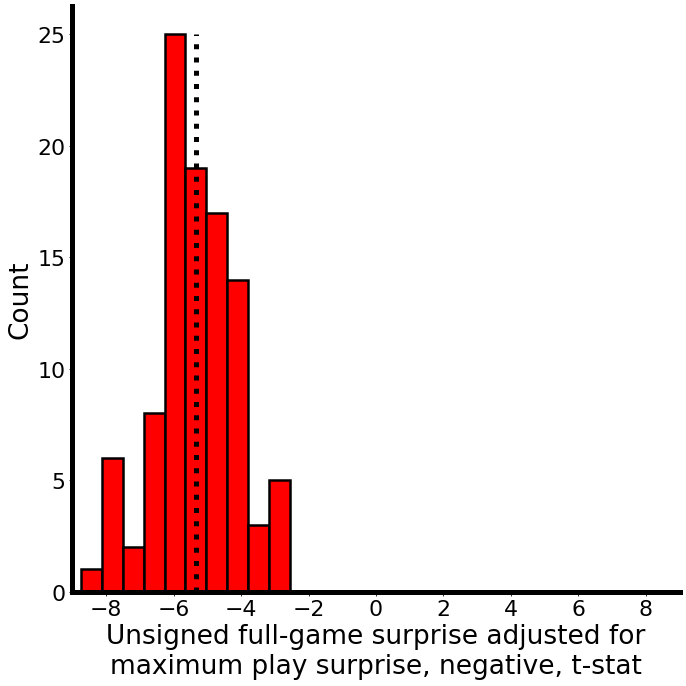

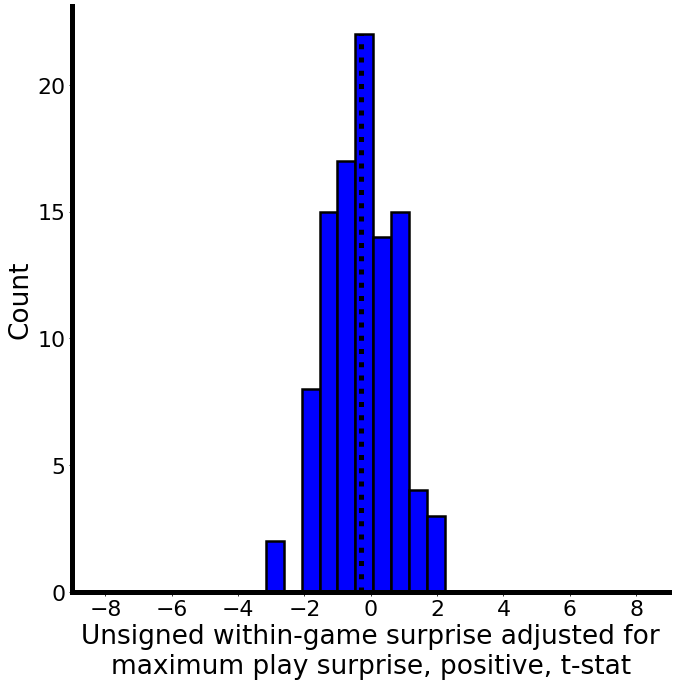

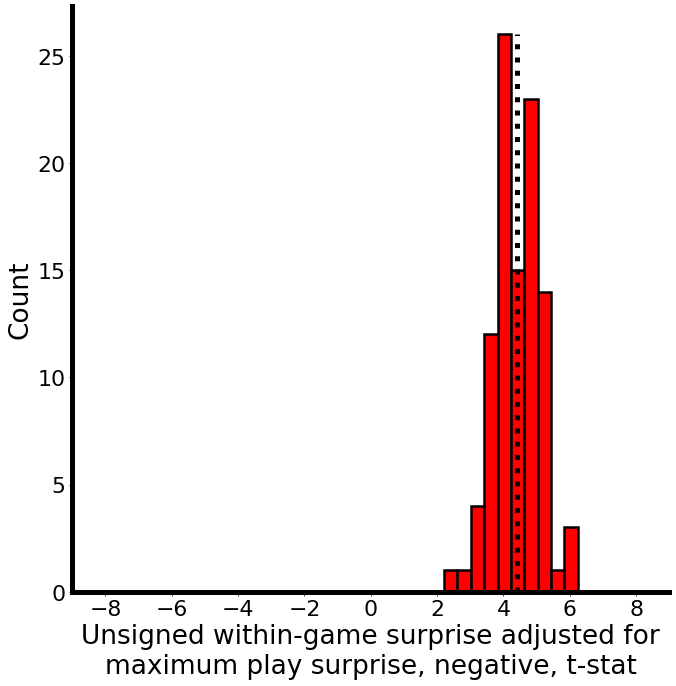

In [ ]:
# plot re-sampled results
qq=adj_pvals_fgp<0.05
print('pos, adj for fg, nsig:%s' %(np.sum(qq)/len(adj_pvals_fgp)))
qq=adj_pvals_fgn<0.05
print('neg, adj for fg, nsig:%s' %(np.sum(qq)/len(adj_pvals_fgn)))
qq=adj_pvals_wgp<0.05
print('pos, adj for wg, nsig:%s' %(np.sum(qq)/len(adj_pvals_wgp)))
qq=adj_pvals_wgn<0.05
print('neg, adj for wg, nsig:%s' %(np.sum(qq)/len(adj_pvals_wgn)))
    
adj_histo(adj_tstats_fgp,9,'b','''Unsigned full-game surprise adjusted for
maximum play surprise, positive''','figs/game_adj_histo_fullgamesurprise_pos.pdf')
adj_histo(adj_tstats_fgn,9,'r','''Unsigned full-game surprise adjusted for
maximum play surprise, negative''','figs/game_adj_histo_fullgamesurprise_neg.pdf')
adj_histo(adj_tstats_wgp,9,'b','''Unsigned within-game surprise adjusted for
maximum play surprise, positive''','figs/game_adj_histo_comeback_pos.pdf')
adj_histo(adj_tstats_wgn,9,'r','''Unsigned within-game surprise adjusted for
maximum play surprise, negative''','figs/game_adj_histo_comeback_neg.pdf')

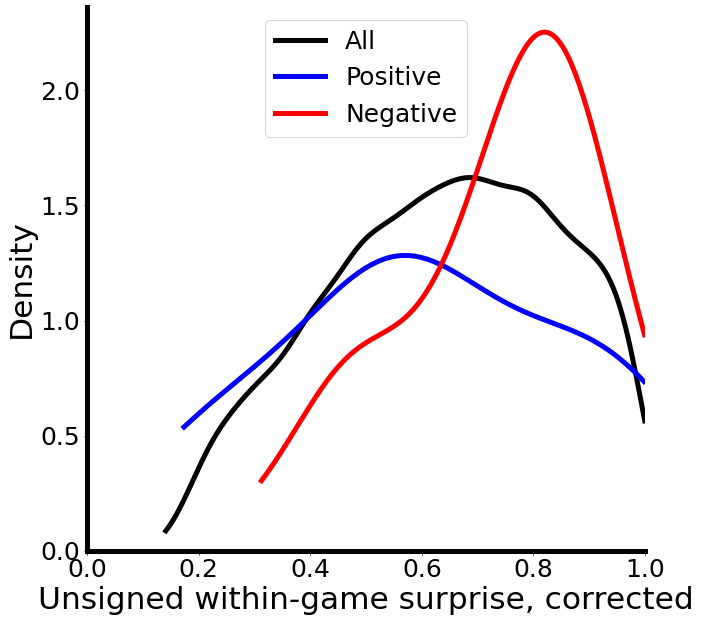

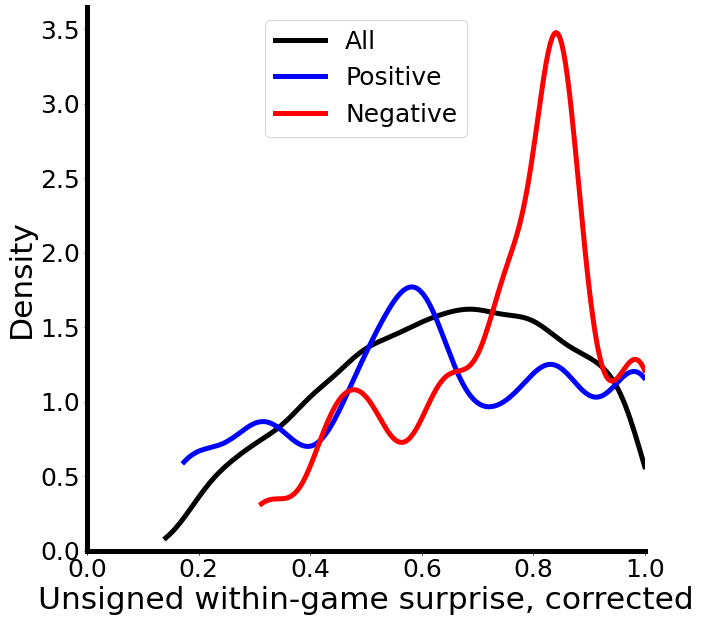

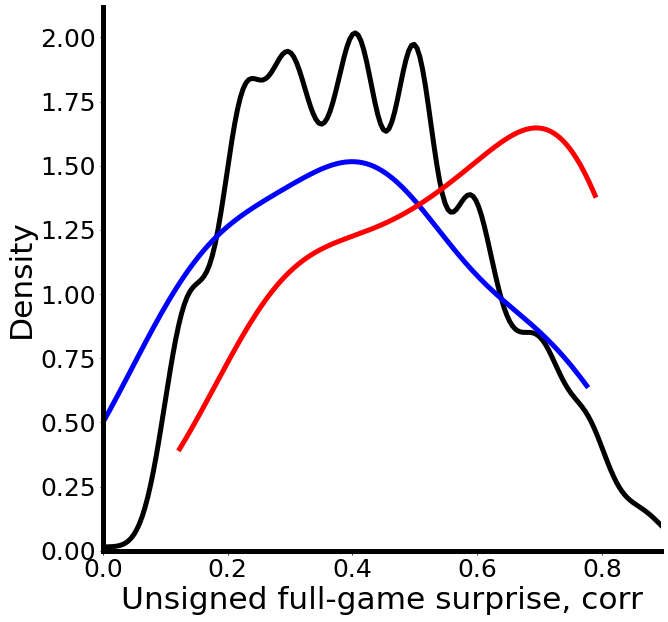

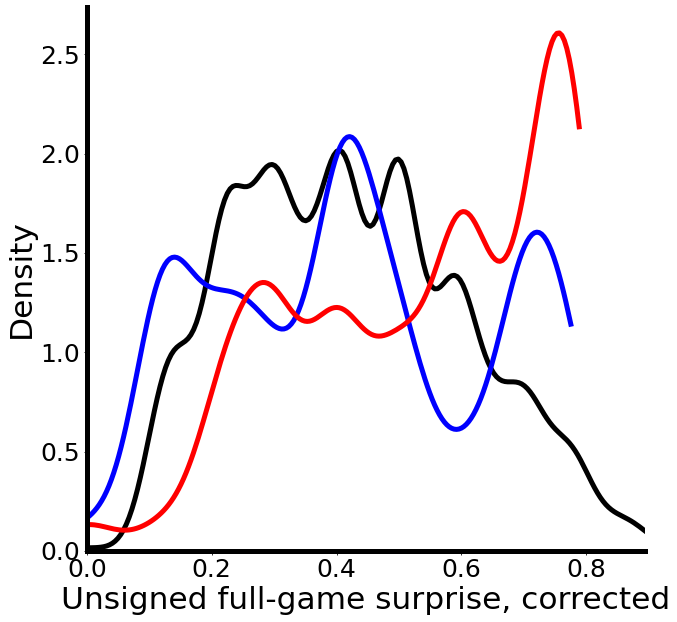

In [ ]:
#look for mwwp contrasts with only these values!
kdeplotf(1-mwwps[:,0],1-cbsp[q0],1-cbsn[q1],'''Unsigned within-game surprise, corrected''',[0,1],
         'figs/game_comeback_abs_adj_example.pdf',4) #solo example
kdeplotf(1-mwwps[:,0],1-cumu_wgp,1-cumu_wgn,'''Unsigned within-game surprise, corrected''',[0,1],
         'figs/game_comeback_abs_adj.pdf',4) #cumulative
kdeplotf(1-fwwps[:,0],np.absolute(fgsp[q0]),np.absolute(fgsn[q1]),
         '''Unsigned full-game surprise, corr''',[0,max(1-fwwps)],
         'figs/game_fullgamesurprise_abs_adj_example.pdf',5)
kdeplotf(1-fwwps[:,0],cumu_fgp,cumu_fgn,
         '''Unsigned full-game surprise, corrected''',[0,max(1-fwwps)],
         'figs/game_fullgamesurprise_abs_adj.pdf',5)

<ipython-input-48-5e5baac96379>:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elatdepp=np.array(elatdepp, dtype=[('O', np.float)]).astype(np.float) #fix odd data issue


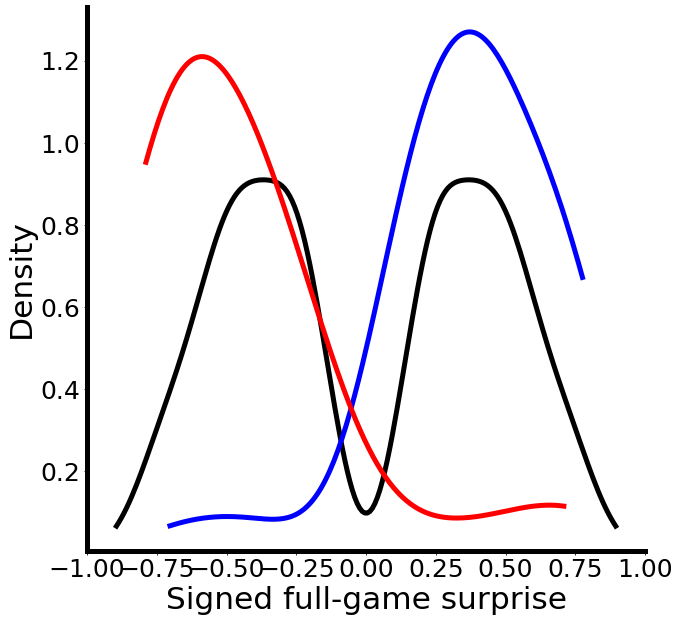

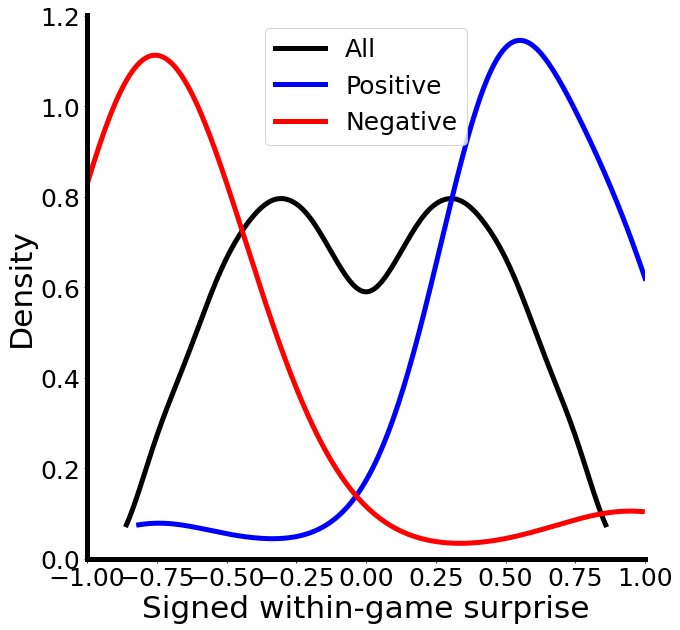

kurtosis g1: 771.101, p=0.0; kurtosis g2: 2.836, p=0.005
skewness g1: 1.0, p=0.317; kurtosis g2: -3.789, p=0.0
use mann-whitney!
signed full-game sur, pos vs null
   meth    g1n  g1m    g1s  g1med  g2n   g2m    g2s     g2med     df  \
0     2  45078 -0.0  0.002    0.0   77  0.37  0.034  0.410526  45153   

       stat  tstat    p  p_ttest      d  
0  988415.0 -7.066  0.0      0.0 -0.806  


kurtosis g1: 771.101, p=0.0; kurtosis g2: 3.252, p=0.001
skewness g1: 1.0, p=0.317; kurtosis g2: 5.022, p=0.0
use mann-whitney!
signed full-game sur, neg vs null
   meth    g1n  g1m    g1s  g1med  g2n    g2m    g2s     g2med     df  \
0     2  45078 -0.0  0.002    0.0   74 -0.446  0.043 -0.542763  45150   

        stat  tstat    p  p_ttest      d  
0  2590601.0  8.349  0.0      0.0  0.971  


kurtosis g1: 2.836, p=0.005; kurtosis g2: 3.252, p=0.001
skewness g1: -3.789, p=0.0; kurtosis g2: 5.022, p=0.0
use mann-whitney!
signed full-game sur, pos vs neg
   meth  g1n   g1m    g1s     g1med  g2n    g2m

meth  g1n    g1m    g1s  g1med  g2n    g2m    g2s  g2med   df    stat  \
0     2   77  0.551  0.043  0.551   74 -0.591  0.056 -0.742  149  5188.0   

    tstat    p  p_ttest      d  
0  16.142  0.0      0.0  2.645

In [ ]:
# signed surprise

#max-min home
winnerp0=dfgp['Home WP after game (0/100)']
winnerp=winnerp0+0
winnerp[winnerp0==100]=1
winnerp[winnerp0==0]=-1
winnern0=dfgn['Home WP after game (0/100)']
winnern=winnern0+0
winnern[winnern0==100]=1
winnern[winnern0==0]=-1

maxminhomep=dfgp['Max Home WP within game (_ or 100)']-dfgp['Min Home WP (_ or 0)']
elatdepp=np.multiply(np.multiply(np.multiply(maxminhomep,dfgp['Cheering for? (1=H,-1=V)']),
                     winnerp),0.01)
maxminhomen=dfgn['Max Home WP within game (_ or 100)']-dfgn['Min Home WP (_ or 0)']
elatdepn=np.multiply(np.multiply(np.multiply(maxminhomen,dfgn['Cheering for? (1=H,-1=V)']),
                                 winnern),0.01)
elatdepp=elatdepp.values
elatdepp=np.array(elatdepp, dtype=[('O', np.float)]).astype(np.float) #fix odd data issue
elatdepn=elatdepn.values

#for all games dist, imagine that each team is cheered for in each game exactly once
#for full-game surprise
rel_fwwps=np.hstack([1-fwwps[:,0],-(1-fwwps[:,0])])
kdeplotf(rel_fwwps,dfgp['relgsur_a'],dfgn['relgsur_a'],'Signed full-game surprise',[-1,1],'figs/game_fullgame_valence.pdf',5)

#within-game surprise
rel_mwwps=np.hstack([mwwps[:,0],-mwwps[:,0]])
kdeplotf(rel_mwwps,elatdepp,elatdepn,'Signed within-game surprise',[-1,1],'figs/game_comeback_valence.pdf',4)

astats2(rel_fwwps,dfgp['relgsur_a'],'signed full-game sur, pos vs null')
astats2(rel_fwwps,dfgn['relgsur_a'],'signed full-game sur, neg vs null')
astats2(dfgp['relgsur_a'],dfgn['relgsur_a'],'signed full-game sur, pos vs neg')

astats2(rel_mwwps,elatdepp,'signed within-game sur, pos vs null')
astats2(rel_mwwps,elatdepn,'signed within-game sur, neg vs null')
astats2(elatdepp,elatdepn,'signed within-game sur, pos vs neg')

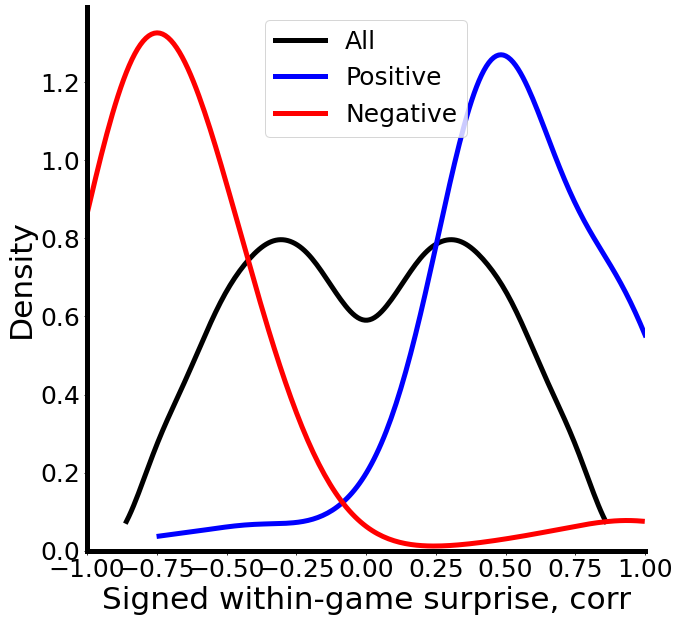

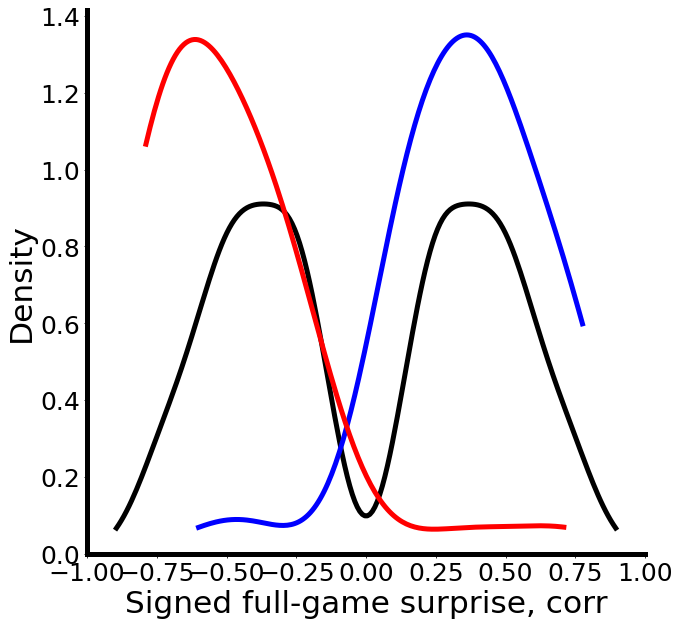

In [ ]:
#not using but fyi - same measurements based on resampling
#within-game
kdeplotf(rel_mwwps,elatdepp[q0],elatdepn[q1],'Signed within-game surprise, corr',[-1,1],'figs/game_comeback_valence_adj.pdf',4)
#full-game
ptemp,ntemp=dfgp['relgsur_a'].values,dfgn['relgsur_a'].values
kdeplotf(rel_fwwps,ptemp[q0],ntemp[q1],'Signed full-game surprise, corr',[-1,1],'figs/game_comeback_valence_adj.pdf',5)

game spectacularity, pos vs neg
   g1n    g1m    g1s  g1med  g2n    g2m    g2s  g2med   df   stat  tstat    p  \
0   61  2.836  0.127    3.0   74  1.919  0.078    2.0  133  0.361  6.313  0.0   

   p_ttest    d  
0      0.0  1.1  


r-squared,fgsur,positive = 0.00014389158095890443, pval = 0.9268944669592821
r-squared,fgsur,negative = 0.07182087369056464, pval = 0.02096986159403054
r-squared,fgsur,positive,unsigned = 0.0041286348402209535, pval = 0.6227404293584599
r-squared,fgsur,negative,unsigned = 0.017717749627072267, pval = 0.2582301469592593
r-squared,wgsur,positive = 0.00259564485721254, pval = 0.6965854051158241
r-squared,wgsur,negative = 0.02831634189840167, pval = 0.15181478681594676
r-squared,wgsur,positive,unsigned = 0.011059834516890294, pval = 0.41988620945699995
r-squared,wgsur,negative,unsigned = 0.2474347559658588, pval = 6.520503122703447e-06
time affected, pos vs neg
   g1n    g1m    g1s  g1med  g2n    g2m    g2s  g2med   df   stat  tstat  \
0   77  3.481  0.134    3

(0.4873007667293445,
 3.300413169963471,
 0.061909520316595655,
 3.3248806746603004)

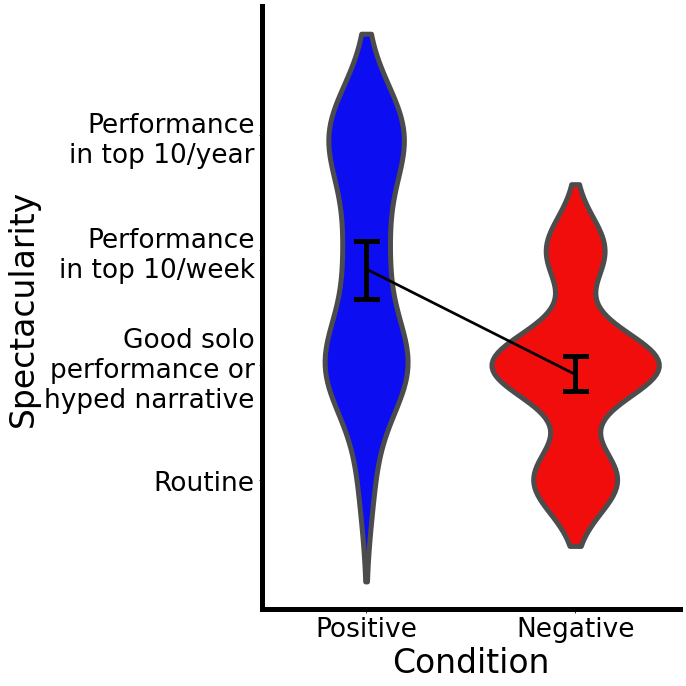

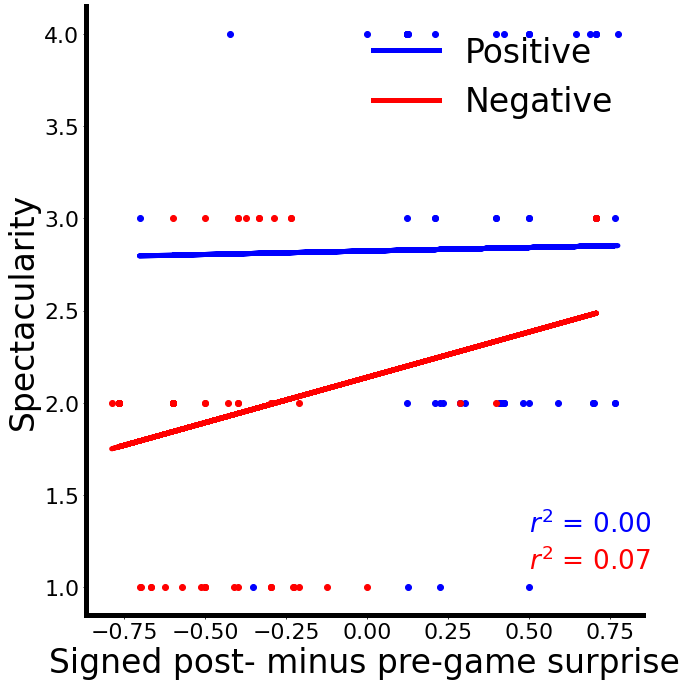

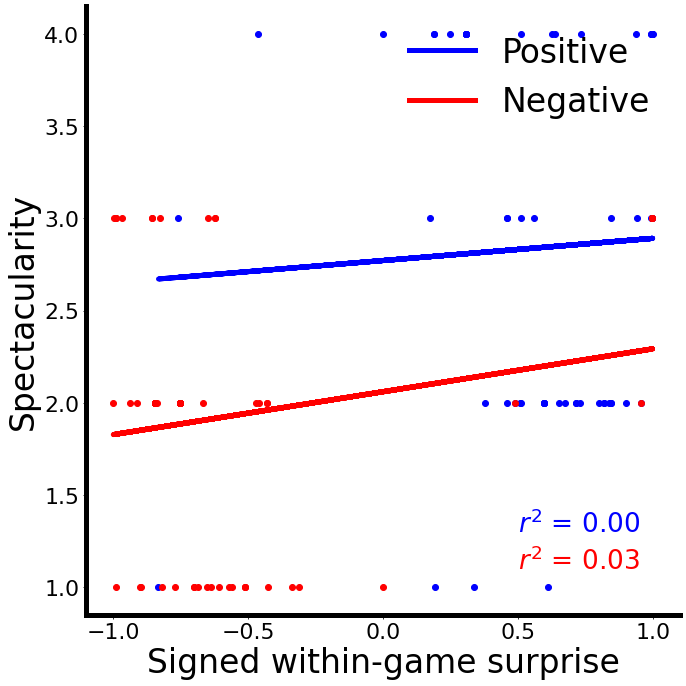

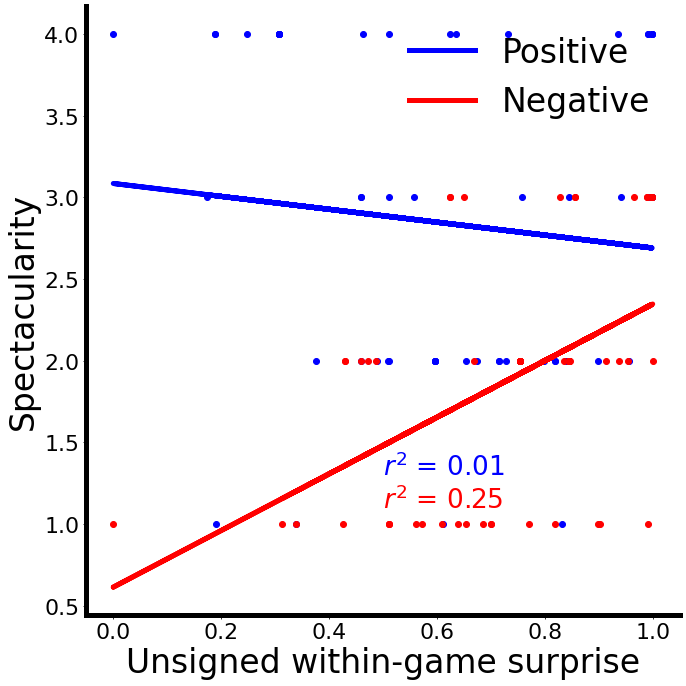

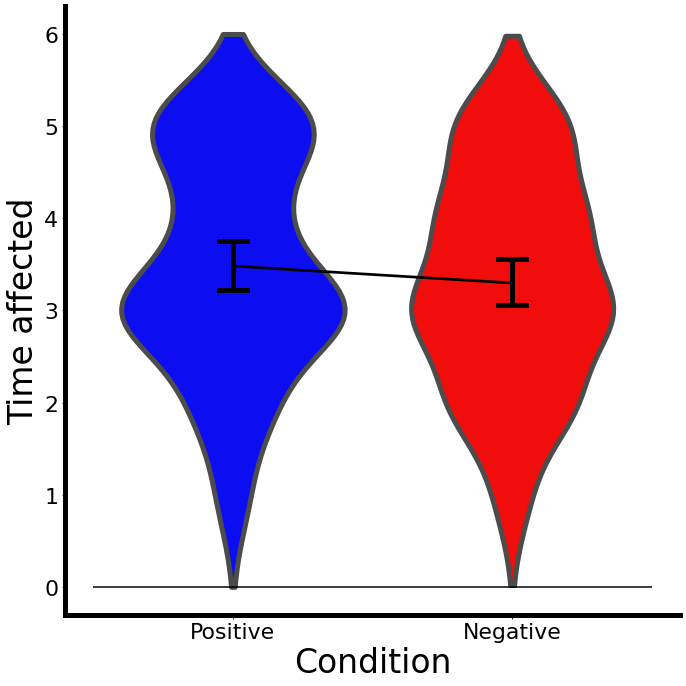

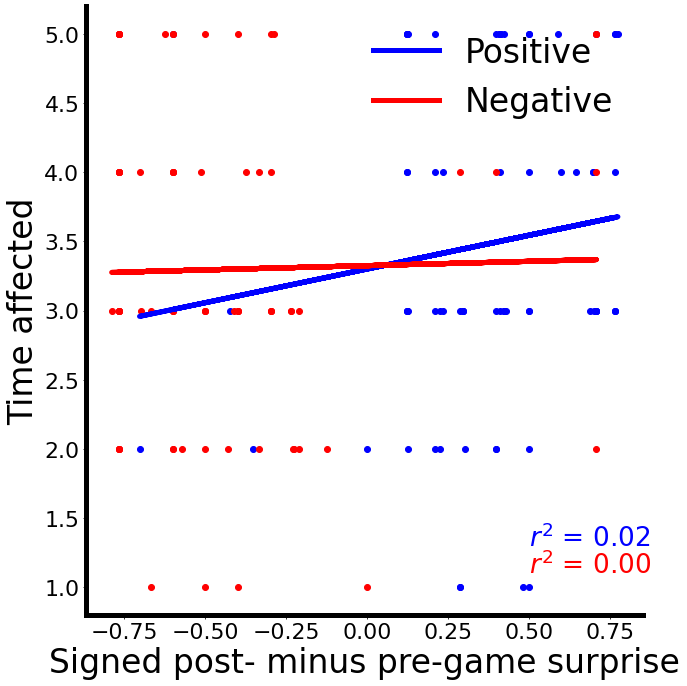

In [ ]:
##spectacularity
#full-game
ystr1,ybr1='relgsur_a','Signed post- minus pre-game surprise'
ystr2,ybr2='Spectacularity of game?','Spectacularity'
qp=np.where(dfgp[ystr2].isna()==0)[0]
qn=np.where(dfgn[ystr2].isna()==0)[0]
x1,x2=dfgp[ystr1].values,dfgn[ystr1].values
y1,y2=dfgp[ystr2].values,dfgn[ystr2].values

fn='figs/game_'+str(ystr2)+'.pdf'
barswarm(y1[qp],y2[qn],ybr2,ybr2,fn,2)

astats3(y1[qp],y2[qn],'game spectacularity, pos vs neg')

corr, pval = pearsonr(x1[qp],y1[qp])
print('r-squared,fgsur,positive = %s, pval = %s' %(corr**2,pval))
corr, pval = pearsonr(x2[qn],y2[qn])
print('r-squared,fgsur,negative = %s, pval = %s' %(corr**2,pval))
corr, pval = pearsonr(np.absolute(x1[qp]),y1[qp])
print('r-squared,fgsur,positive,unsigned = %s, pval = %s' %(corr**2,pval))
corr, pval = pearsonr(np.absolute(x2[qn]),y2[qn])
print('r-squared,fgsur,negative,unsigned = %s, pval = %s' %(corr**2,pval))

scatterp(x1[qp],y1[qp],x2[qn],y2[qn],ybr1,ybr2,'figs/game_'+str(ystr1)+'_'+str(ystr2)+'.pdf',1)

#within-game
ystr1,ybr1='relcbsur_a','Signed within-game surprise'
x1,x2=dfgp[ystr1].values,dfgn[ystr1].values

corr, pval = pearsonr(x1[qp],y1[qp])
print('r-squared,wgsur,positive = %s, pval = %s' %(corr**2,pval))
corr, pval = pearsonr(x2[qn],y2[qn])
print('r-squared,wgsur,negative = %s, pval = %s' %(corr**2,pval))
corr, pval = pearsonr(np.absolute(x1[qp]),y1[qp])
print('r-squared,wgsur,positive,unsigned = %s, pval = %s' %(corr**2,pval))
corr, pval = pearsonr(np.absolute(x2[qn]),y2[qn])
print('r-squared,wgsur,negative,unsigned = %s, pval = %s' %(corr**2,pval))

scatterp(x1[qp],y1[qp],x2[qn],y2[qn],ybr1,ybr2,'figs/game_'+str(ystr1)+'_'+str(ystr2)+'.pdf',1)
ybr1='Unsigned within-game surprise'
scatterp(np.absolute(x1[qp]),y1[qp],np.absolute(x2[qn]),y2[qn],ybr1,ybr2,'figs/game_'+str(ystr1)+'_'+str(ystr2)+'.pdf',1)

##time affected
ystr1,ybr1='relgsur_a','Signed post- minus pre-game surprise'
ystr2,ybr2='How long affected? (1=minutes,2=hours,3=days,4=months,5=still affected)','Time affected'
qp=np.where(dfgp[ystr2].isna()==0)[0]
qn=np.where(dfgn[ystr2].isna()==0)[0]
x1,x2=dfgp[ystr1].values,dfgn[ystr1].values
y1,y2=dfgp[ystr2].values,dfgn[ystr2].values

fn='figs/game_'+str(ybr2)+'.pdf'
barswarm(y1[qp],y2[qn],ybr2,ybr2,fn,0)

astats3(y1[qp],y2[qn],'time affected, pos vs neg')

corr, pval = pearsonr(x1[qp],y1[qp])
print('r-squared,positive = %s, pval = %s' %(corr**2,pval))
corr, pval = pearsonr(x2[qn],y2[qn])
print('r-squared,negative = %s, pval = %s' %(corr**2,pval))

scatterp(x1[qp],y1[qp],x2[qn],y2[qn],ybr1,ybr2,'figs/game_'+str(ystr1)+'_'+str(ystr2)+'.pdf',1)

[0.69902913 0.47130647 0.47130647 0.99690402 0.84347826 0.84347826
 0.42491657 0.64966741 0.95398773 0.84347826 0.84347826 0.83547009
 0.99019608 0.99690402 0.84347826 0.75247525 0.84347826 0.84347826
 0.51046025 0.75247525 0.75247525 0.84347826 0.64966741 0.75247525
 0.48645161 0.75247525 0.84347826 0.64966741 0.75247525 0.84347826
 0.84347826 0.99019608 0.84347826 0.75247525 0.69902913 0.84347826
 0.84347826 0.84347826 0.75247525 0.84347826 0.42840779 0.75247525
 0.62429379 0.84347826 0.99908925 0.99690402 0.75247525 0.84347826
 0.66802444]
[0.6804878  0.81637168 0.89147982 ... 0.90952381 0.79310345 0.77108434]
[ 0.12681193  0.12245225  0.12626618  0.18542161  0.12280333  0.11547666
  0.04350985  0.16468892  0.07077152  0.10501461  0.18208141  0.10203632
  0.12028361 -0.00742681  0.13380329  0.1570778   0.07118748  0.08647884
  0.17331004  0.16784204  0.11178707  0.15361162  0.16314103  0.17167045
  0.09504643  0.12802733  0.18203516  0.13393261 -0.01680322  0.17595114
  0.16611873  

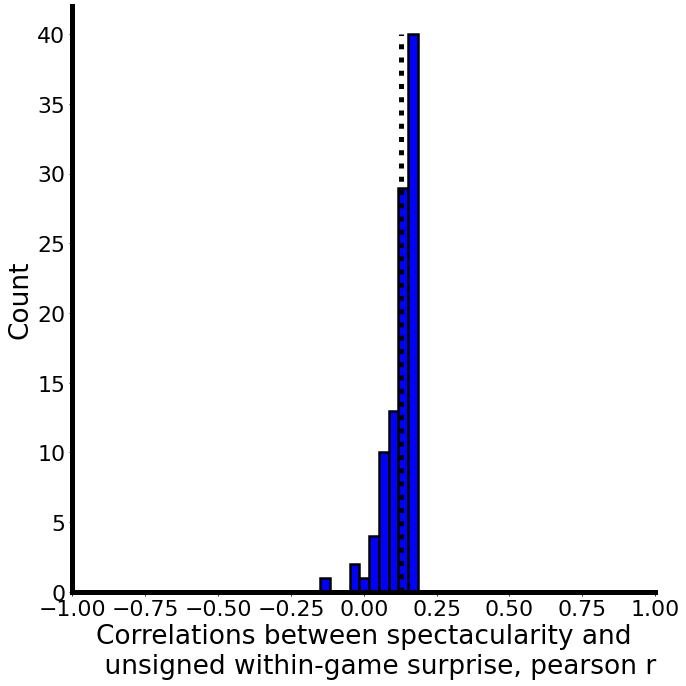

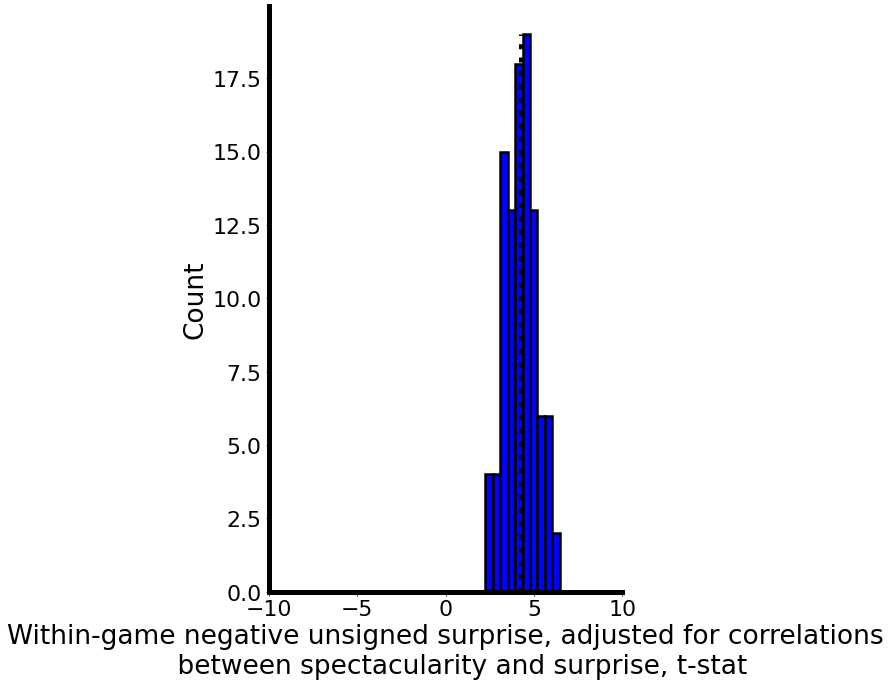

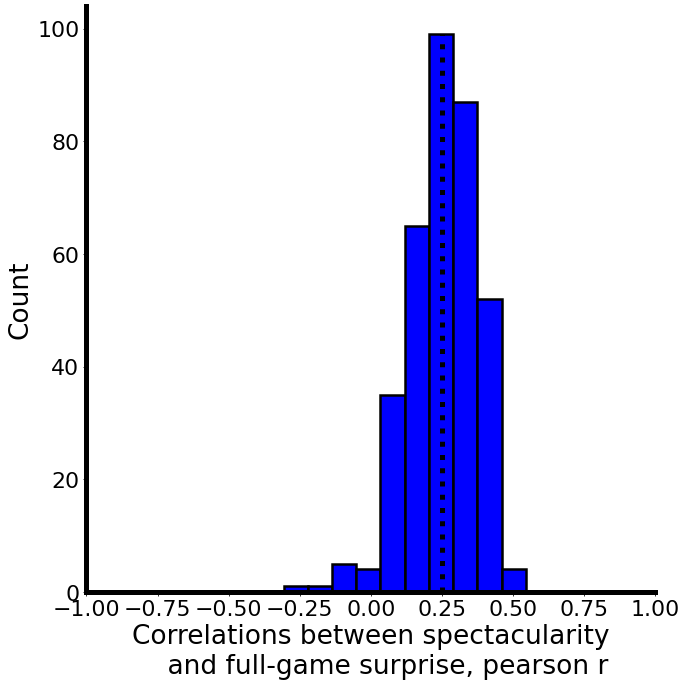

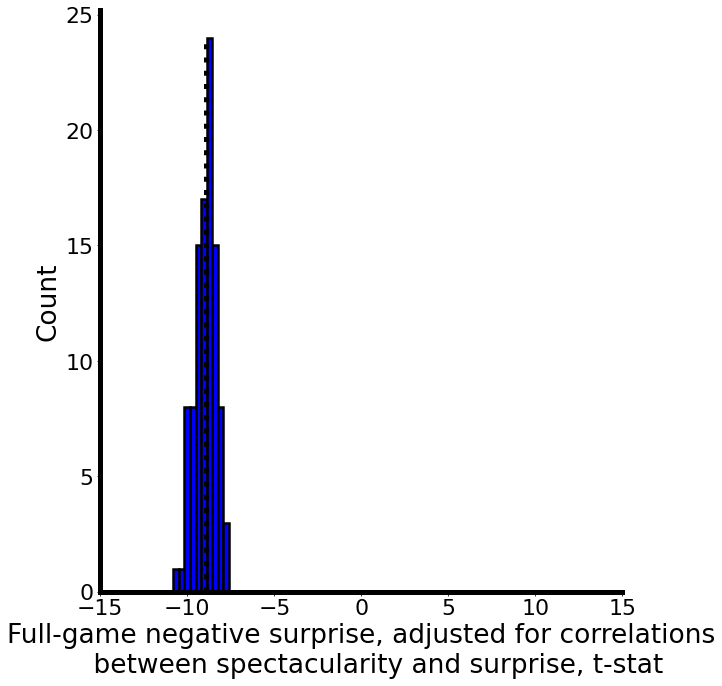

In [ ]:
#address positive relationship between neg full-game surprise and spect
#permutation analysis equating max unsigned within-game surprise
ystr1,ybr1='relcbsur_a','Unsigned within-game surprise'
ystr2,ybr2='Spectacularity of game?','Spectacularity'
x2=np.absolute(dfgn[ystr1].values)
y2=dfgn[ystr2].values

iters,outer_iters,n_iters,pthr=0,0,100,0.2
adj_tstats_r_wgn_un,adj_tstats_pvals_wgn_un=np.zeros((n_iters)),np.zeros((n_iters))
cumu_r_wgn_un,r_rvals_wgn_un,r_rvals_wgn_un_adj=[],[],[] #cumulative distributions
qn=np.where(dfgn[ystr2].isna()==0)[0]
while iters<n_iters:
    nv=qn.shape[0]
    q0=np.random.choice(nv,nv*2//3)
    corr, pval = pearsonr(x2[qn[q0]],y2[qn[q0]])
    outer_iters+=1
    if pval>pthr:
        r_rvals_wgn_un_adj=np.hstack([r_rvals_wgn_un_adj,corr])
        if iters==0:
            print(x2[qn[q0]])
            print(1-mwwps[:,0])
        stat,pval=stats.ttest_ind(x2[qn[q0]],1-mwwps[:,0])
        adj_tstats_r_wgn_un[iters]=stat
        adj_tstats_pvals_wgn_un[iters]=pval
        cumu_r_wgn_un=np.hstack([cumu_r_wgn_un,x2[qn[q0]]])
        iters+=1

print(r_rvals_wgn_un_adj)
print('% non-sig corrs:',iters/outer_iters)
qq=adj_tstats_pvals_wgn_un<0.05
print('pos, adj for spect, #sig:%s' %(np.sum(qq)/len(adj_tstats_pvals_wgn_un)))
adj_histo(r_rvals_wgn_un_adj,1,'b','''Correlations between spectacularity and
    unsigned within-game surprise''','figs/game_r_spect_fgsurs.pdf') 
adj_histo(adj_tstats_r_wgn_un,10,'b','''Within-game negative unsigned surprise, adjusted for correlations
    between spectacularity and surprise''','figs/game_adj_histo_r_spect_fgsur.pdf')

#permutation analysis equating max signed full-game surprise
ystr1,ybr1='relgsur_a','Signed post- minus pre-game surprise'
ystr2,ybr2='Spectacularity of game?','Spectacularity'
x2=dfgn[ystr1].values
y2=dfgn[ystr2].values

iters,outer_iters,n_iters,pthr=0,0,100,0.1
adj_tstats_r_fgn,adj_tstats_pvals_fgn=np.zeros((n_iters)),np.zeros((n_iters))
cumu_r_fgn,r_rvals_fgn=[],[] #cumulative distributions
qn=np.where(dfgn[ystr2].isna()==0)[0]
while iters<n_iters:
    nv=qn.shape[0]
    q0=np.random.choice(nv,nv)
    corr, pval = pearsonr(x2[qn[q0]],y2[qn[q0]])
    r_rvals_fgn=np.hstack([r_rvals_fgn,corr])
    outer_iters+=1
    if pval>pthr:
        if iters==0:
            print(x2[qn[q0]])
            print(rel_fwwps)
        stat,pval=stats.ttest_ind(x2[qn[q0]],rel_fwwps)
        adj_tstats_r_fgn[iters]=stat
        adj_tstats_pvals_fgn[iters]=pval
        cumu_r_fgn=np.hstack([cumu_r_fgn,x2[qn[q0]]])
        iters+=1

print('% non-sig corrs:',iters/outer_iters)
qq=adj_tstats_pvals_fgn<0.05
print('pos, adj for spect, #sig:%s' %(np.sum(qq)/len(adj_tstats_pvals_fgn)))
adj_histo(r_rvals_fgn,1,'b','''Correlations between spectacularity
    and full-game surprise''','figs/game_r_spect_fgsurs.pdf') 
adj_histo(adj_tstats_r_fgn,15,'b','''Full-game negative surprise, adjusted for correlations
    between spectacularity and surprise''','figs/game_adj_histo_r_spect_fgsur.pdf')

# season data

In [ ]:
# clean and organize
#first, find starting year from Year
sp_year,sn_year=np.zeros((nsp)),np.zeros((nsn))
for i in range(nsp):
    sp_year[i]=dfsp['Year'][dfsp.index[i]][:4]
for i in range(nsn):
    sn_year[i]=dfsn['Year'][dfsn.index[i]][:4]
dfsp['syear'],dfsn['syear']=sp_year,sn_year
dfsp=dfsp.rename(columns={"Spectacularity (1-4)": "Spectacularity"})
dfsn=dfsn.rename(columns={"Spectacularity (1-4)": "Spectacularity"})
nots=len(df_ots) #same length as df_svr

In [ ]:
#find maximum play, full- and within-game surprises during season
inds=[]
mxmxsurs,mxfgsurs,mxwgsurs=np.zeros((nots)),np.zeros((nots)),np.zeros((nots))
for i in range(nots): #don't use most current year, don't have pbp
    curr_y=df_svr['Starting year'][i] #find year
    s=df_svr['Team'][i] #find team index
    for ii in range(len(nba3)):
        if s == nba3[ii]:
            ix=ii+0
            break
    #find all games with this year / team 
    if curr_y!=2020: #not bubble year
        mthc=8 #month cutoff
    else:
        mthc=11 #month cutoff
    qq=np.where(np.logical_and(np.logical_or(df1['home']==ix,df1['vis']==ix),
                               np.logical_or(np.logical_and(df1['year']==curr_y,df1['month']>mthc),
                                   np.logical_and(df1['year']==curr_y+1,df1['month']<mthc))))[0]
    dfq=df1.iloc[qq]
    gids=dfq.g_id.unique()
    maxsurs,maxfgsurs,maxwgsurs=np.zeros((len(gids))),np.zeros((len(gids))),np.zeros((len(gids)))
    for ii in range(len(gids)):
        qq=np.where(dfq['g_id']==gids[ii])[0]
        maxsurs[ii]=dfq['maxsur'][dfq.index[qq[0]]]
        maxfgsurs[ii]=dfq['fgsur'][dfq.index[qq[0]]]
        maxwgsurs[ii]=dfq['wgsur'][dfq.index[qq[0]]]
    mxmxsurs[i]=np.max(np.absolute(maxsurs))
    mxfgsurs[i]=np.max(np.absolute(maxfgsurs))
    mxwgsurs[i]=np.max(np.absolute(maxwgsurs))
    if i%200==0:
        print('progress:',i)
    
df_svr['mxmxsur']=mxmxsurs #add back to dataframe
df_svr['mxfgsur']=mxfgsurs
df_svr['mxwgsur']=mxwgsurs

progress: 0
progress: 200
progress: 400


In [ ]:
#rank-ordered "season success" variable rather than win %
years=df_ots['Starting year'].unique()
rank_ys,pre_ranks=np.zeros((len(years),len(nba3))),np.zeros((len(years),len(nba3)))
tnop,t1r,t2r,t3r=14,8,4,2 #teams that miss the playoffs, make only 1st, 2nd, 3rd
for i in range(len(years)):
    #non-playoff teams
    q=np.where(df_ots['Starting year']==years[i])[0]
    rank_y=sss.rankdata(df_svr['Win %'][q])
    #teams making 1st round only
    q0=np.where(np.logical_and(df_ots['P1'][q]>-100000,df_ots['P2'][q].isna()))[0]
    rank_temp=sss.rankdata(df_svr['Win %'][q[q0]])
    rank_y[q0]=tnop+rank_temp #add to main index
    qq=np.where(df_ots['P2'][q]>-100000)[0]
    #teams making 2nd round only
    qq0=np.where(np.logical_and(df_ots['P2'][q[qq]]>-100000,df_ots['P3'][q[qq]].isna()))[0]
    rank_temp=sss.rankdata(df_svr['Win %'][q[qq[qq0]]])
    rank_y[qq[qq0]]=tnop+t1r+rank_temp
    qqq=np.where(df_ots['P3'][q[qq]]>-100000)[0]
    #teams making 3rd round only
    qqq0=np.where(np.logical_and(df_ots['P3'][q[qq[qqq]]]>-100000,df_ots['P4'][q[qq[qqq]]].isna()))[0]
    rank_temp=sss.rankdata(df_svr['Win %'][q[qq[qqq[qqq0]]]])
    rank_y[qq[qqq[qqq0]]]=tnop+t1r+t2r+rank_temp
    #team losing championship
    qqqq=np.where(df_ots['P4'][q[qq[qqq]]]>-100000)[0]
    qqqq0=np.where(np.logical_and(df_ots['P4'][q[qq[qqq[qqqq]]]]>-100000,
                                  df_ots['Champ'][q[qq[qqq[qqqq]]]].isna()))[0]
    rank_temp=sss.rankdata(df_svr['Win %'][q[qq[qqq[qqqq[qqqq0]]]]])
    rank_y[qq[qqq[qqqq[qqqq0]]]]=tnop+t1r+t2r+t3r+rank_temp
    qqqqq=np.where(df_ots['Champ'][q[qq[qqq[qqqq]]]]=='** WINNER **')[0]
    rank_y[qq[qqq[qqqq[qqqqq]]]]=30
    rank_ys[i,:]=len(nba3)+1-rank_y #reverse these for final rankings (so #1 is best)
    #also do pre_odds rank (rather than as odds)
    pre_ranks[i,:]=sss.rankdata(df_ots['Pre3'].values[q])

In [ ]:
#within-season low and high odds values -- lots of maxxing/minning
low_odds,hi_odds=np.zeros((nots)),np.zeros((nots))
for i in range(nots):
    low_odds[i]=np.nanmax([np.nanmax([np.nanmax([np.nanmax( #np.nanmax([np.nanmax([np.nanmax([np.nanmax([
        [np.nanmax([np.nanmax([np.nanmax([np.nanmax([df_ots['Pre1'][i],df_ots['Pre2'][i]]),
        df_ots['Pre3'][i]]),df_ots['S1'][i]]),df_ots['S2'][i]]),df_ots['S3'][i]]),df_ots['S4'][i]]),
        df_ots['S5'][i]]),df_ots['S6'][i]])#,df_ots['P1'][i]]),df_ots['P2'][i]]),df_ots['P3'][i]]),
        #df_ots['P4'][i]])
    hi_odds[i]=np.nanmin([np.nanmin([np.nanmin([np.nanmin( #np.nanmin([np.nanmin([np.nanmin([np.nanmin([
        [np.nanmin([np.nanmin([np.nanmin([np.nanmin([df_ots['Pre1'][i],df_ots['Pre2'][i]]),
        df_ots['Pre3'][i]]),df_ots['S1'][i]]),df_ots['S2'][i]]),df_ots['S3'][i]]),df_ots['S4'][i]]),
        df_ots['S5'][i]]),df_ots['S6'][i]])#,df_ots['P1'][i]]),df_ots['P2'][i]]),df_ots['P3'][i]])#,
        #df_ots['P4'][i]])
df_ots['low_odds']=low_odds
df_ots['hi_odds']=hi_odds

<ipython-input-55-22f7ed653008>:5: RuntimeWarning: All-NaN axis encountered
  [np.nanmax([np.nanmax([np.nanmax([np.nanmax([df_ots['Pre1'][i],df_ots['Pre2'][i]]),
<ipython-input-55-22f7ed653008>:10: RuntimeWarning: All-NaN axis encountered
  [np.nanmin([np.nanmin([np.nanmin([np.nanmin([df_ots['Pre1'][i],df_ots['Pre2'][i]]),


In [ ]:
#align with subject responses
# positive
wonchampp,lostchampp,pre_oddsp,low_oddsp=np.zeros((nsp)),np.zeros((nsp)),np.zeros((nsp)),np.zeros((nsp))
hi_oddsp,recordp,rankp,pre_rankp=np.zeros((nsp)),np.zeros((nsp)),np.zeros((nsp)),np.zeros((nsp))
mxmxsurp,mxfgsurp,mxwgsurp,t_i_sp,y_i_sp=np.zeros((nsp)),np.zeros((nsp)),np.zeros((nsp)),np.zeros((nsp)),np.zeros((nsp))
for i in range(nsp):
    curr_y=dfsp['syear'][dfsp.index[i]] #match year
    q=np.where(df_ots['Starting year']==curr_y)[0]
    curr_t=dfsp['Team'][dfsp.index[i]] #match team
    qq=np.where(df_ots['Team'][q]==curr_t)[0]
    print('Year, team:%s,%s' %(curr_y,curr_t))
    print('rows, rows:%s,%s' %(len(q),len(qq)))
    t_i_sp[i],y_i_sp[i]=nba3.index(curr_t),curr_y
    
    #final preseason odds
    pre3=df_ots['Pre3'][q[qq]].values
    if pre3>0:
        pre_oddsp[i]=100/(100+pre3)
    else:
        pre_oddsp[i]=np.absolute(pre3)/(100+np.absolute(pre3))
    
    #lowest/highest odds during season
    low_o=df_ots['low_odds'][q[qq]].values
    if low_o>0:
        low_oddsp[i]=100/(100+low_o)
    else:
        low_oddsp[i]=np.absolute(low_o)/(100+np.absolute(low_o))
    hi_o=df_ots['hi_odds'][q[qq]].values
    if hi_o>0:
        hi_oddsp[i]=100/(100+hi_o)
    else:
        hi_oddsp[i]=np.absolute(hi_o)/(100+np.absolute(hi_o))
    
    qq2=np.where(df_svr['Team'][q]==curr_t)[0]
    recordp[i]=df_svr['Win %'][q[qq]].values
    
    if df_ots['P4'][q[qq]].values>-1000000: #got into champ game
        if '** WINNER **'==df_ots['Champ'][q[qq]].values:
            wonchampp[i]=1
        else:
            lostchampp[i]=1
    qqq=np.where(years==curr_y)[0]
    rankp[i]=rank_ys[int(qqq[0]),int(qq)] #season success rank
    pre_rankp[i]=pre_ranks[int(qqq[0]),int(qq)] #season pre-rank
    
    #max play, fg, and wg sur
    mxmxsurp[i]=df_svr['mxmxsur'][q[qq]].values
    mxfgsurp[i]=df_svr['mxfgsur'][q[qq]].values
    mxwgsurp[i]=df_svr['mxwgsur'][q[qq]].values

Year, team:2015.0,GSW
rows, rows:30,1
Year, team:2014.0,GSW
rows, rows:30,1
Year, team:2017.0,GSW
rows, rows:30,1
Year, team:2007.0,BOS
rows, rows:30,1
Year, team:2015.0,GSW
rows, rows:30,1
Year, team:2015.0,GSW
rows, rows:30,1
Year, team:2013.0,SAS
rows, rows:30,1
Year, team:2015.0,GSW
rows, rows:30,1
Year, team:2019.0,LAL
rows, rows:30,1
Year, team:2019.0,LAL
rows, rows:30,1
Year, team:2015.0,GSW
rows, rows:30,1
Year, team:2018.0,TOR
rows, rows:30,1
Year, team:2015.0,GSW
rows, rows:30,1
Year, team:2017.0,GSW
rows, rows:30,1
Year, team:2017.0,GSW
rows, rows:30,1
Year, team:2015.0,GSW
rows, rows:30,1
Year, team:2015.0,GSW
rows, rows:30,1
Year, team:2014.0,GSW
rows, rows:30,1
Year, team:2015.0,CLE
rows, rows:30,1
Year, team:2017.0,GSW
rows, rows:30,1
Year, team:2014.0,GSW
rows, rows:30,1
Year, team:2015.0,CLE
rows, rows:30,1
Year, team:2014.0,GSW
rows, rows:30,1
Year, team:2015.0,GSW
rows, rows:30,1
Year, team:2015.0,GSW
rows, rows:30,1
Year, team:2018.0,POR
rows, rows:30,1
Year, team:2

In [ ]:
# negative
wonchampn,lostchampn,pre_oddsn,low_oddsn=np.zeros((nsn)),np.zeros((nsn)),np.zeros((nsn)),np.zeros((nsn))
hi_oddsn,recordn,rankn,pre_rankn=np.zeros((nsn)),np.zeros((nsn)),np.zeros((nsn)),np.zeros((nsn))
mxmxsurn,mxfgsurn,mxwgsurn,t_i_sn,y_i_sn=np.zeros((nsn)),np.zeros((nsn)),np.zeros((nsn)),np.zeros((nsn)),np.zeros((nsn))
for i in range(nsn):
    curr_y=dfsn['syear'][dfsn.index[i]] #match year
    q=np.where(df_ots['Starting year']==curr_y)[0]
    curr_t=dfsn['Team'][dfsn.index[i]] #match home team
    qq=np.where(df_ots['Team'][q]==curr_t)[0]
    t_i_sn[i],y_i_sn[i]=nba3.index(curr_t),curr_y
    print('Year, team:%s,%s' %(curr_y,curr_t))
    print('rows, rows:%s,%s' %(len(q),len(qq)))
    pre3=df_ots['Pre3'][q[qq]].values
    if pre3>0:
        pre_oddsn[i]=100/(100+pre3)
    else:
        pre_oddsn[i]=np.absolute(pre3)/(100+np.absolute(pre3))
    low_o=df_ots['low_odds'][q[qq]].values
    if low_o>0:
        low_oddsn[i]=100/(100+low_o)
    else:
        low_oddsn[i]=np.absolute(low_o)/(100+np.absolute(low_o))
    hi_o=df_ots['hi_odds'][q[qq]].values
    if hi_o>0:
        hi_oddsn[i]=100/(100+hi_o)
    else:
        hi_oddsn[i]=np.absolute(hi_o)/(100+np.absolute(hi_o))
    qq2=np.where(df_svr['Team'][q]==curr_t)[0]
    recordn[i]=df_svr['Win %'][q[qq]].values
    
    if df_ots['P4'][q[qq]].values>-1000000: #got into champ game
        if '** WINNER **'==df_ots['Champ'][q[qq]].values:
            wonchampn[i]=1
        else:
            lostchampn[i]=1
    qqq=np.where(years==curr_y)[0]
    rankn[i]=rank_ys[int(qqq[0]),int(qq)]
    pre_rankn[i]=pre_ranks[int(qqq[0]),int(qq)] #season pre-rank
    
    #max play, fg, and wg sur
    mxmxsurn[i]=df_svr['mxmxsur'][q[qq]].values
    mxfgsurn[i]=df_svr['mxfgsur'][q[qq]].values
    mxwgsurn[i]=df_svr['mxwgsur'][q[qq]].values

Year, team:2018.0,SAC
rows, rows:30,1
Year, team:2019.0,GSW
rows, rows:30,1
Year, team:2015.0,GSW
rows, rows:30,1
Year, team:2019.0,POR
rows, rows:30,1
Year, team:2019.0,SAC
rows, rows:30,1
Year, team:2019.0,GSW
rows, rows:30,1
Year, team:2018.0,SAC
rows, rows:30,1
Year, team:2013.0,GSW
rows, rows:30,1
Year, team:2019.0,GSW
rows, rows:30,1
Year, team:2015.0,GSW
rows, rows:30,1
Year, team:2019.0,GSW
rows, rows:30,1
Year, team:2015.0,GSW
rows, rows:30,1
Year, team:2019.0,GSW
rows, rows:30,1
Year, team:2018.0,CLE
rows, rows:30,1
Year, team:2019.0,GSW
rows, rows:30,1
Year, team:2015.0,GSW
rows, rows:30,1
Year, team:2018.0,LAL
rows, rows:30,1
Year, team:2014.0,MIL
rows, rows:30,1
Year, team:2019.0,LAC
rows, rows:30,1
Year, team:2015.0,GSW
rows, rows:30,1
Year, team:2015.0,GSW
rows, rows:30,1
Year, team:2020.0,SAC
rows, rows:30,1
Year, team:2017.0,LAL
rows, rows:30,1
Year, team:2015.0,LAL
rows, rows:30,1
Year, team:2019.0,DEN
rows, rows:30,1
Year, team:2015.0,LAL
rows, rows:30,1
Year, team:2

kurtosis g1: -19.157, p=0.0; kurtosis g2: -1.8, p=0.072
skewness g1: 1.427, p=0.154; kurtosis g2: 0.132, p=0.895
use mann-whitney!
max play sur in szn, pos vs null
   meth  g1n    g1m    g1s     g1med  g2n    g2m    g2s  g2med   df     stat  \
0     2  510  0.617  0.008  0.583418   96  0.603  0.015    0.6  604  25049.5   

   tstat      p  p_ttest      d  
0  0.771  0.718    0.441  0.086  


kurtosis g1: -19.157, p=0.0; kurtosis g2: -1.825, p=0.068
skewness g1: 1.427, p=0.154; kurtosis g2: 2.423, p=0.015
use mann-whitney!
max play sur in szn, neg vs null
   meth  g1n    g1m    g1s     g1med  g2n    g2m    g2s     g2med   df  \
0     2  510  0.617  0.008  0.583418   83  0.595  0.018  0.588653  591   

      stat  tstat      p  p_ttest      d  
0  22583.0   1.09  0.327    0.276  0.129  


kurtosis g1: -13.981, p=0.0; kurtosis g2: 1.537, p=0.124
skewness g1: -2.614, p=0.009; kurtosis g2: -4.67, p=0.0
use mann-whitney!
max full-game sur in szn, pos vs null
   meth  g1n    g1m    g1s     g1

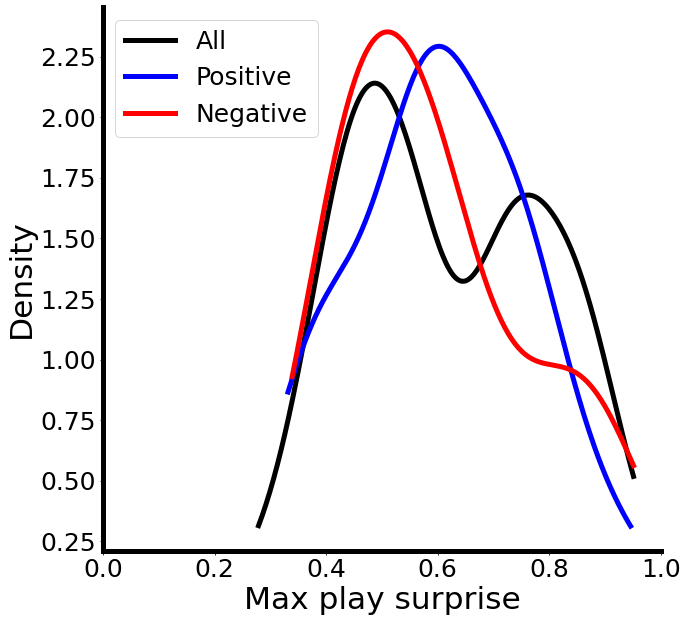

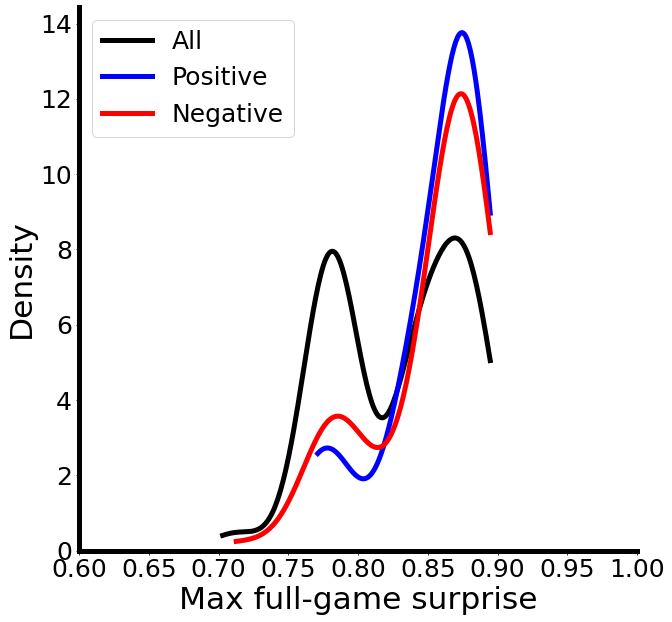

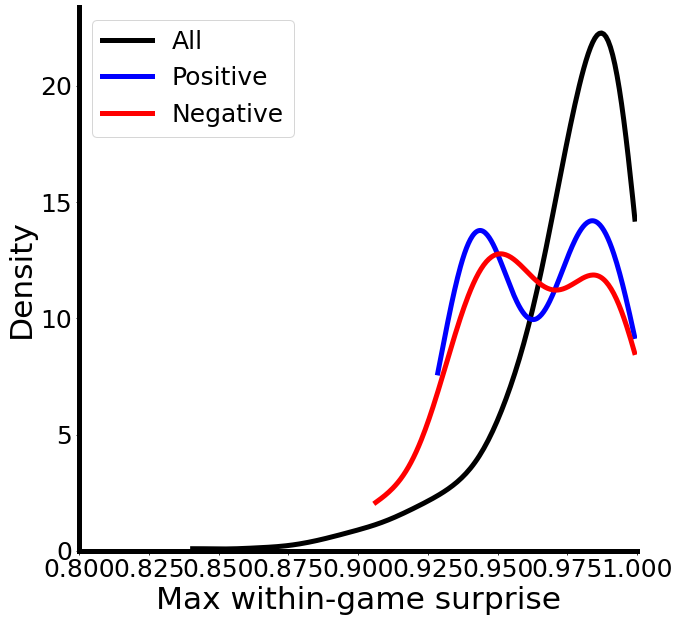

In [ ]:
#control analyses - play, full- and within-game sur
astats2(mxmxsurs,mxmxsurp,'max play sur in szn, pos vs null')
astats2(mxmxsurs,mxmxsurn,'max play sur in szn, neg vs null')
astats2(mxfgsurs,mxfgsurp,'max full-game sur in szn, pos vs null')
astats2(mxfgsurs,mxfgsurn,'max full-game sur in szn, neg vs null')
astats2(mxwgsurs,mxwgsurp,'max within-game sur in szn, pos vs null')
astats2(mxwgsurs,mxwgsurn,'max within-game sur in szn, neg vs null')

kdeplotf(mxmxsurs,mxmxsurp,mxmxsurn,'Max play surprise',[0,1],'figs/season_play_sur.pdf',0)
kdeplotf(mxfgsurs,mxfgsurp,mxfgsurn,'Max full-game surprise',[0.6,1],'figs/season_fgame_sur.pdf',0)
kdeplotf(mxwgsurs,mxwgsurp,mxwgsurn,'Max within-game surprise',[0.8,1],'figs/season_wgame_sur.pdf',0)

r-squared = 0.3755190587938962, p = 6.636629164151032e-54
kurtosis g1: 1.3, p=0.194
skewness g1: -2.972, p=0.003
use wilcoxon!
szn sur, resid, pos vs null
   meth  g1n   g1m    g1s  df  stat  tstat    p     dz     g1med  p_ttest
0     2   96 -5.48  0.395  95  28.0  -13.8  0.0 -1.416 -4.777524      0.0


kurtosis g1: 5.435, p=0.0
skewness g1: 7.777, p=0.0
use wilcoxon!
szn sur, actual, pos vs null
   meth  g1n    g1m   g1s  df  stat   tstat    p     dz  g1med  p_ttest
0     2   96  2.766  0.43  95  19.0 -29.236  0.0  0.657    1.0      0.0


kurtosis g1: -2.462, p=0.014
skewness g1: 2.278, p=0.023
use wilcoxon!
szn sur, resid, neg vs null
   meth  g1n   g1m  g1s  df    stat  tstat      p     dz     g1med  p_ttest
0     2   83  4.09  1.1  82  1122.0  3.695  0.005  0.408  1.365304      0.0


kurtosis g1: -41.614, p=0.0
skewness g1: 0.152, p=0.879
use wilcoxon!
szn sur, actual, neg vs null
   meth  g1n   g1m    g1s  df    stat  tstat      p     dz  g1med  p_ttest
0     2   83  15.5  1.268  

/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


pos, adj for fg, #sig:1.0
neg, adj for fg, #sig:0.82
pos, adj for wg, #sig:1.0
neg, adj for wg, #sig:0.87
season spectacularity, pos vs neg
   g1n    g1m    g1s  g1med  g2n    g2m    g2s  g2med   df   stat  tstat    p  \
0   96  1.927  0.081    2.0   83  1.964  0.089    2.0  177  0.032 -0.304  1.0   

   p_ttest      d  
0    0.762 -0.046  


r-squared,positive = 0.024909694241373244, pval = 0.12459271546125335
r-squared,negative = 0.0007164338183211679, pval = 0.8101773342819201
r-squared,unsigned,positive = 0.03462889266832262, pval = 0.0694788444626211
r-squared,unsigned,negative = 0.0051112782944257844, pval = 0.5206921609792635
[ 4.22226122 11.69701829  8.74599707 11.69701829  5.58218658 11.69701829
  4.77752392  5.58218658  0.41091737  3.22664751 17.30282921  0.88769568
  1.43550181  4.77752392 10.27001394  4.77752392  5.58218658  4.77752392
  2.17674912  5.58218658  5.58218658 11.69701829  4.77752392  5.58218658
  5.58218658  4.22226122  7.50986141  0.88769568  2.17674912  4.222

<ipython-input-27-0a8271c218b3>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
<ipython-input-27-0a8271c218b3>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
<ipython-input-27-0a8271c218b3>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figur

kurtosis g1: 2.843, p=0.004
skewness g1: -4.73, p=0.0
use wilcoxon!
szn sur, resid, pos vs null
   meth  g1n    g1m    g1s  df    stat  tstat    p     dz     g1med  p_ttest
0     2   96 -2.145  0.364  95  1003.0 -5.857  0.0 -0.601 -1.718303      0.0


kurtosis g1: 5.435, p=0.0
skewness g1: 7.777, p=0.0
use wilcoxon!
szn sur, actual, pos vs null
   meth  g1n    g1m   g1s  df  stat   tstat    p     dz  g1med  p_ttest
0     2   96  2.766  0.43  95  19.0 -29.236  0.0  0.657    1.0      0.0


kurtosis g1: -1.521, p=0.128
skewness g1: 2.319, p=0.02
use wilcoxon!
szn sur, resid, neg vs null
   meth  g1n    g1m    g1s  df   stat  tstat    p     dz     g1med  p_ttest
0     2   83  5.679  0.977  82  624.0  5.777  0.0  0.638  1.816063      0.0


kurtosis g1: -41.614, p=0.0
skewness g1: 0.152, p=0.879
use wilcoxon!
szn sur, actual, neg vs null
   meth  g1n   g1m    g1s  df    stat  tstat      p     dz  g1med  p_ttest
0     2   83  15.5  1.268  82  1549.0  0.079  0.376  1.342   16.0    0.937


kurt

/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


pos, adj for fg, #sig:1.0
neg, adj for fg, #sig:1.0
pos, adj for wg, #sig:1.0
neg, adj for wg, #sig:0.99


<ipython-input-42-10ecdd538f16>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
<ipython-input-42-10ecdd538f16>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
<ipython-input-42-10ecdd538f16>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figur

season spectacularity, pos vs neg
   g1n    g1m    g1s  g1med  g2n    g2m    g2s  g2med   df   stat  tstat    p  \
0   96  1.927  0.081    2.0   83  1.964  0.089    2.0  177  0.032 -0.304  1.0   

   p_ttest      d  
0    0.762 -0.046  


r-squared,positive = 0.11666769531968375, pval = 0.0006595754940521842
r-squared,negative = 0.030050815313537663, pval = 0.11705648678235364
r-squared,unsigned,positive = 0.07883534251787326, pval = 0.005588937146879717
r-squared,unsigned,negative = 9.519777898331045e-06, pval = 0.9779148087491519
[ 0.28623511  8.31633696 14.8211719   6.0678033   1.78503303  0.90370944
  0.90370944  0.90370944  0.90370944  0.90370944  3.35390997  0.90370944
  6.0678033   0.90370944  3.18581611  0.90370944  3.2918629   3.35390997
  0.90370944  0.90370944  3.2918629   6.0678033   0.90370944  3.18581611
  0.69728845  3.35390997  0.69728845  3.2918629   2.83177769  3.35390997
  1.6515736   0.28623511  2.61921808  6.0678033   0.28623511  1.38586203
  0.90370944  0.69728845

<ipython-input-42-10ecdd538f16>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
<ipython-input-42-10ecdd538f16>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))


[  0.90370944   0.90370944  -7.02986324  -3.2918629    0.90370944
  -3.35390997  -2.61921808  -3.35390997   0.90370944  -1.38586203
  -3.2918629   -2.83177769  -3.35390997   0.69728845   0.90370944
   0.69728845   0.90370944  -2.83177769   0.69728845   0.69728845
  -3.35390997  -3.35390997  -2.35390997  -3.35390997   0.90370944
  -5.58973106   0.90370944   1.75901651   0.90370944  -5.81226797
  -3.35390997  -8.31633696  -1.6515736   -8.31633696   0.28623511
   0.90370944  -3.2918629   -5.58973106   0.69728845  -7.02986324
   0.90370944  -6.0678033   -2.83177769   0.28623511  -3.35390997
  -3.35390997  -1.38586203  -3.35390997 -14.8211719   -3.35390997
  -3.35390997  -2.83177769   0.28623511 -10.22508685  -7.15653355
  -1.6515736    0.90370944   0.69728845  -1.38586203  -7.15653355
   0.90370944  -3.35390997  -8.31633696   1.81606344   0.90370944
   0.90370944   0.90370944   0.28623511   0.69728845   0.90370944
   0.90370944   0.69728845  -1.6515736    0.90370944  -3.35390997
   0.90370

<ipython-input-42-10ecdd538f16>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
<ipython-input-42-10ecdd538f16>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
<ipython-input-27-0a8271c218b3>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figur

time affected, pos vs neg
   g1n    g1m    g1s  g1med  g2n    g2m    g2s  g2med   df   stat  tstat  \
0   73  3.411  0.184    4.0   70  3.357  0.155    4.0  141  0.089  0.221   

       p  p_ttest      d  
0  0.908    0.825  0.037  


r-squared,positive = 0.004743859917934267, pval = 0.5625855095753065
r-squared,negative = 0.0034992673828872765, pval = 0.6266567600132877


<ipython-input-59-670c3a73a4aa>:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
<ipython-input-27-0a8271c218b3>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))


r-squared = 0.4355661839635033, p = 4.343893377519194e-65


<ipython-input-27-0a8271c218b3>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
<ipython-input-27-0a8271c218b3>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
<ipython-input-27-0a8271c218b3>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figur

kurtosis g1: 2.323, p=0.02
skewness g1: -1.499, p=0.134
use wilcoxon!
szn sur, resid, pos vs null
   meth  g1n    g1m    g1s  df  stat  tstat    p     dz     g1med  p_ttest
0     2   96 -5.522  0.257  95  10.0 -21.38  0.0 -2.194 -4.810944      0.0


kurtosis g1: 5.435, p=0.0
skewness g1: 7.777, p=0.0
use wilcoxon!
szn sur, actual, pos vs null
   meth  g1n    g1m   g1s  df  stat   tstat    p     dz  g1med  p_ttest
0     2   96  2.766  0.43  95  19.0 -29.236  0.0  0.657    1.0      0.0


kurtosis g1: -3.556, p=0.0
skewness g1: 1.901, p=0.057
use wilcoxon!
szn sur, resid, neg vs null
   meth  g1n    g1m    g1s  df    stat  tstat      p     dz    g1med  p_ttest
0     2   83  4.475  1.106  82  1114.0  4.021  0.004  0.444  2.56846      0.0


kurtosis g1: -41.614, p=0.0
skewness g1: 0.152, p=0.879
use wilcoxon!
szn sur, actual, neg vs null
   meth  g1n   g1m    g1s  df    stat  tstat      p     dz  g1med  p_ttest
0     2   83  15.5  1.268  82  1549.0  0.079  0.376  1.342   16.0    0.937


kur

/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


pos, adj for fg, #sig:1.0
neg, adj for fg, #sig:0.92
pos, adj for wg, #sig:1.0
neg, adj for wg, #sig:0.91


<ipython-input-42-10ecdd538f16>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
<ipython-input-42-10ecdd538f16>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
<ipython-input-42-10ecdd538f16>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figur

season spectacularity, pos vs neg
   g1n    g1m    g1s  g1med  g2n    g2m    g2s  g2med   df   stat  tstat    p  \
0   96  1.927  0.081    2.0   83  1.964  0.089    2.0  177  0.032 -0.304  1.0   

   p_ttest      d  
0    0.762 -0.046  


r-squared,positive = 0.050098842950833146, pval = 0.028363592119693085
r-squared,negative = 0.0017744797358477862, pval = 0.7053408014232527
r-squared,unsigned,positive = 0.07157910849699718, pval = 0.008407340354498718
r-squared,unsigned,negative = 0.004501558013552121, pval = 0.5467336375397788
[ 7.45593055  4.81094424  4.47219082  0.3746292   4.47219082  4.47219082
  1.47219082  7.45593055  5.47219082  5.47219082  3.81094424  7.45593055
  5.47219082  1.52780918  4.47219082  9.43967028  4.81094424  8.74590317
  3.81094424  6.98709497  7.45593055  4.47219082  4.47219082  4.47219082
 11.7296429   4.81094424  4.81094424  4.81094424  7.45593055  7.45593055
  4.47219082  4.81094424  7.45593055  5.47219082  9.43967028  5.47219082
  5.47219082  6.43967028 

<ipython-input-42-10ecdd538f16>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
<ipython-input-42-10ecdd538f16>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))


[ -4.47219082  -4.47219082  -7.45593055  -4.81094424  -5.47219082
  -1.47219082  -4.47219082  -4.81094424  -4.47219082  -4.81094424
 -12.73777303  -4.47219082  -4.47219082  -4.47219082   1.52780918
  -9.43967028  -9.43967028  -5.47219082  -4.47219082  -4.81094424
  -5.47219082  -4.81094424  -9.43967028  -6.43967028  -5.47219082
  -4.81094424  -4.47219082  -4.47219082   1.52780918  -5.47219082
  -4.47219082  -5.47219082  -5.47219082  -4.47219082  -4.47219082
 -11.7296429   -4.81094424  -4.47219082  -4.81094424  -5.47219082
  -3.81094424  -4.47219082  -4.47219082  -4.81094424  -8.11717713
  -4.81094424  -4.81094424  -3.81094424  -6.43967028  -9.43967028
  -0.3746292   -4.47219082  -5.47219082  -9.43967028  -4.47219082
  -4.47219082  -6.43967028  -4.81094424  -5.47219082 -12.73777303
  -4.81094424 -11.7296429   -4.47219082   1.44786395  -4.40714974
  -9.43967028  -9.43967028  -6.98709497  -4.47219082  -4.81094424
  -4.81094424  -5.47219082  -4.81094424  -4.81094424  -5.47219082
  -4.47219

<ipython-input-42-10ecdd538f16>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
<ipython-input-42-10ecdd538f16>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
<ipython-input-27-0a8271c218b3>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figur

time affected, pos vs neg
   g1n    g1m    g1s  g1med  g2n    g2m    g2s  g2med   df   stat  tstat  \
0   73  3.411  0.184    4.0   70  3.357  0.155    4.0  141  0.089  0.221   

       p  p_ttest      d  
0  0.908    0.825  0.037  


r-squared,positive = 0.0003695968230198624, pval = 0.8717488648162937
r-squared,negative = 0.006413151367405522, pval = 0.509888750177179


<ipython-input-22-079c31752ab6>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))


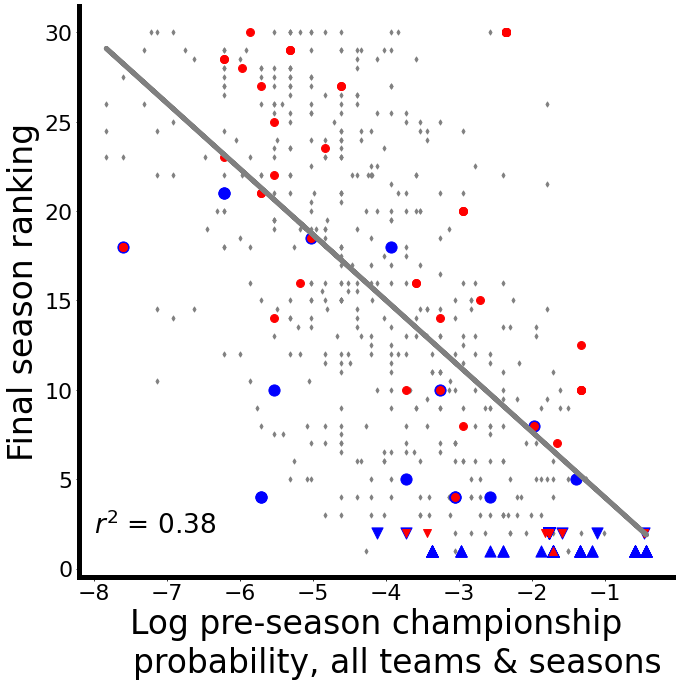

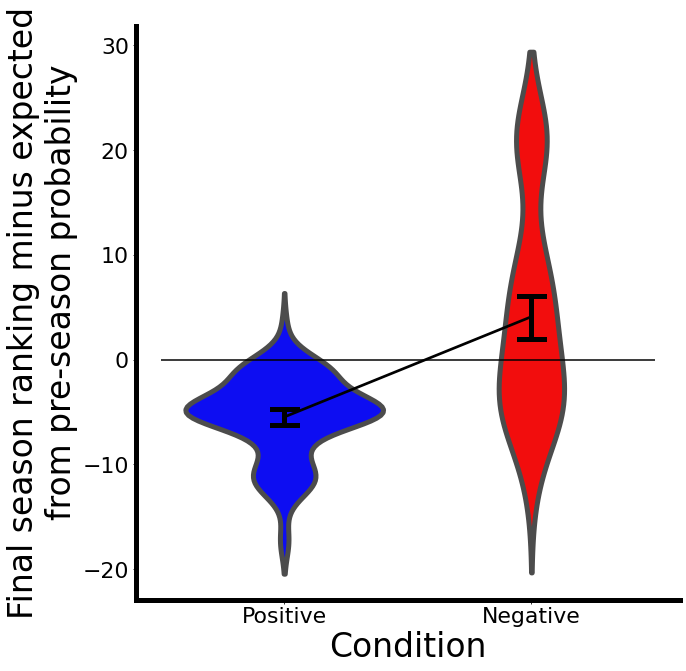

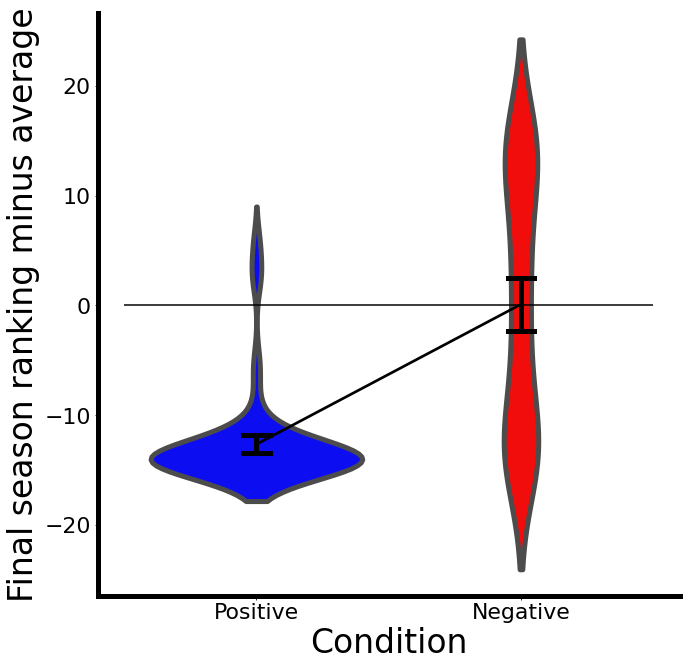

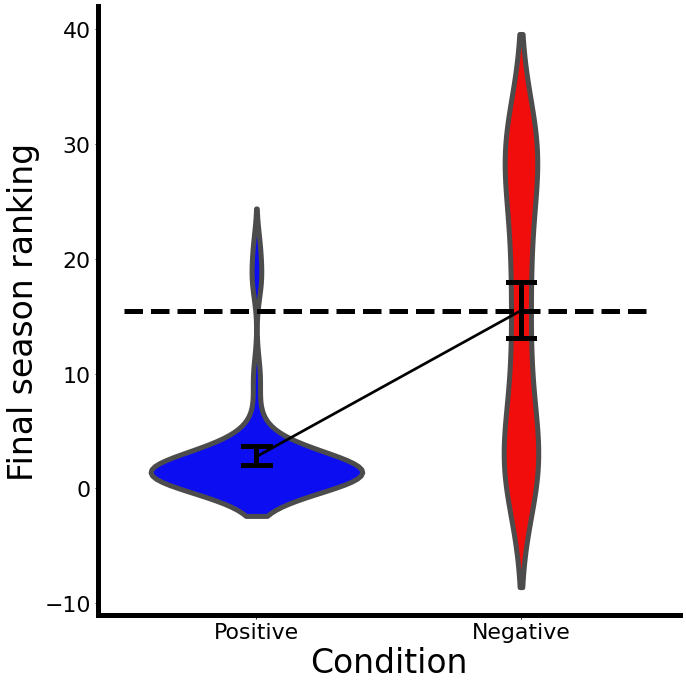

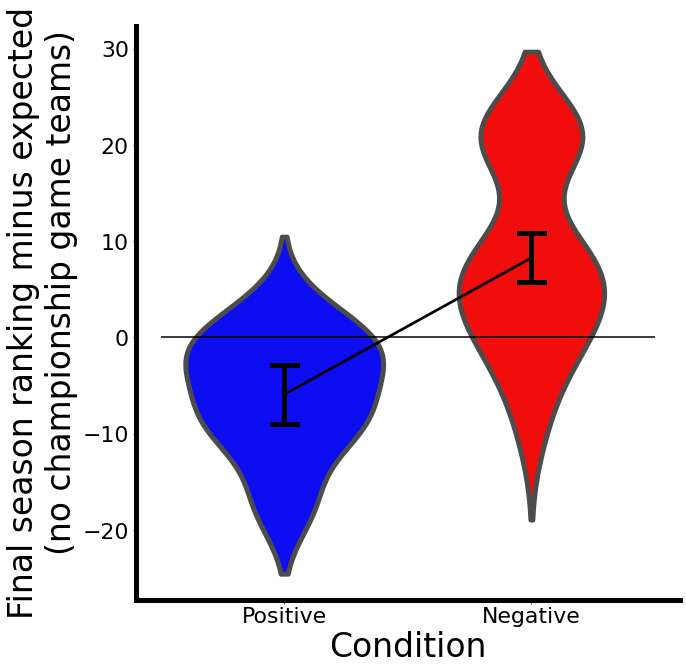

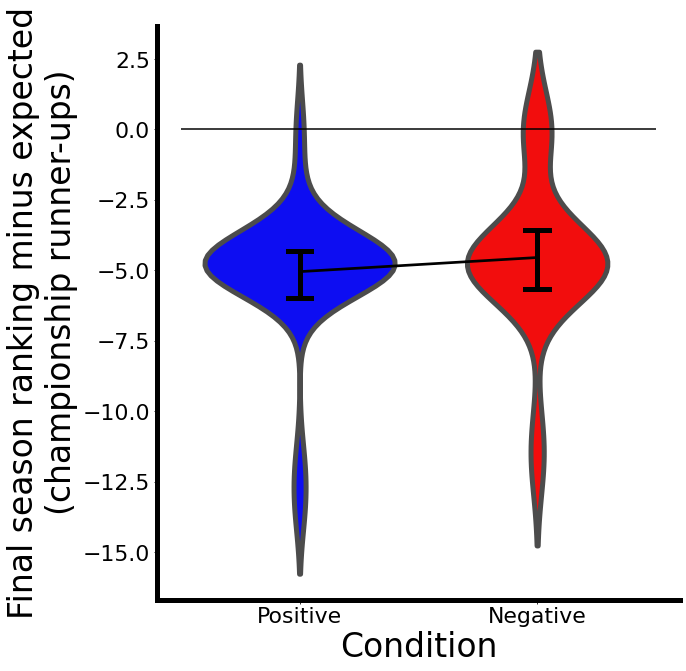

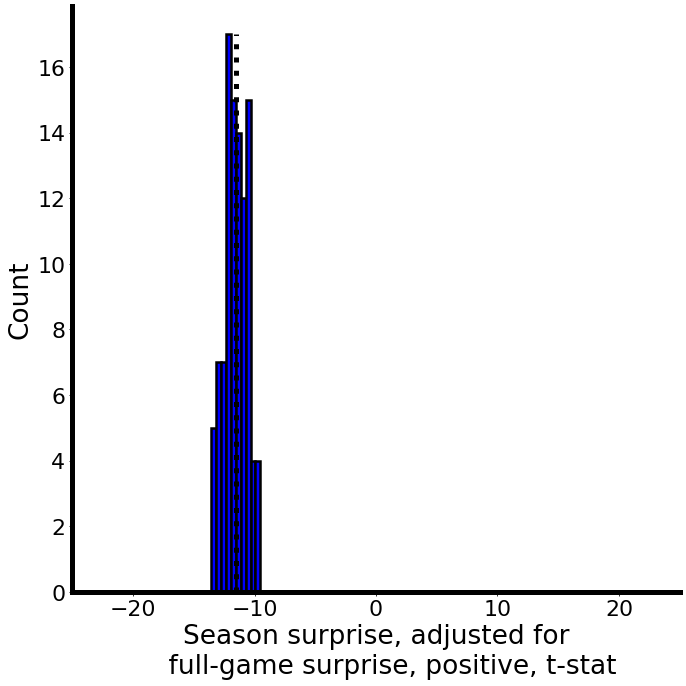

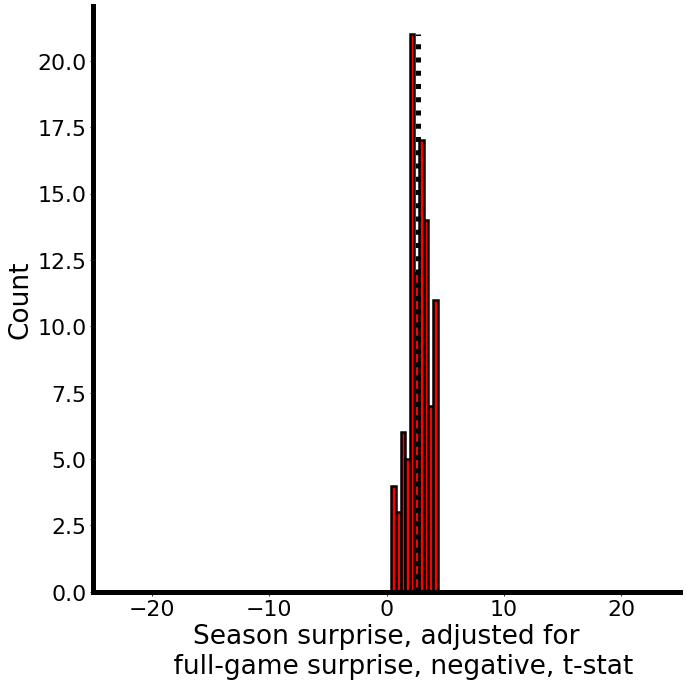

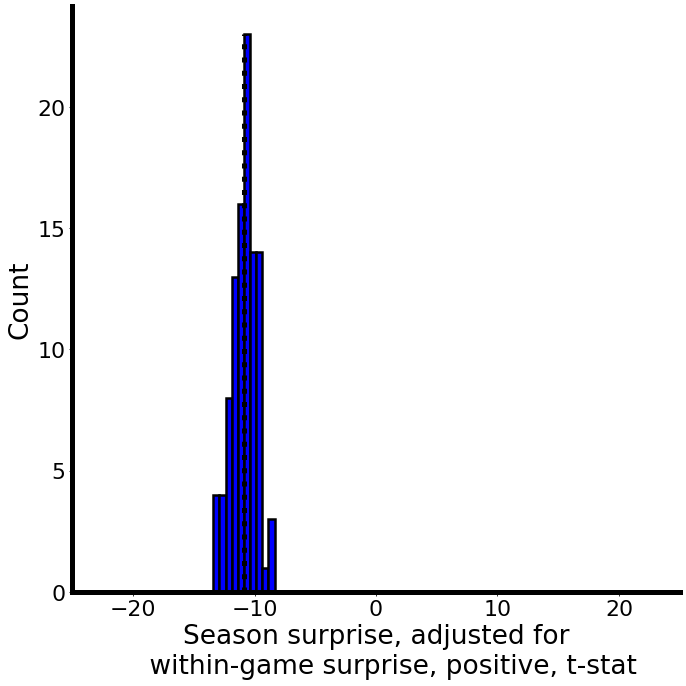

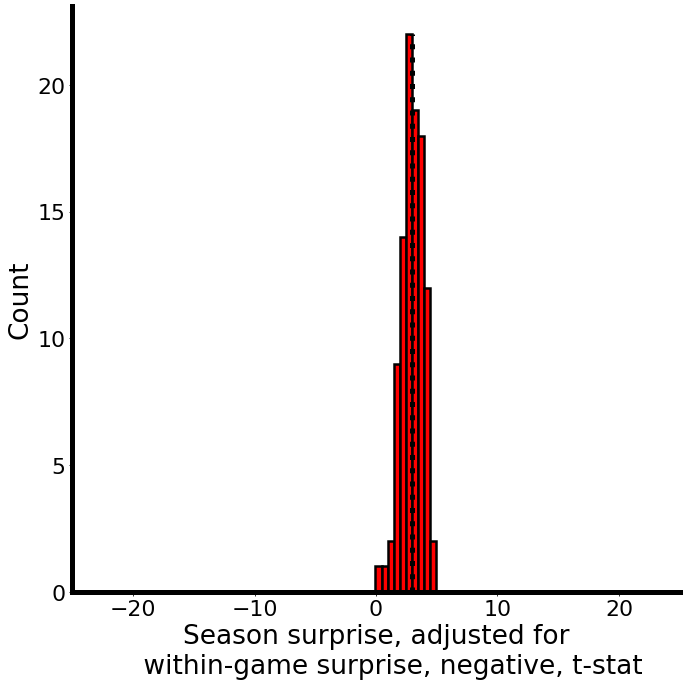

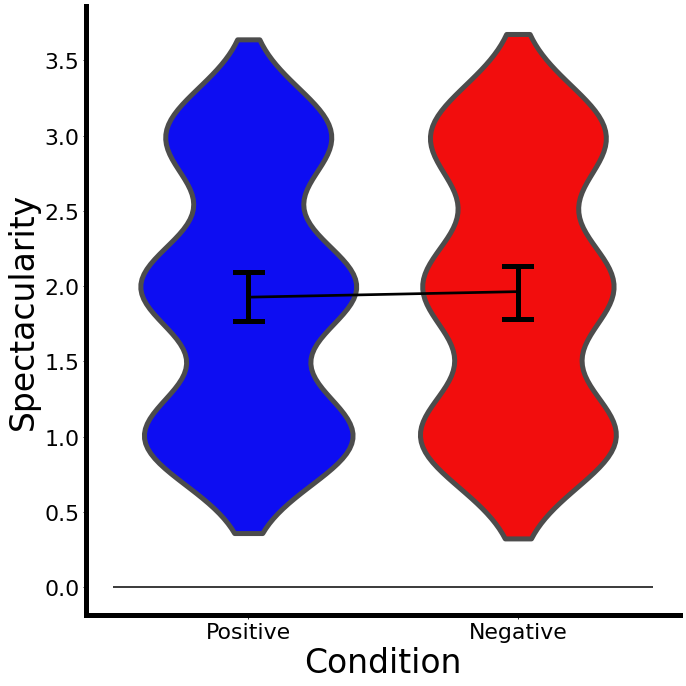

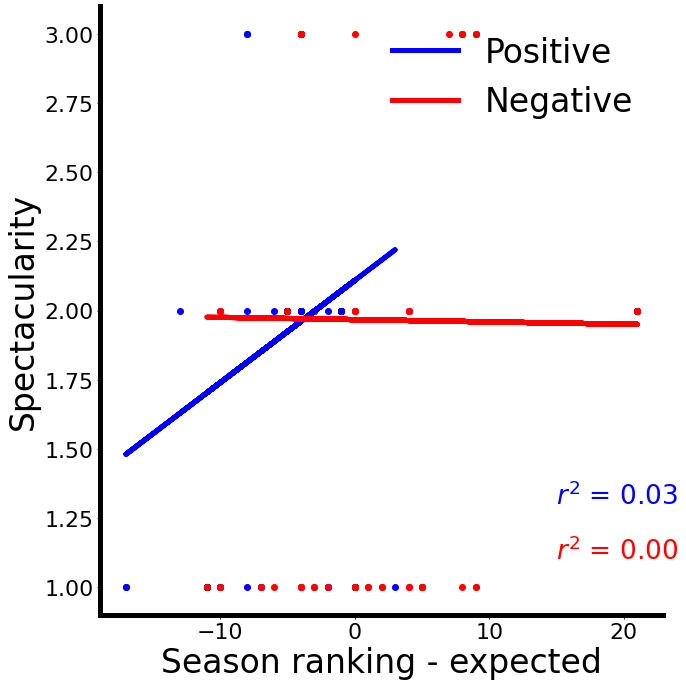

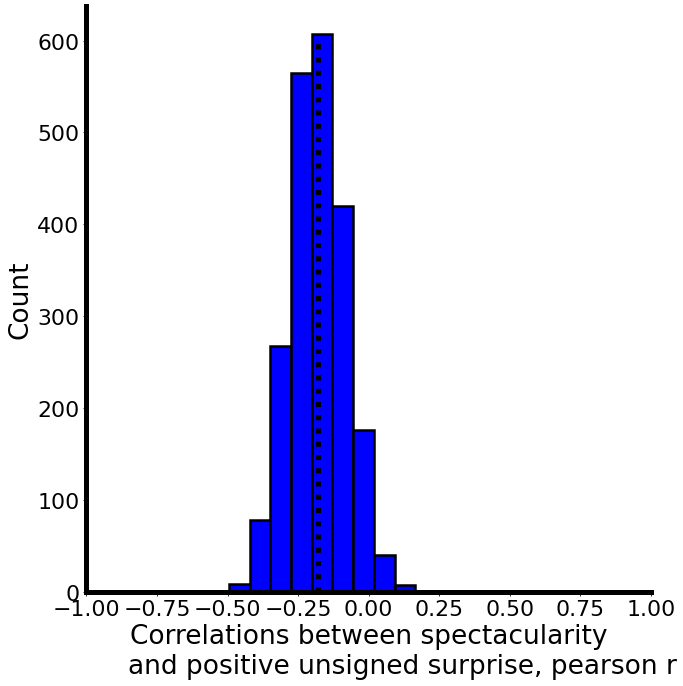

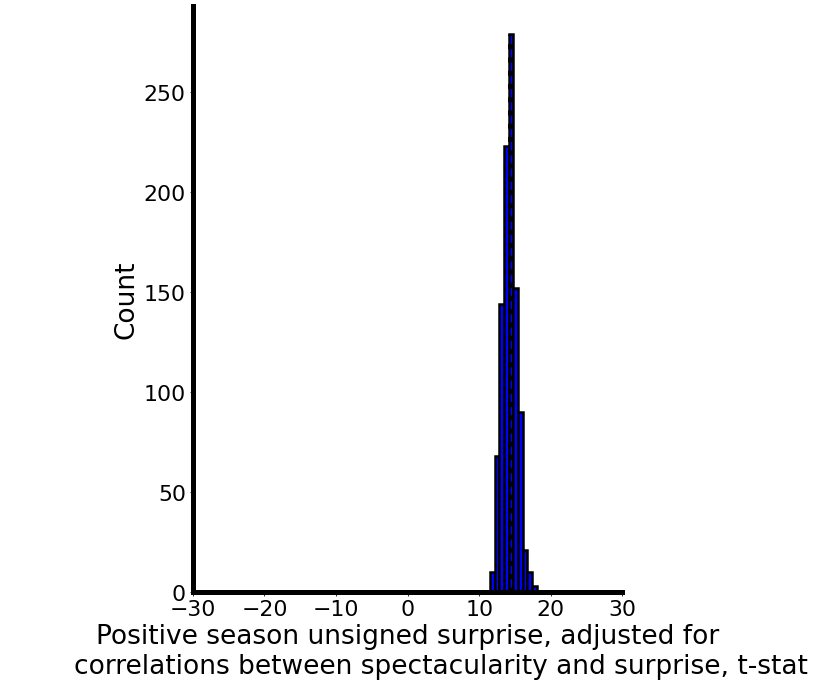

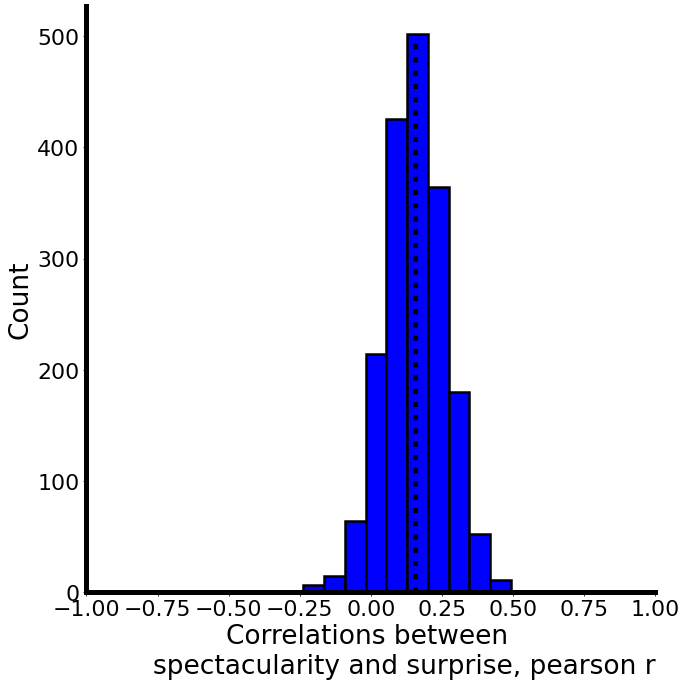

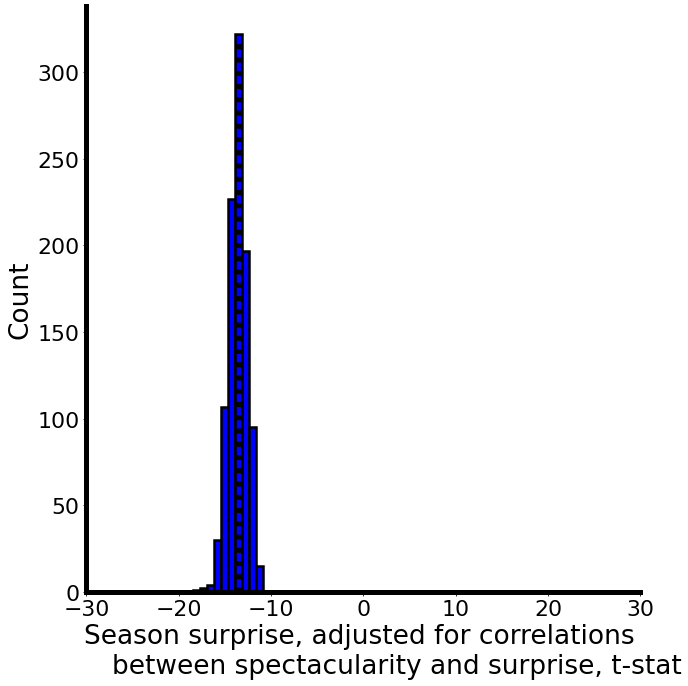

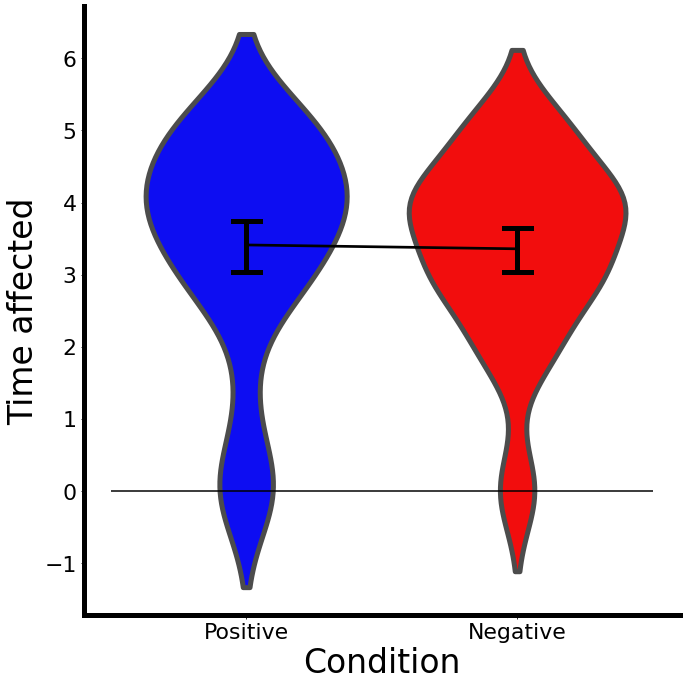

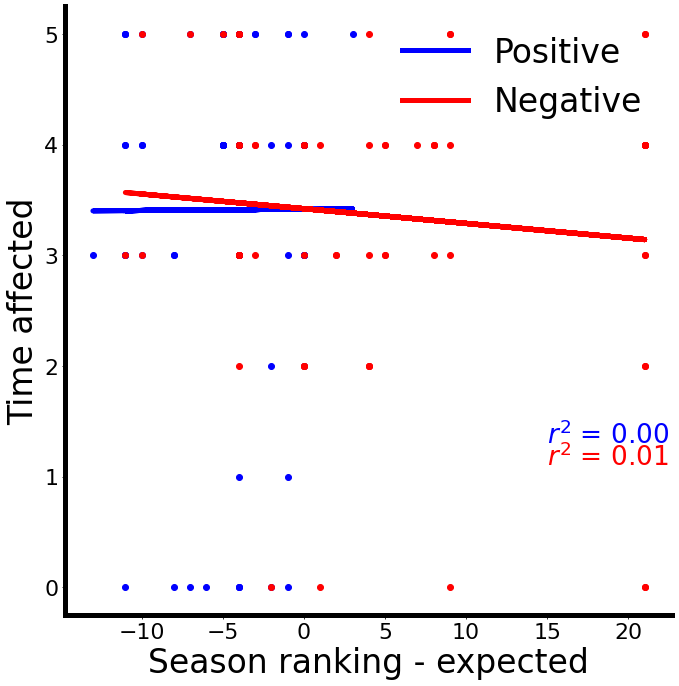

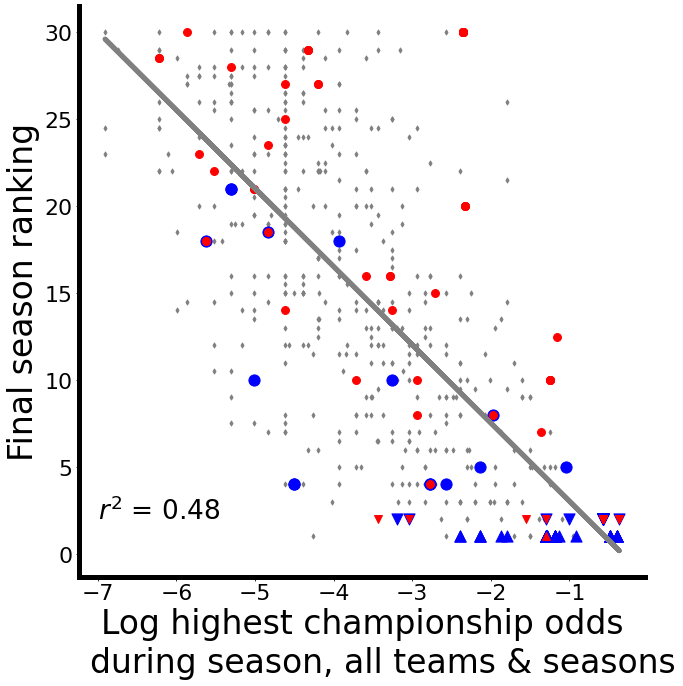

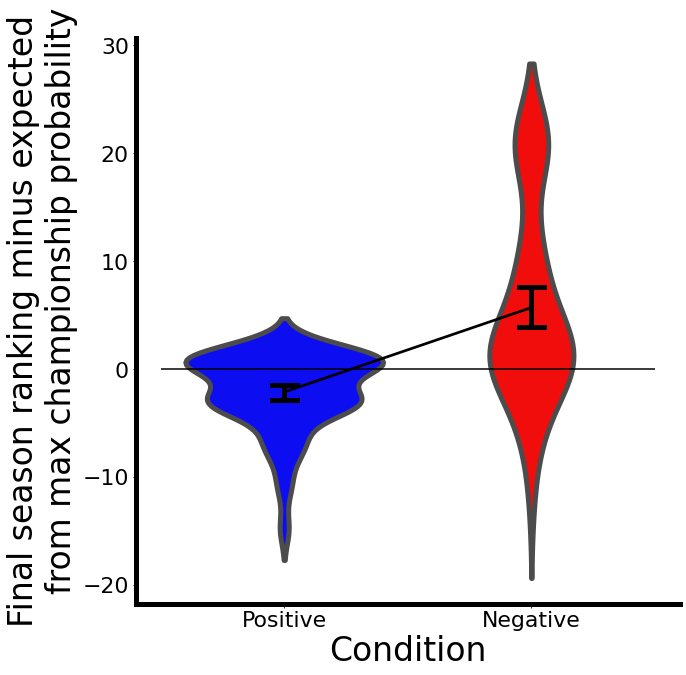

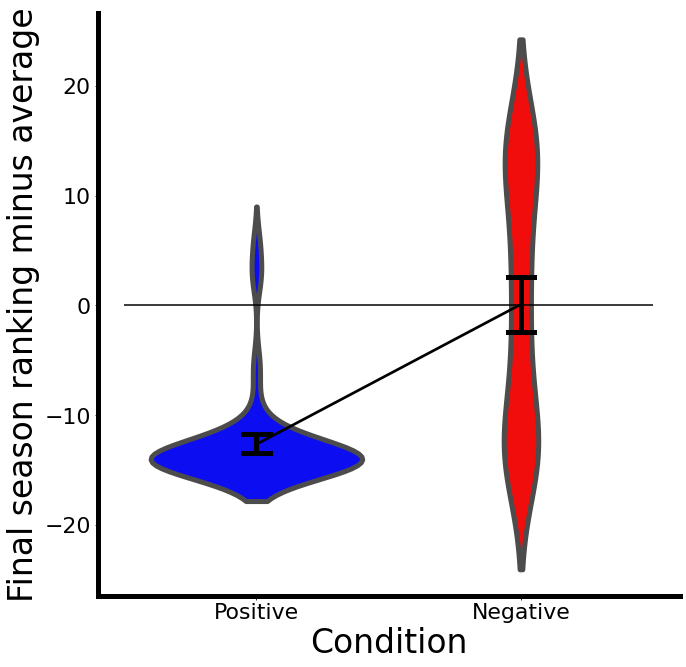

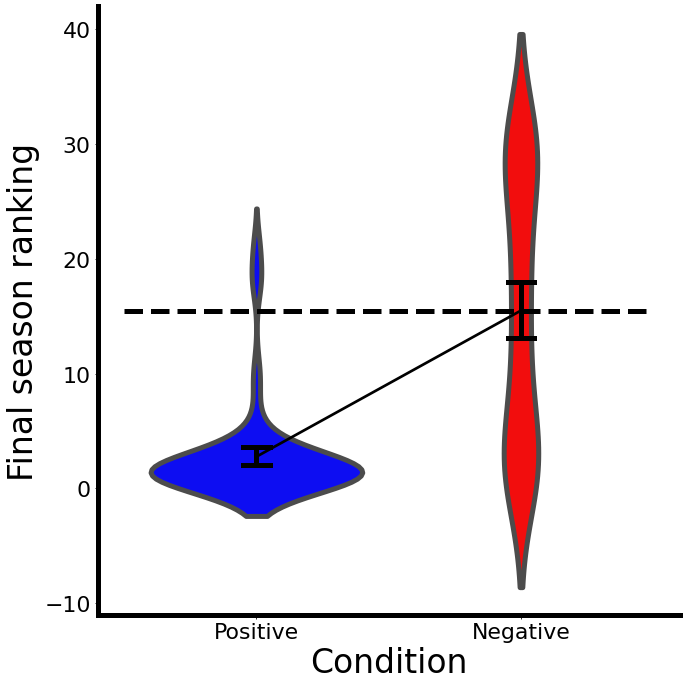

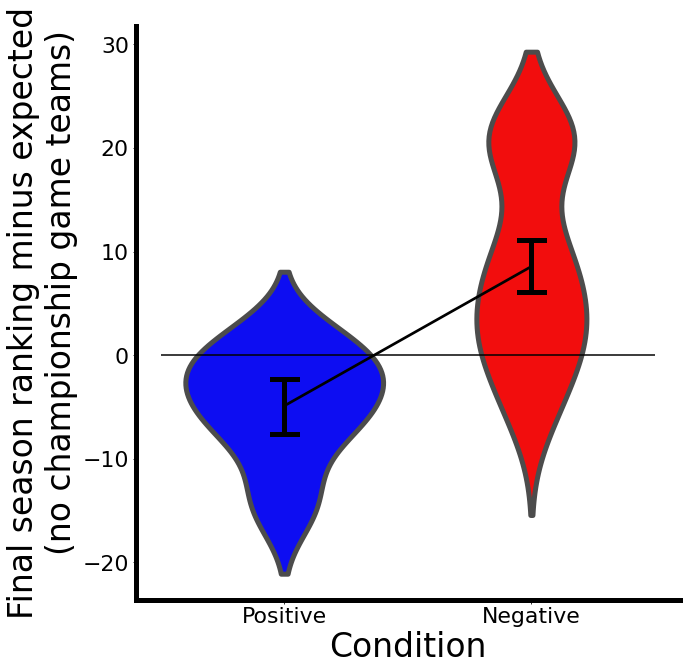

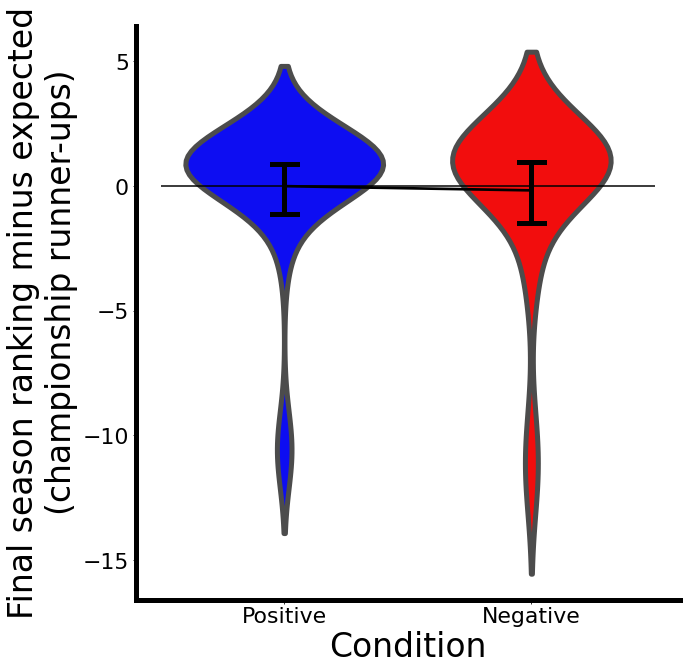

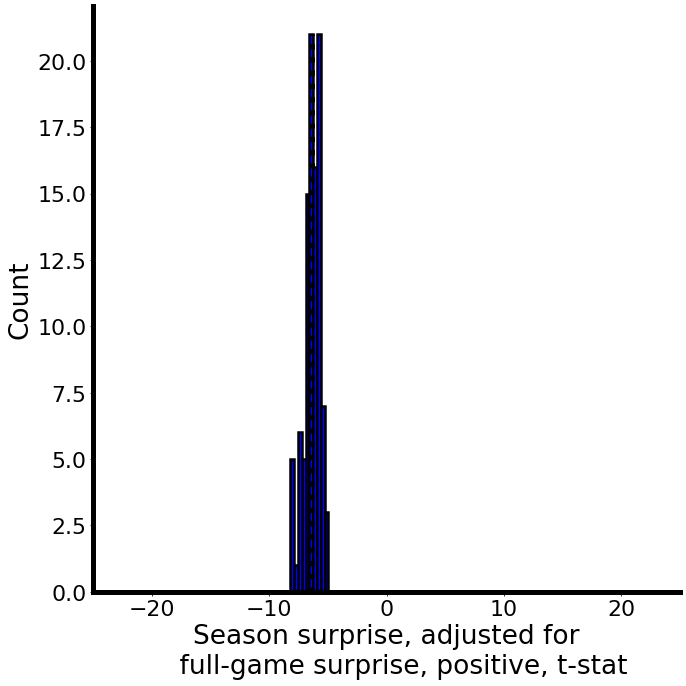

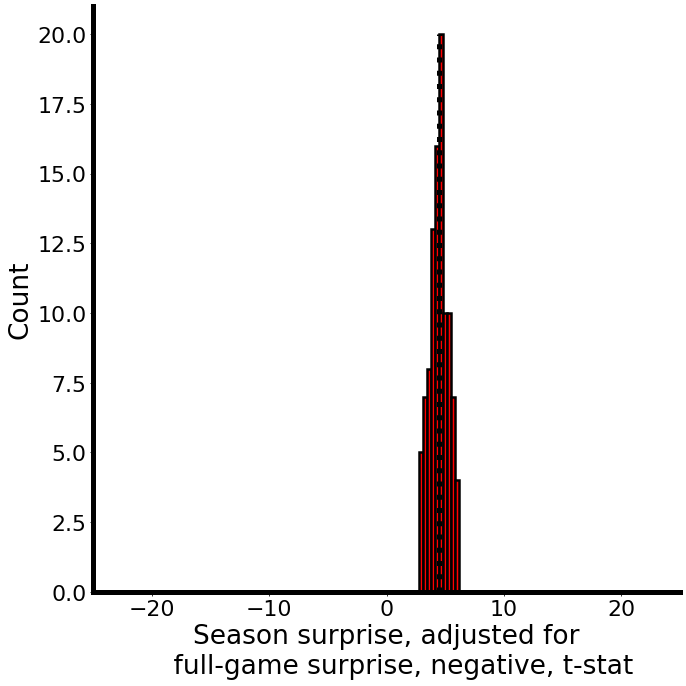

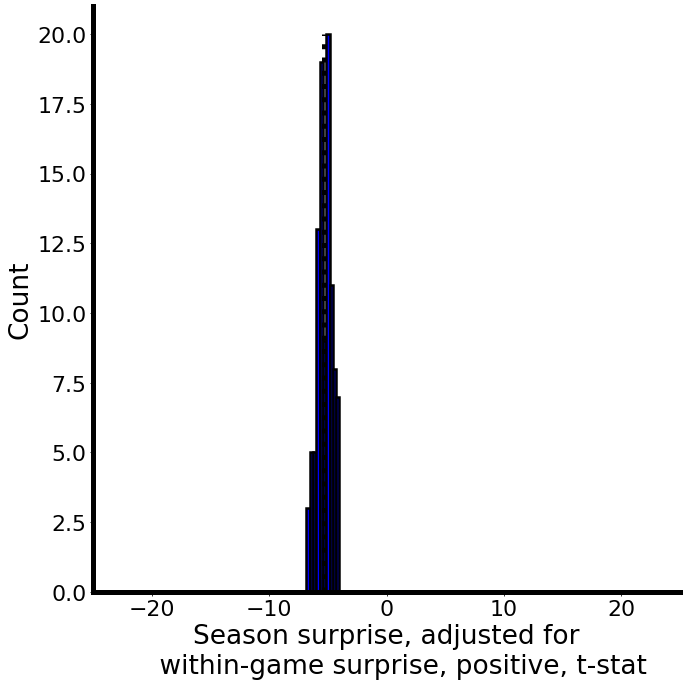

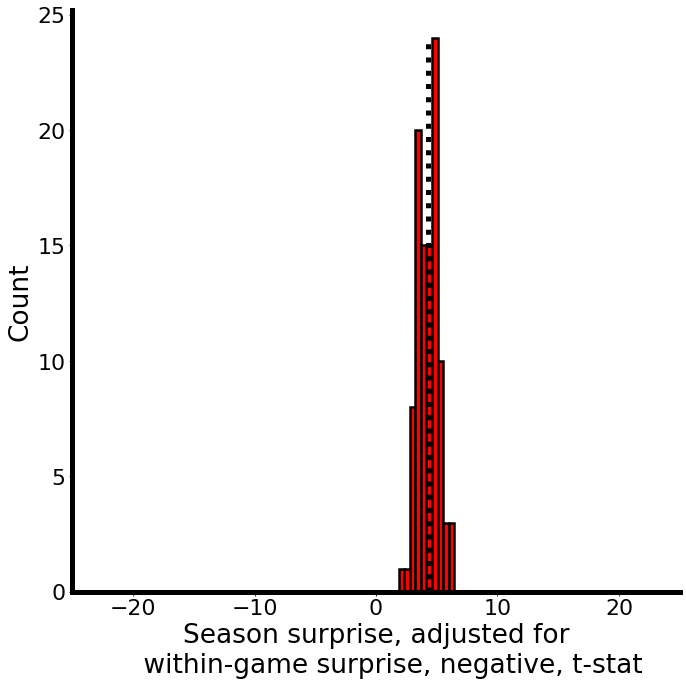

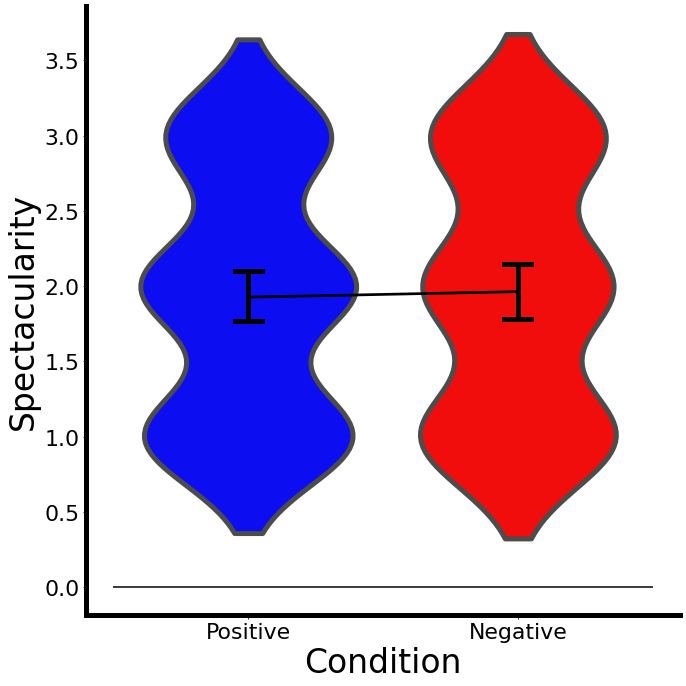

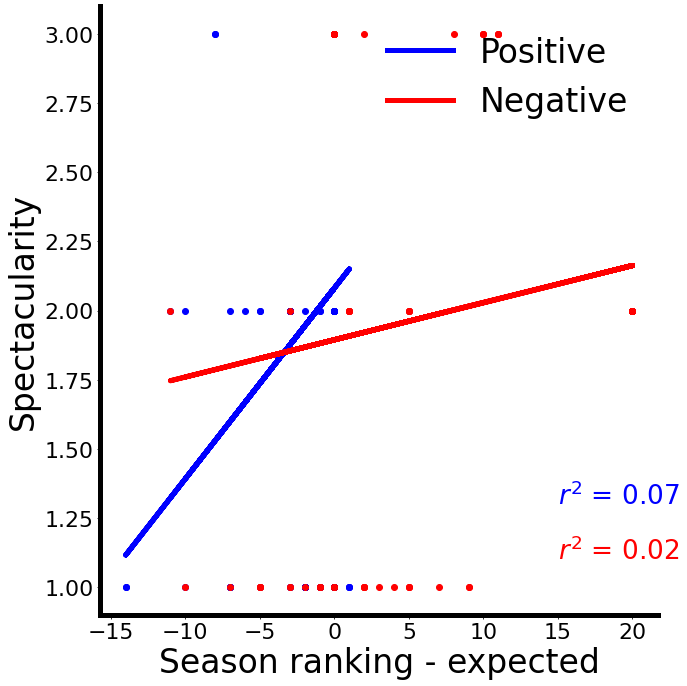

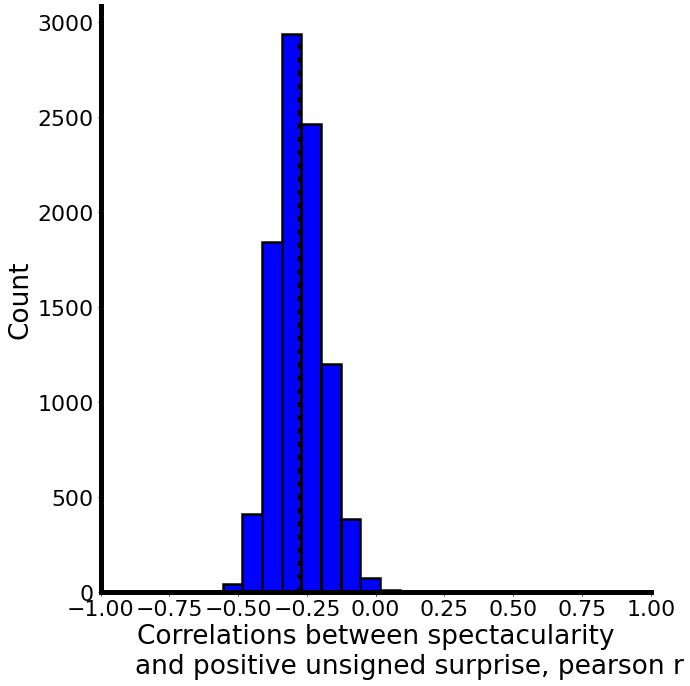

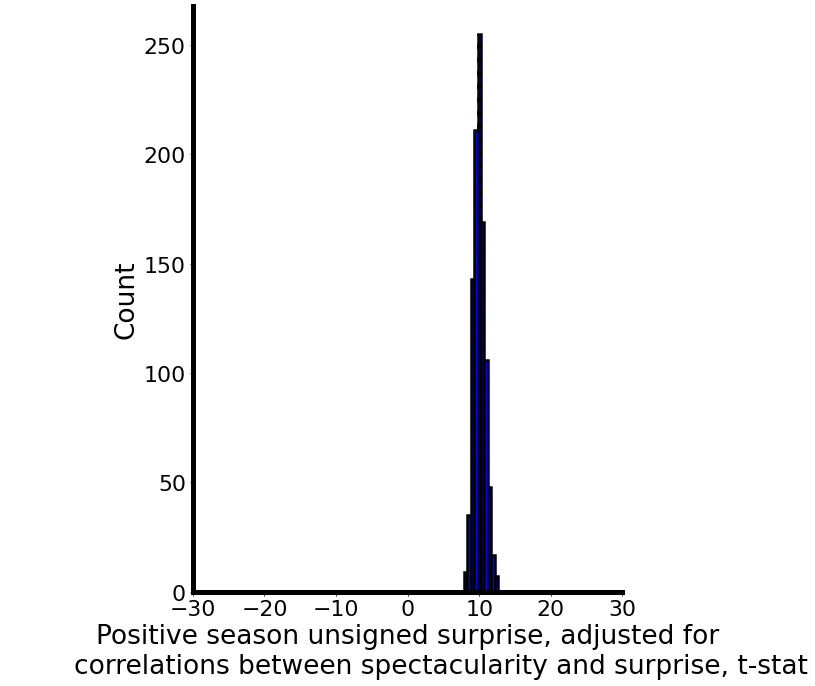

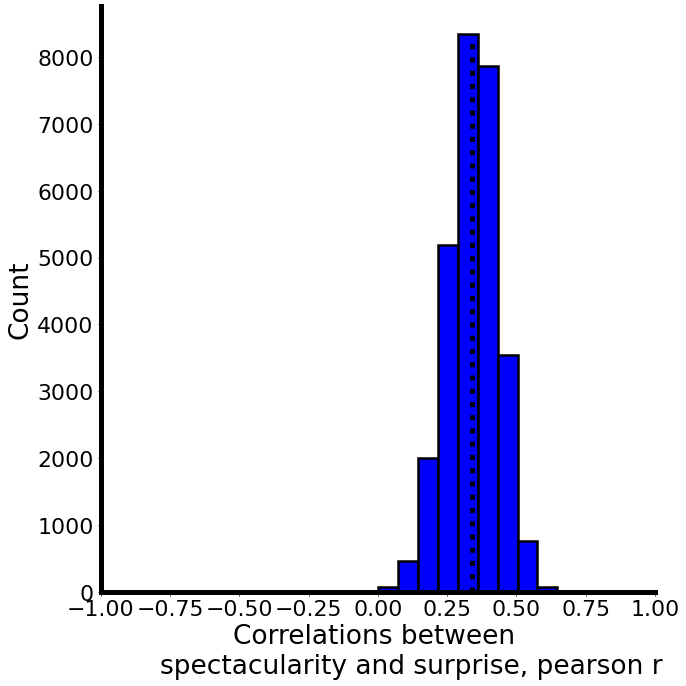

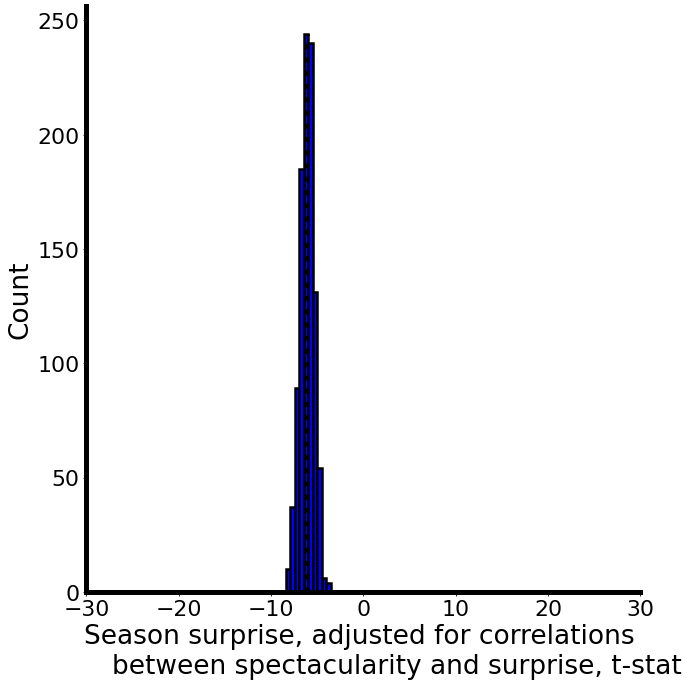

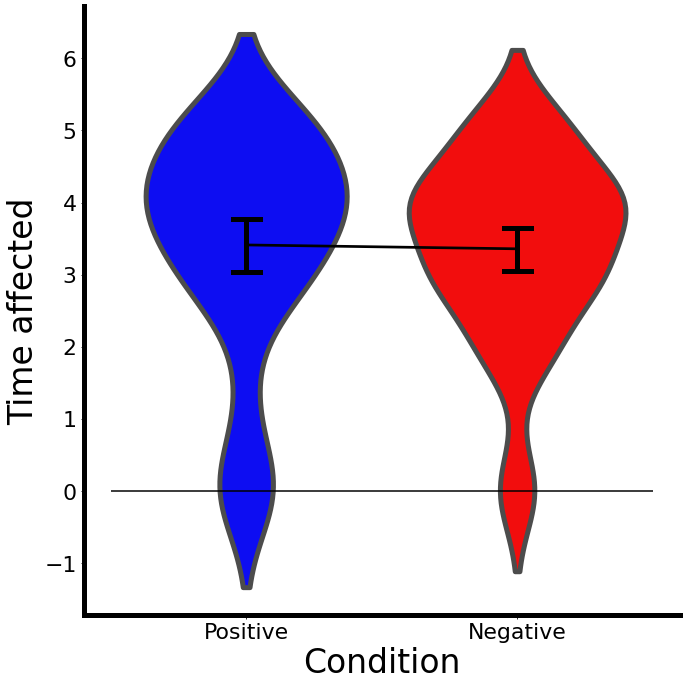

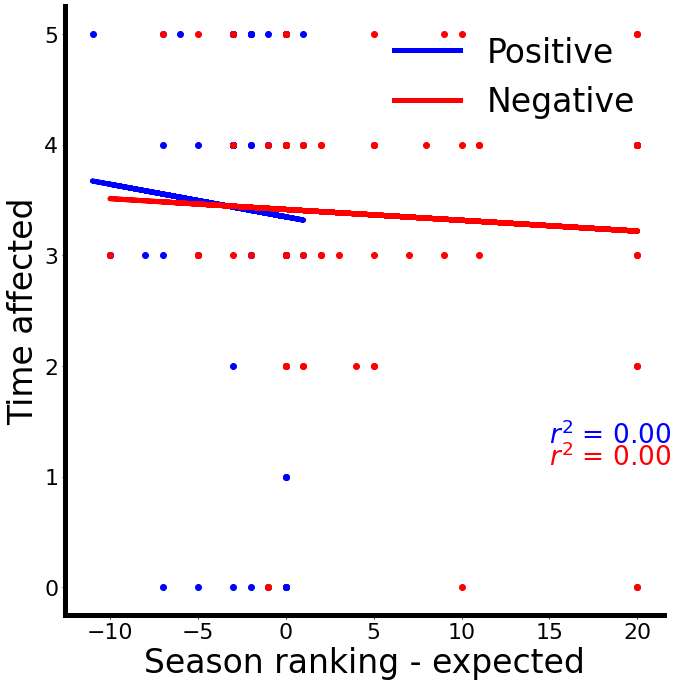

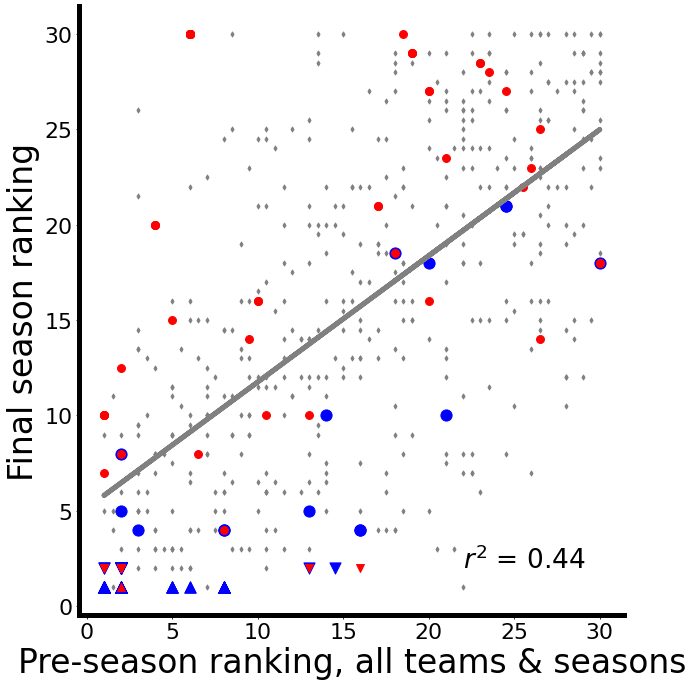

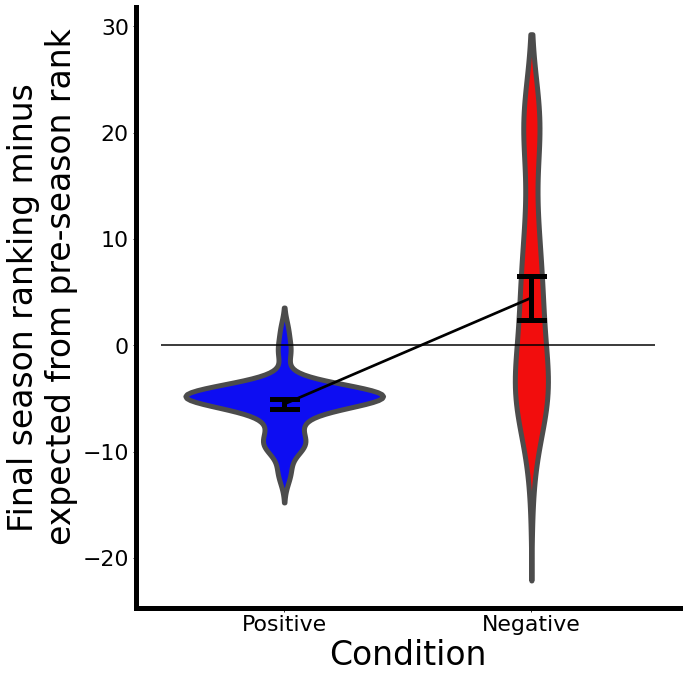

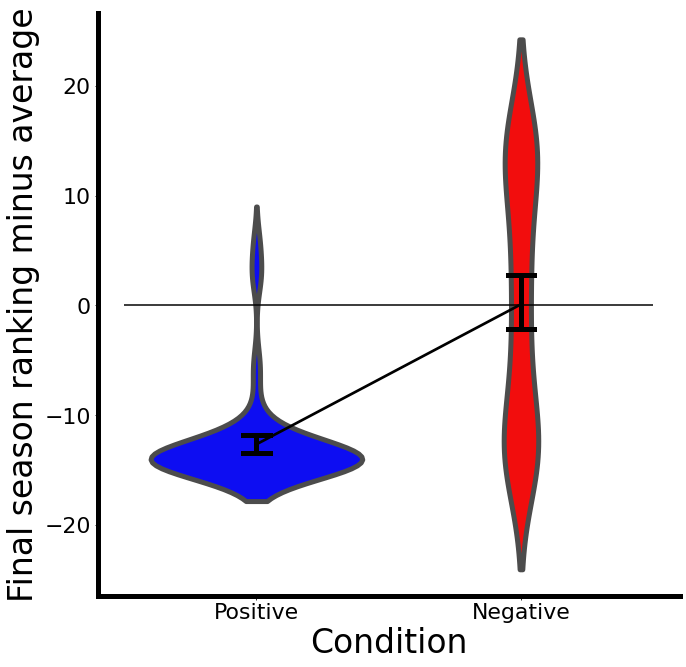

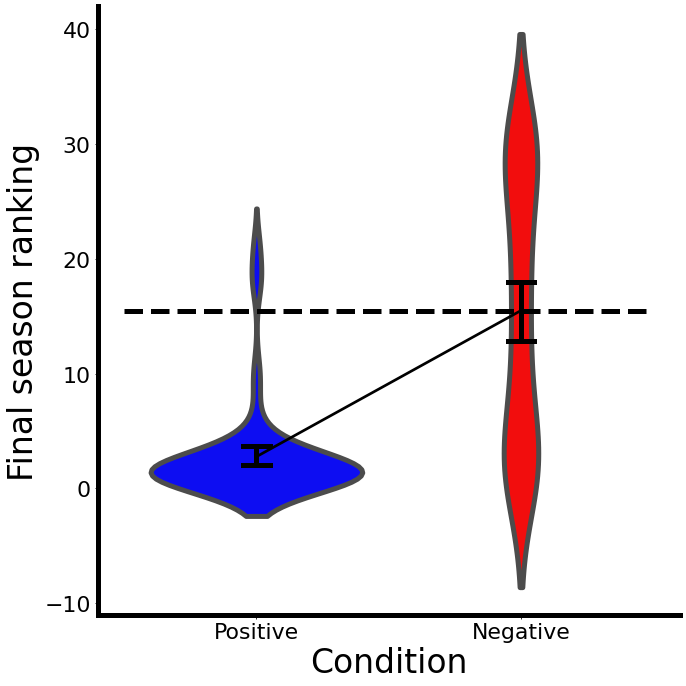

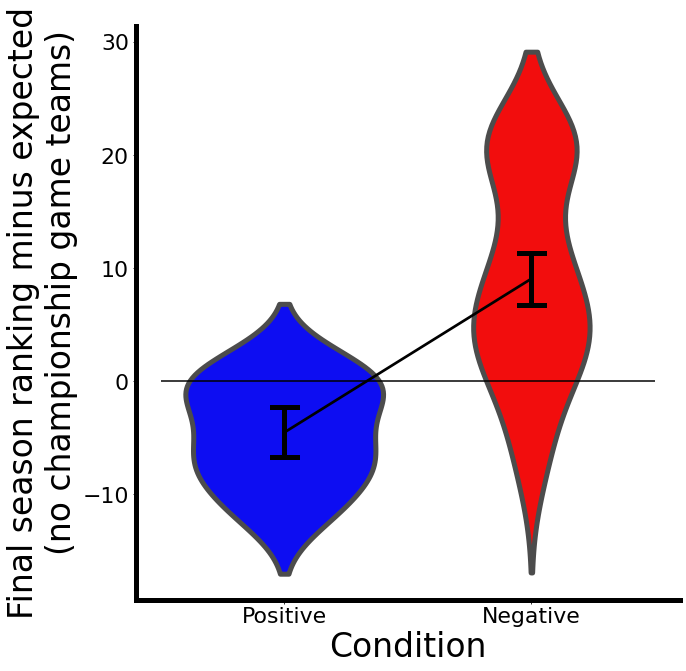

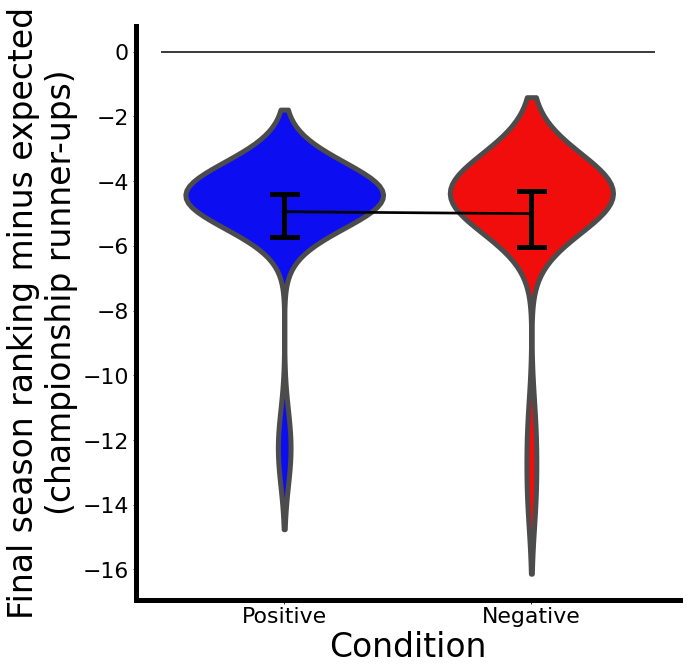

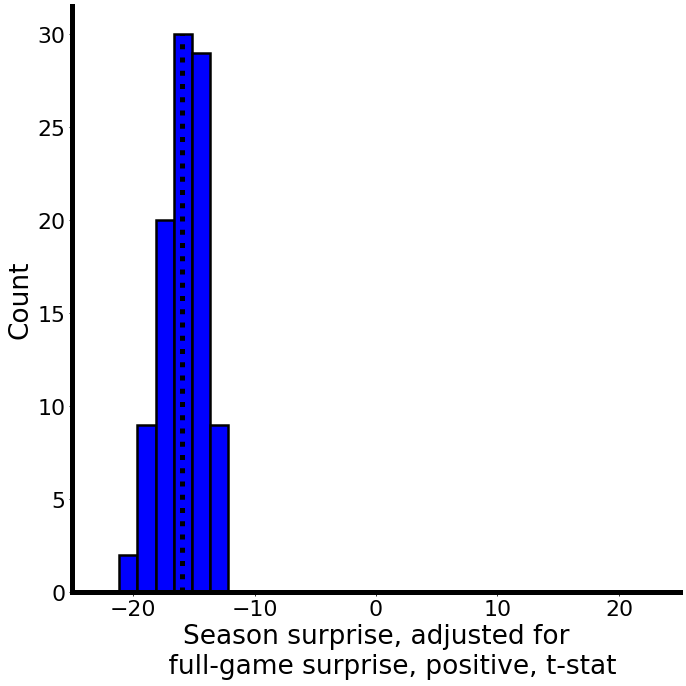

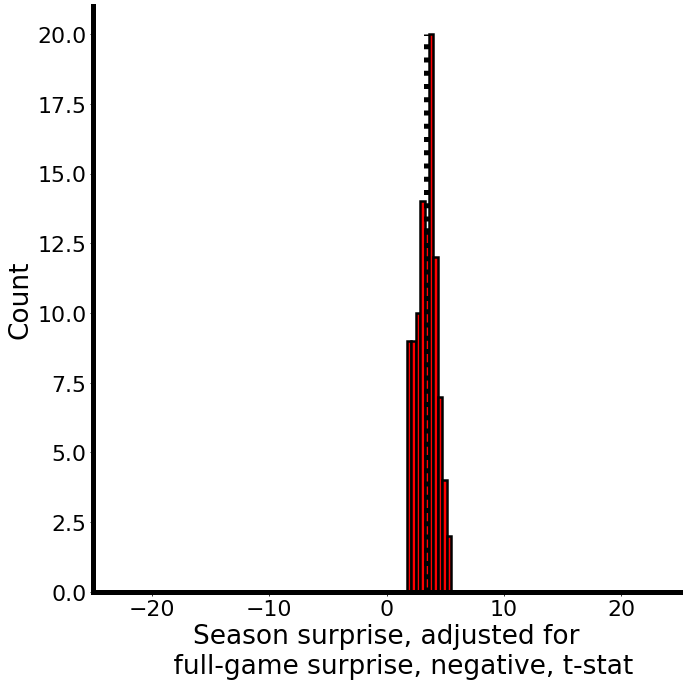

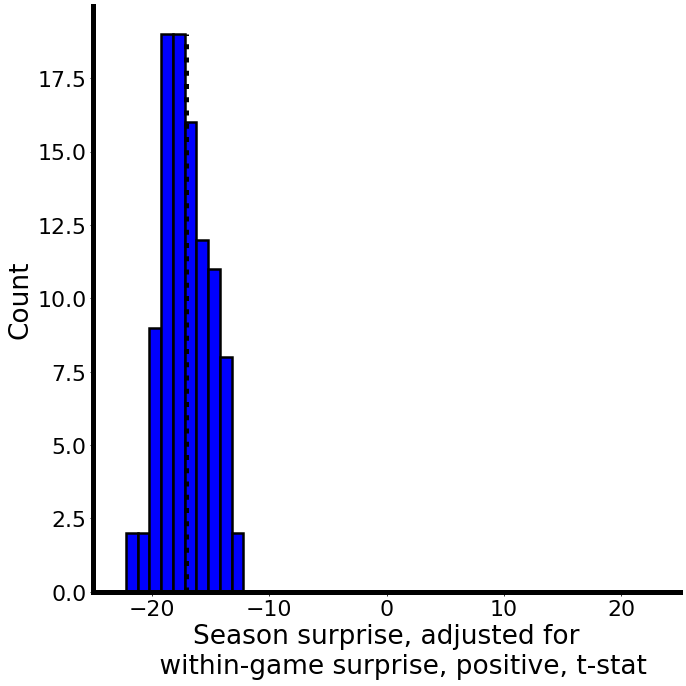

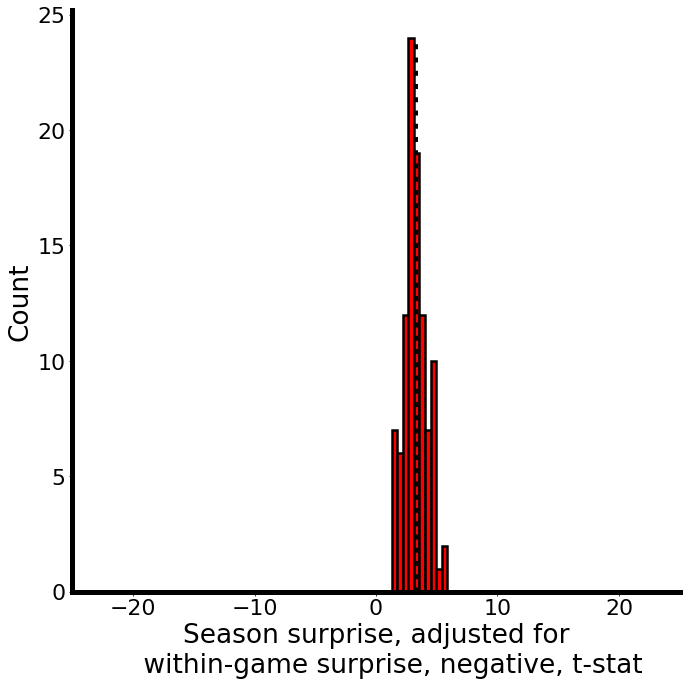

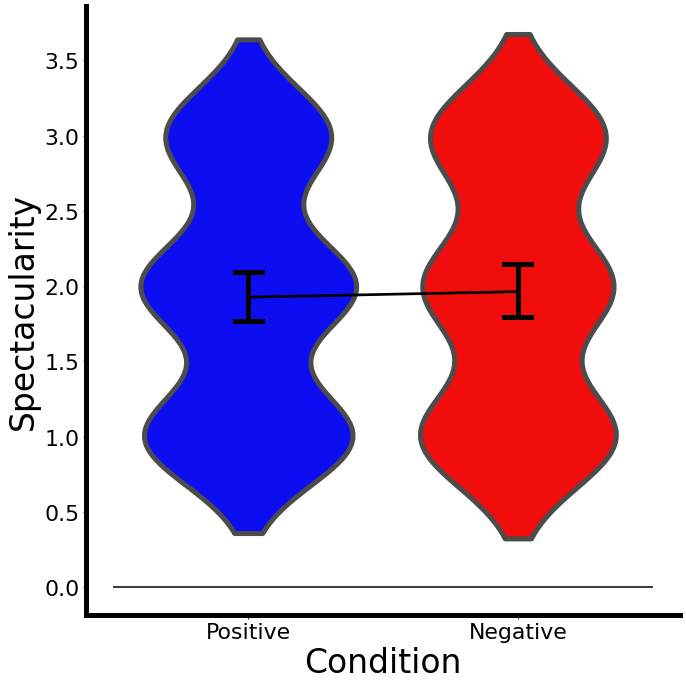

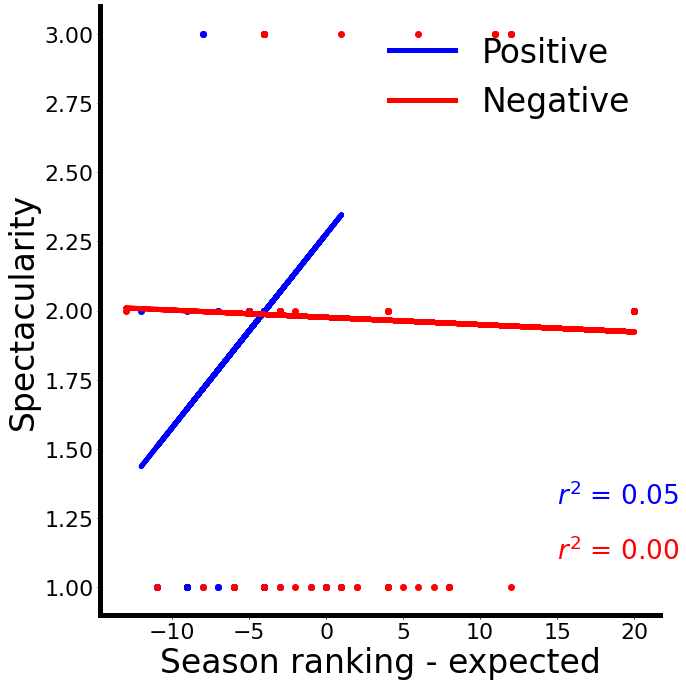

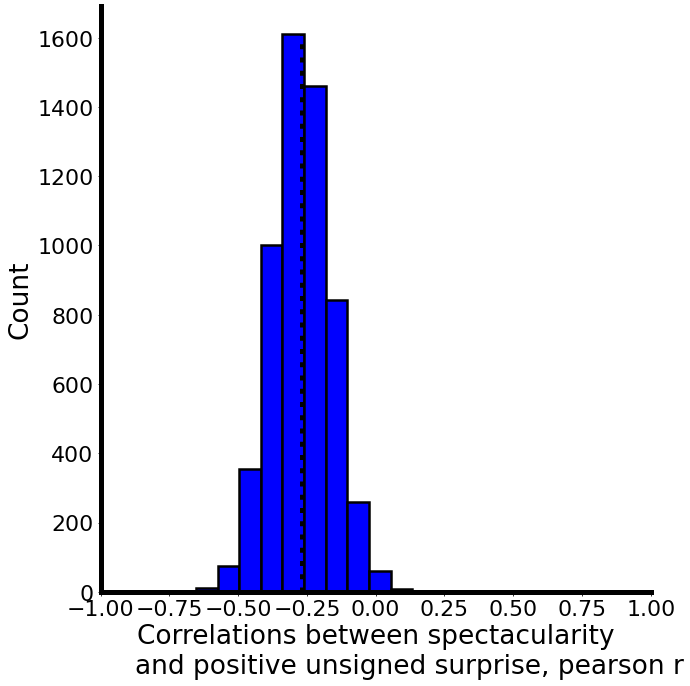

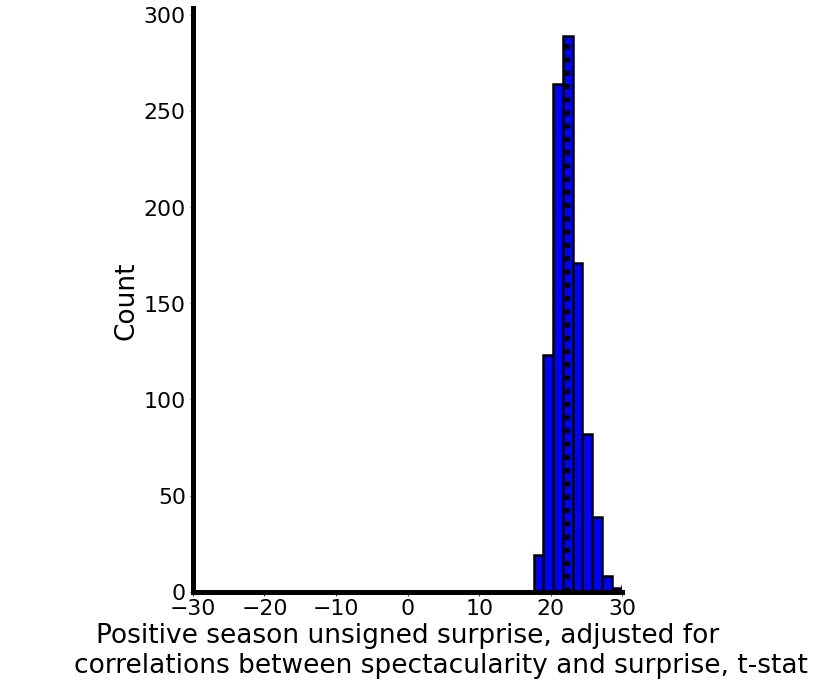

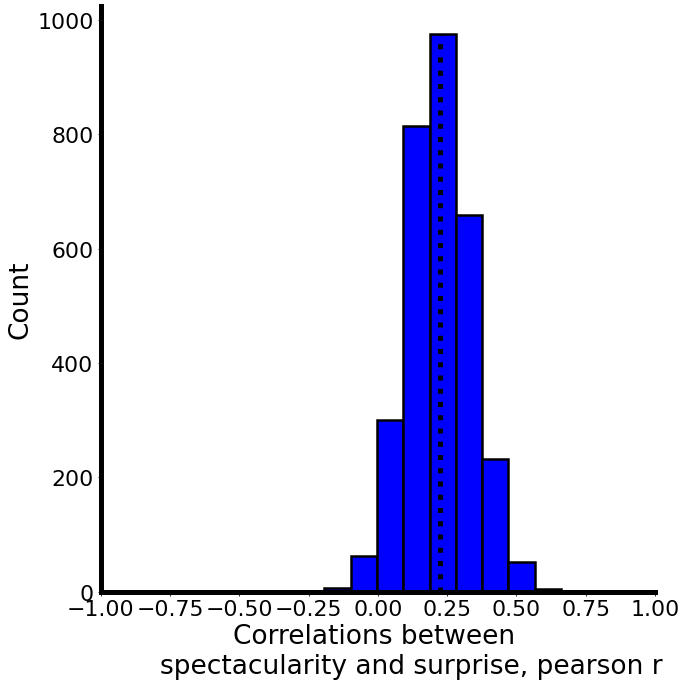

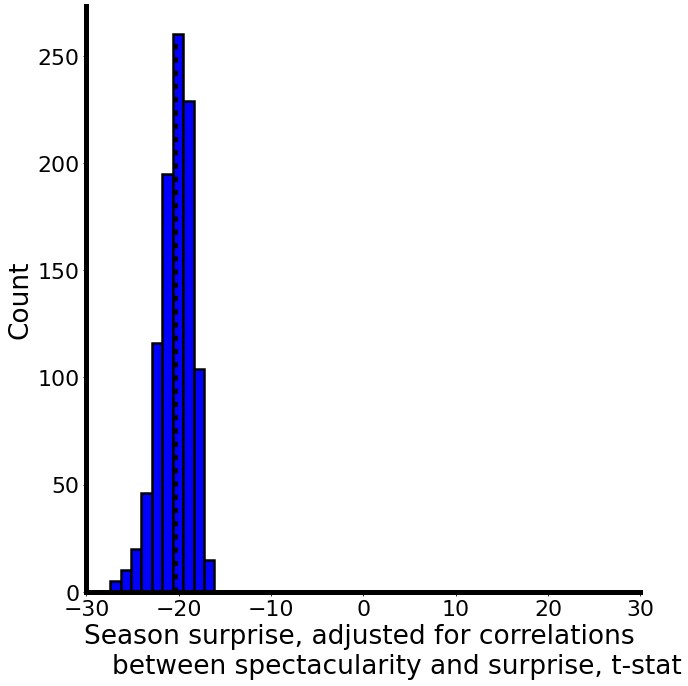

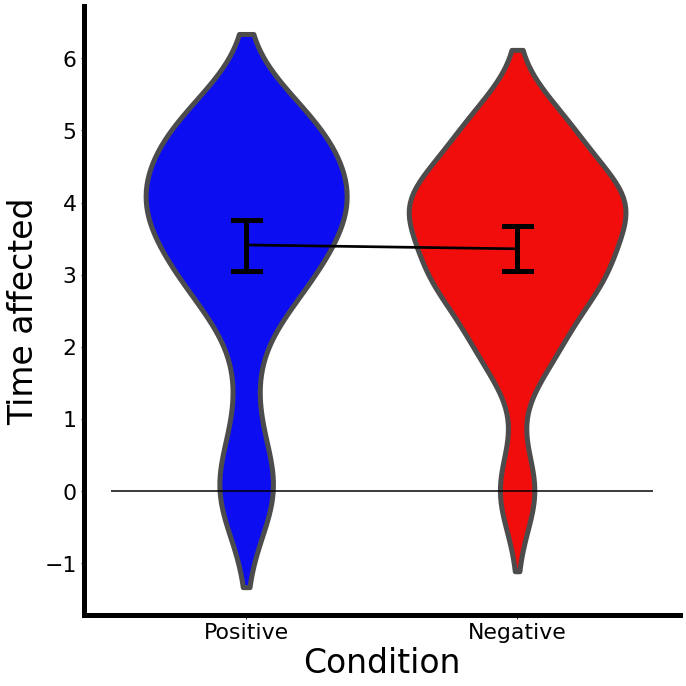

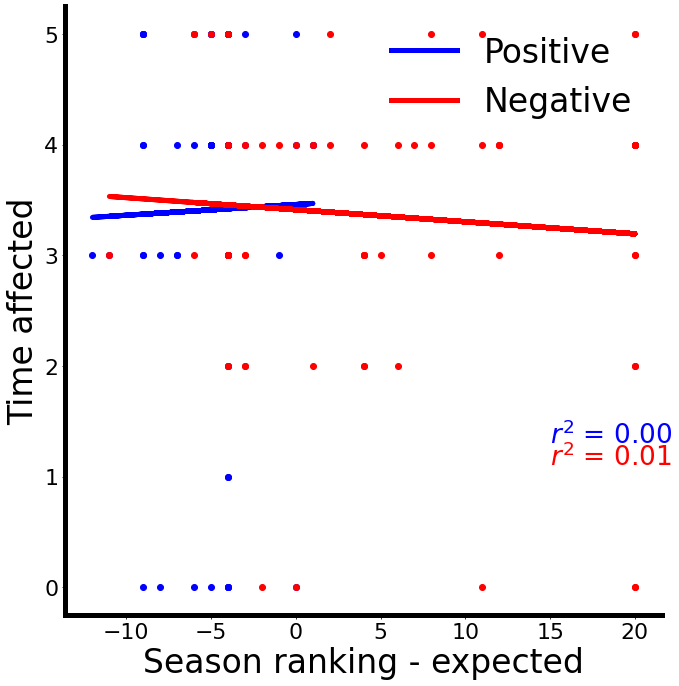

In [ ]:
# relationship between pre_odds and record
# re-run this using different predictor (input variable (inv)) values and outv=2
# organized as big loop to do all analyses using the same inv before proceeding
invs=[1,3,4] #which odds to use: 1=pre-season,2=lowest in season,3=highest in season,4=pre_rank
outv=2 #outcome variable: 1=regular season record,2=season ranking

final_record=df_svr['Win %'].values
pre_rank_a=np.matrix.flatten(pre_ranks)
final_rank=np.matrix.flatten(rank_ys)
sz=125
for invn in range(len(invs)):
    inv=invs[invn]
    if inv<4:
        if inv==1:
            q=df_ots['Pre3'].values
        elif inv==2:
            q=df_ots['low_odds'].values
        elif inv==3:
            q=df_ots['hi_odds'].values
        odds_a=np.zeros((len(df_ots)))
        odds_a[q>0]=100/(100+q[q>0])
        odds_a[q<=0]=np.absolute(q[q<=0])/(100+np.absolute(q[q<=0]))
        if inv==1:
            x_a,x_p,x_n=np.log(odds_a)+0,np.log(pre_oddsp)+0,np.log(pre_oddsn)+0
            xl='''Log pre-season championship
    probability, all teams & seasons'''
        elif inv==2:
            x_a,x_p,x_n=np.log(odds_a)+0,np.log(low_oddsp)+0,np.log(low_oddsn)+0
            xl='''Log lowest championship probabillity
    during season, all teams & seasons'''
        elif inv==3:
            x_a,x_p,x_n=np.log(odds_a)+0,np.log(hi_oddsp)+0,np.log(hi_oddsn)+0
            xl='''Log highest championship odds
    during season, all teams & seasons'''
    elif inv==4:
        x_a,x_p,x_n=pre_rank_a+0,pre_rankp+0,pre_rankn+0
        xl='''Pre-season ranking, all teams & seasons'''

    if outv==1:
        y_a,y_p,y_n=final_record+0,recordp+0,recordn+0
        yl='Season win %, all teams & seasons'
    elif outv==2:
        y_a,y_p,y_n=final_rank+0,rankp+0,rankn+0
        yl='Final season ranking'

    f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
    x,y,lw3=x_a,y_a,2
    plt.scatter(x,y,c='gray',marker='d',s=sz*0.1)
    a,b=np.polyfit(x,y,1)
    plt.plot(x, a*x+b,'gray',linewidth=lw)
    ax.set_xlabel(xl,fontsize=fs)
    ax.set_ylabel(yl,fontsize=fs)
    corr, corr_p = pearsonr(x,y)
    print('r-squared = %s, p = %s' %(corr**2,corr_p))

    x,y=x_p[wonchampp+lostchampp==0],y_p[wonchampp+lostchampp==0] #add positive seasons
    plt.scatter(x,y,c='b',marker='o',s=sz)
    x,y=x_p[wonchampp==1],y_p[wonchampp==1] 
    plt.scatter(x,y,c='b',marker='^',s=sz)
    x,y=x_p[lostchampp==1],y_p[lostchampp==1] 
    plt.scatter(x,y,c='b',marker='v',s=sz)

    x,y=x_n[wonchampn+lostchampn==0],y_n[wonchampn+lostchampn==0] 
    plt.scatter(x,y,c='r',marker='o',s=sz*0.5)
    x,y=x_n[wonchampn==1],y_n[wonchampn==1] 
    plt.scatter(x,y,c='r',marker='^',s=sz*0.5)
    x,y=x_n[lostchampn==1],y_n[lostchampn==1] 
    plt.scatter(x,y,c='r',marker='v',s=sz*0.5)
    if np.logical_and(inv==4,outv==2):
        ax.text(22,2,'$r^{2}$ = %.2f' %corr**2,fontsize=fs*4/5)
    elif np.logical_and(inv==3,outv==2):
        ax.text(-7,2,'$r^{2}$ = %.2f' %corr**2,fontsize=fs*4/5)
    elif np.logical_and(inv==1,outv==2):
        ax.text(-8,2,'$r^{2}$ = %.2f' %corr**2,fontsize=fs*4/5)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(lw)
    f.tight_layout()
    fn='figs/season_odds_records-' + str(inv) + '-' + str(outv) + '.pdf'
    f.savefig(fn, transparent=True)

    ## do contrasts ONLY w/ actual wins - look vs. residual analysis
    x1,y1=x_p+0,y_p+0 # positive seasons
    x2,y2=x_n+0,y_n+0 # negative seasons

    residp=y1-(a*x1+b)
    residn=y2-(a*x2+b)
    residp_val=np.multiply(residp,dfsp['Cheering FOR this team (1) or AGAINST them (-1)'].values)
    residn_val=np.multiply(residn,dfsn['Cheering FOR this team (1) or AGAINST them (-1)'].values)

    residp_vsavg=y1-np.mean(y_a)
    residn_vsavg=y2-np.mean(y_a)
    residp_vsavg=np.multiply(residp_vsavg,dfsp['Cheering FOR this team (1) or AGAINST them (-1)'].values)
    residn_vsavg=np.multiply(residn_vsavg,dfsn['Cheering FOR this team (1) or AGAINST them (-1)'].values)

    if outv==1:
        yl='''Wins minus expected x valence'''
        yl2='''Season win % x valence'''
        yl3='''Season win %'''
        yl4='''Season win %
    (no championship game teams)'''
        yl4='''Season win %
    (championship runner-ups)'''
    elif outv==2:
        if inv==1:
            yl='''Final season ranking minus expected
    from pre-season probability'''
        elif inv==3:
            yl='''Final season ranking minus expected
    from max championship probability'''
        elif inv==4:
            yl='''Final season ranking minus
    expected from pre-season rank'''
        yl2='''Final season ranking minus average'''
        yl3='''Final season ranking'''
        yl4='''Final season ranking minus expected
    (no championship game teams)'''
        yl5='''Final season ranking minus expected
    (championship runner-ups)'''
        yl6='''Final season ranking minus expected
    (no 2016)'''
        yl7='''Final season ranking minus expected
    (no GSW)'''
        yl8='''Final season ranking minus expected
    (GSW)'''
        
    fn='figs/season_actualVexpected-' + str(inv) + '-' + str(outv) + '.pdf'
    barswarm(residp_val,residn_val,'Residual',yl,fn,0)
    fn='figs/season_actualXvalence-' + str(inv) + '-' + str(outv) + '.pdf'
    barswarm(residp_vsavg,residn_vsavg,'Actual',yl2,fn,0)
    fn='figs/season_actual-' + str(inv) + '-' + str(outv) + '.pdf'
    barswarm(y1,y2,'Actual',yl3,fn,3)
    qp,qn=np.where((wonchampp+lostchampp)==0)[0],np.where((wonchampn+lostchampn)==0)[0]
    fn='figs/season_actualVexpectedXvalence_nochamp-' + str(inv) + '-' + str(outv) + '.pdf'
    barswarm(residp_val[qp],residn_val[qn],'ResidualNoChamp',yl4,fn,0)
    qp,qn=np.where((lostchampp)==1)[0],np.where((lostchampn)==1)[0]
    fn='figs/season_actualVexpectedXvalence_runnerups-' + str(inv) + '-' + str(outv) + '.pdf'
    barswarm(residp_val[qp],residn_val[qn],'ResidualRunnerups',yl5,fn,0)

    astats1(residp_val,0,'szn sur, resid, pos vs null')
    astats1(y1,np.mean(y_a),'szn sur, actual, pos vs null')
    astats1(residn_val,0,'szn sur, resid, neg vs null')
    astats1(y2,np.mean(y_a),'szn sur, actual, neg vs null')

    astats2(residp_val,residn_val,'szn sur, resid, pos vs neg')
    astats2(y1,y2,'szn sur, actual, pos vs neg')

    qp,qn=np.where((wonchampp+lostchampp)==0)[0],np.where((wonchampn+lostchampn)==0)[0]
    astats1(residp_val[qp],0,'szn sur, resid, no champ game, pos vs null')
    astats1(residn_val[qn],0,'szn sur, resid, no champ game, neg vs null')
    
    #permutation analysis equating max full-game / within-game surprise
    iters,n_iters,pthr=0,100,0.1
    adj_tstats_sp_wgp,adj_pvals_sp_wgp=np.zeros((n_iters)),np.zeros((n_iters))
    adj_tstats_sp_fgp,adj_pvals_sp_fgp=np.zeros((n_iters)),np.zeros((n_iters))
    adj_tstats_sn_wgn,adj_pvals_sn_wgn=np.zeros((n_iters)),np.zeros((n_iters))
    adj_tstats_sn_fgn,adj_pvals_sn_fgn=np.zeros((n_iters)),np.zeros((n_iters))
    cumu_sp_wgp,cumu_sn_wgn,cumu_sp_fgp,cumu_sn_fgn=[],[],[],[] #cumulative distributions
    while iters<n_iters:
        #positive full-game first
        nv=mxfgsurp.shape[0]
        q0=np.random.choice(nv,nv*2//3) #couldn't do w/ full sample!
        qval=mxfgsurp[q0]
        stat,pval=ttest_ind(mxfgsurs,qval,nan_policy='omit')
        if pval>pthr:
            stat,pval=stats.ttest_1samp(residp_val[q0],popmean=0,nan_policy='omit')
            adj_tstats_sp_fgp[iters]=stat
            adj_pvals_sp_fgp[iters]=pval
            cumu_sp_fgp=np.hstack([cumu_sp_fgp,residp_val[q0]])
            iters+=1

    iters=0
    while iters<n_iters:
        nv=mxwgsurp.shape[0]
        q0=np.random.choice(nv,nv*2//3) 
        qval=mxwgsurp[q0]
        stat,pval=ttest_ind(mxwgsurs,qval,nan_policy='omit')
        if pval>pthr:
            stat,pval=stats.ttest_1samp(residp_val[q0],popmean=0,nan_policy='omit')
            adj_tstats_sp_wgp[iters]=stat
            adj_pvals_sp_wgp[iters]=pval
            cumu_sp_wgp=np.hstack([cumu_sp_wgp,residp_val[q0]])
            iters+=1
            
    iters=0
    while iters<n_iters:
        nv=mxfgsurn.shape[0]
        q0=np.random.choice(nv,nv*2//3) 
        qval=mxfgsurn[q0]
        stat,pval=ttest_ind(mxfgsurs,qval,nan_policy='omit')
        if pval>pthr:
            stat,pval=stats.ttest_1samp(residn_val[q0],popmean=0,nan_policy='omit')
            adj_tstats_sn_fgn[iters]=stat
            adj_pvals_sn_fgn[iters]=pval
            cumu_sn_fgn=np.hstack([cumu_sn_fgn,residn_val[q0]])
            iters+=1

    iters=0
    while iters<n_iters:
        nv=mxwgsurn.shape[0]
        q0=np.random.choice(nv,nv*2//3) 
        qval=mxwgsurn[q0]
        stat,pval=ttest_ind(mxwgsurs,qval,nan_policy='omit')
        if pval>pthr:
            stat,pval=stats.ttest_1samp(residn_val[q0],popmean=0,nan_policy='omit')
            adj_tstats_sn_wgn[iters]=stat
            adj_pvals_sn_wgn[iters]=pval
            cumu_sn_wgn=np.hstack([cumu_sn_wgn,residn_val[q0]])
            iters+=1

    qq=adj_pvals_sp_fgp<0.05
    print('pos, adj for fg, #sig:%s' %(np.sum(qq)/len(adj_pvals_sp_fgp)))
    qq=adj_pvals_sn_fgn<0.05
    print('neg, adj for fg, #sig:%s' %(np.sum(qq)/len(adj_pvals_sn_fgn)))
    qq=adj_pvals_sp_wgp<0.05
    print('pos, adj for wg, #sig:%s' %(np.sum(qq)/len(adj_pvals_sp_wgp)))
    qq=adj_pvals_sn_wgn<0.05
    print('neg, adj for wg, #sig:%s' %(np.sum(qq)/len(adj_pvals_sn_wgn)))

    adj_histo(adj_tstats_sp_fgp,25,'b','''Season surprise, adjusted for
    full-game surprise, positive''','figs/season_adj_histo_fgsurp-'+str(inv)+'.pdf')
    adj_histo(adj_tstats_sn_fgn,25,'r','''Season surprise, adjusted for
    full-game surprise, negative''','figs/season_adj_histo_fgsurn-'+str(inv)+'.pdf')
    adj_histo(adj_tstats_sp_wgp,25,'b','''Season surprise, adjusted for
    within-game surprise, positive''','figs/season_adj_histo_wgsurp-'+str(inv)+'.pdf')
    adj_histo(adj_tstats_sn_wgn,25,'r','''Season surprise, adjusted for
    within-game surprise, negative''','figs/season_adj_histo_wgsurn-'+str(inv)+'.pdf')

    #spectacularity
    dfsp['x'],dfsn['x']=x_p,x_n
    dfsp['y'],dfsn['y'],dfsp['y_res'],dfsn['y_res']=y_p,y_n,residp_val,residn_val
    act_resid=2 #actual vs residual outcome
    if act_resid==1:
        ystr1,ybr1='y','Season ranking'
    else:
        ystr1,ybr1='y_res','Season ranking - expected'
    ystr2,ybr2='Spectacularity','Spectacularity'
    qp=np.where(dfsp[ystr2].isna()==0)[0]
    qn=np.where(dfsn[ystr2].isna()==0)[0]
    x1,x2=dfsp[ystr1].values,dfsn[ystr1].values
    y1,y2=dfsp[ystr2].values,dfsn[ystr2].values

    fn='figs/season_'+str(ybr2)+'.pdf'
    barswarm(y1[qp],y2[qn],ybr2,ybr2,fn,0)

    astats3(y1[qp],y2[qn],'season spectacularity, pos vs neg')

    corr, pval = pearsonr(x1[qp],y1[qp])
    print('r-squared,positive = %s, pval = %s' %(corr**2,pval))
    corr, pval = pearsonr(x2[qn],y2[qn])
    print('r-squared,negative = %s, pval = %s' %(corr**2,pval))
    corr, pval = pearsonr(np.absolute(x1[qp]),y1[qp])
    print('r-squared,unsigned,positive = %s, pval = %s' %(corr**2,pval))
    corr, pval = pearsonr(np.absolute(x2[qn]),y2[qn])
    print('r-squared,unsigned,negative = %s, pval = %s' %(corr**2,pval))

    scatterp(x1[qp].astype(int),y1[qp].astype(int),x2[qn].astype(int),y2[qn].astype(int),
            ybr1,ybr2,'figs/season_'+str(ystr1)+'_'+str(ystr2)+'.pdf',2)
    
    #address positive relationship between pos season surprise and spect
    #unsigned
    x1=np.absolute(dfsp[ystr1].values)
    y1=dfsp[ystr2].values
    iters,outer_iters,n_iters,pthr=0,0,1000,0.1
    adj_tstats_r_sp_un,adj_tstats_pvals_sp_un=np.zeros((n_iters)),np.zeros((n_iters))
    cumu_r_sp_un,r_rvals_sp_un=[],[] #cumulative distributions
    qp=np.where(dfsp[ystr2].isna()==0)[0]
    while iters<n_iters:
        nv=qp.shape[0]
        q0=np.random.choice(nv,nv)
        corr, pval = pearsonr(x1[qp[q0]],y1[qp[q0]])
        r_rvals_sp_un=np.hstack([r_rvals_sp_un,corr])
        outer_iters+=1
        if pval>pthr:
            if iters==0:
                print(x1[qp[q0]])
            stat,pval=stats.ttest_1samp(x1[qp[q0]],popmean=0)
            adj_tstats_r_sp_un[iters]=stat
            adj_tstats_pvals_sp_un[iters]=pval
            cumu_r_sp_un=np.hstack([cumu_r_sp_un,x1[qp[q0]]])
            iters+=1

    print('% non-sig corrs:',iters/outer_iters)
    qq=adj_tstats_pvals_sp_un<0.05
    print('pos, adj for spect, #sig:%s' %(np.sum(qq)/len(adj_tstats_pvals_sp_un)))
    adj_histo(r_rvals_sp_un,1,'b','''Correlations between spectacularity
        and positive unsigned surprise''','figs/season_r_spect_surs-'+str(inv)+'.pdf') 
    adj_histo(adj_tstats_r_sp_un,30,'b','''Positive season unsigned surprise, adjusted for
        correlations between spectacularity and surprise''','figs/season_adj_histo_r_spect_sur-'+str(inv)+'.pdf')

    #signed
    x1=dfsp[ystr1].values
    y1=dfsp[ystr2].values
    iters,outer_iters,n_iters,pthr=0,0,1000,0.1
    adj_tstats_r_sp,adj_tstats_pvals_sp=np.zeros((n_iters)),np.zeros((n_iters))
    cumu_r_sp,r_rvals=[],[] #cumulative distributions
    qp=np.where(dfsp[ystr2].isna()==0)[0]
    while iters<n_iters:
        nv=qp.shape[0]
        q0=np.random.choice(nv,nv)
        corr, pval = pearsonr(x1[qp[q0]],y1[qp[q0]])
        r_rvals=np.hstack([r_rvals,corr])
        outer_iters+=1
        if pval>pthr:
            if iters==0:
                print(x1[qp[q0]])
            stat,pval=stats.ttest_1samp(x1[qp[q0]],popmean=0)
            adj_tstats_r_sp[iters]=stat
            adj_tstats_pvals_sp[iters]=pval
            cumu_r_sp=np.hstack([cumu_r_sp,x1[qp[q0]]])
            iters+=1

    print('% non-sig corrs:',iters/outer_iters)
    qq=adj_tstats_pvals_sp<0.05
    print('pos, adj for spect, #sig:%s' %(np.sum(qq)/len(adj_tstats_pvals_sp)))
    adj_histo(r_rvals,1,'b','''Correlations between 
        spectacularity and surprise''','figs/season_r_spect_surs-'+str(inv)+'.pdf') 
    adj_histo(adj_tstats_r_sp,30,'b','''Season surprise, adjusted for correlations 
        between spectacularity and surprise''','figs/season_adj_histo_r_spect_sur-'+str(inv)+'.pdf')
    
    #time affected
    act_resid=2 #actual vs residual outcome
    if act_resid==1:
        ystr1,ybr1='y','Season ranking'
    else:
        ystr1,ybr1='y_res','Season ranking - expected'
    #ystr1,ybr1='For - against','For - against fandom'
    ystr2,ybr2='How long affected? (1=minutes,2=hours,3=days,4=months,5=still affected)','Time affected'
    qp=np.where(dfsp[ystr2].isna()==0)[0]
    qn=np.where(dfsn[ystr2].isna()==0)[0]
    x1,x2=dfsp[ystr1].values,dfsn[ystr1].values
    y1,y2=dfsp[ystr2].values,dfsn[ystr2].values

    fn='figs/season_'+str(ybr2)+'.pdf'
    barswarm(y1[qp],y2[qn],ybr2,ybr2,fn,0)

    astats3(y1[qp],y2[qn],'time affected, pos vs neg')

    corr, pval = pearsonr(x1[qp],y1[qp])
    print('r-squared,positive = %s, pval = %s' %(corr**2,pval))
    corr, pval = pearsonr(x2[qn],y2[qn])
    print('r-squared,negative = %s, pval = %s' %(corr**2,pval))

    scatterp(x1[qp].astype(int),y1[qp].astype(int),x2[qn].astype(int),y2[qn].astype(int),
            ybr1,ybr2,'figs/season_'+str(ystr1)+'_'+str(ystr2)+'.pdf',2)


Time affected, plays
   g1n    g1m    g1s  g1med  g2n    g2m   g2s  g2med   df  stat  tstat      p  \
0   68  3.162  0.145    3.0   73  2.836  0.15    3.0  139  0.12  1.548  0.634   

   p_ttest      d  
0    0.124  0.263  


Time affected, games
   g1n    g1m    g1s  g1med  g2n    g2m    g2s  g2med   df   stat  tstat  \
0   77  3.481  0.134    3.0   74  3.297  0.133    3.0  149  0.097   0.96   

       p  p_ttest      d  
0  0.829    0.338  0.157  


Time affected, seasons
   g1n    g1m    g1s  g1med  g2n    g2m    g2s  g2med   df   stat  tstat  \
0   73  3.411  0.184    4.0   70  3.357  0.155    4.0  141  0.089  0.221   

       p  p_ttest      d  
0  0.908    0.825  0.037  


Emotionality, plays
   g1n    g1m    g1s  g1med  g2n    g2m   g2s  g2med   df   stat   tstat    p  \
0   70  1.957  0.149    2.0   74 -1.959  0.14   -2.0  142  0.919  19.057  0.0   

   p_ttest    d  
0      0.0  3.2  


Emotionality, games
   g1n    g1m    g1s  g1med  g2n    g2m    g2s  g2med   df   stat   tst

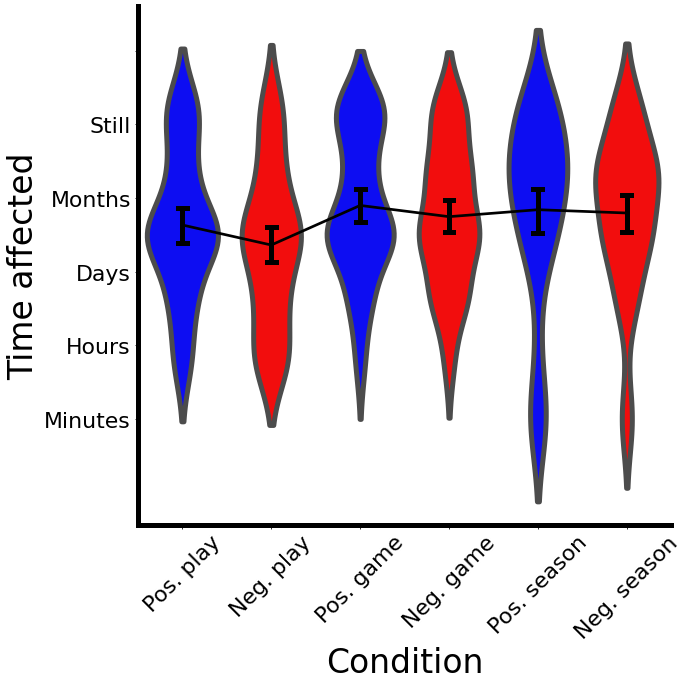

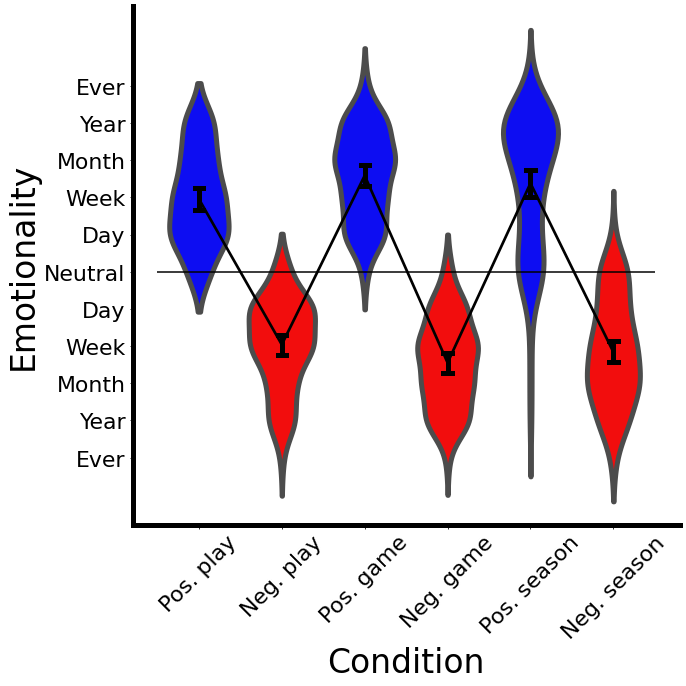

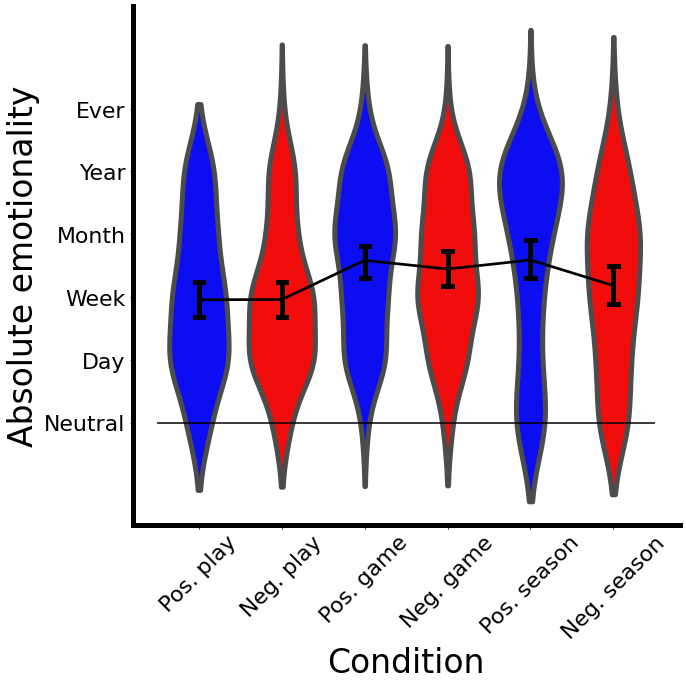

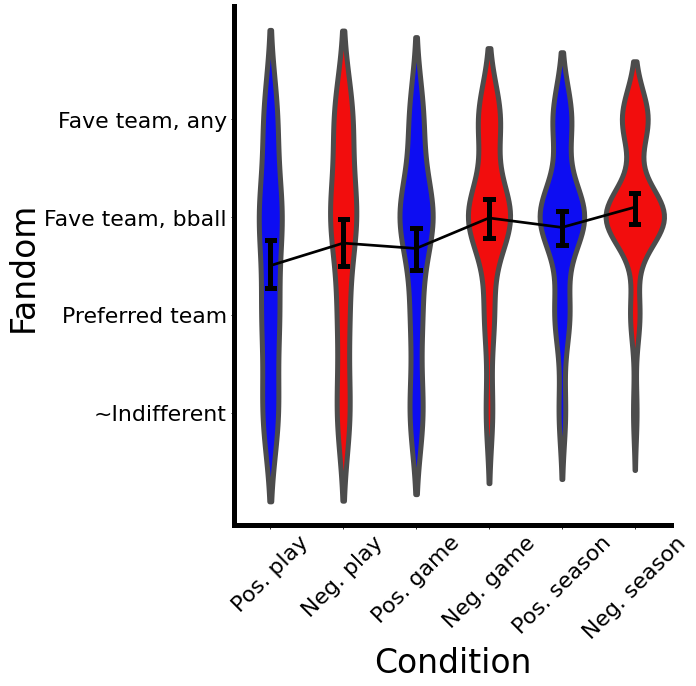

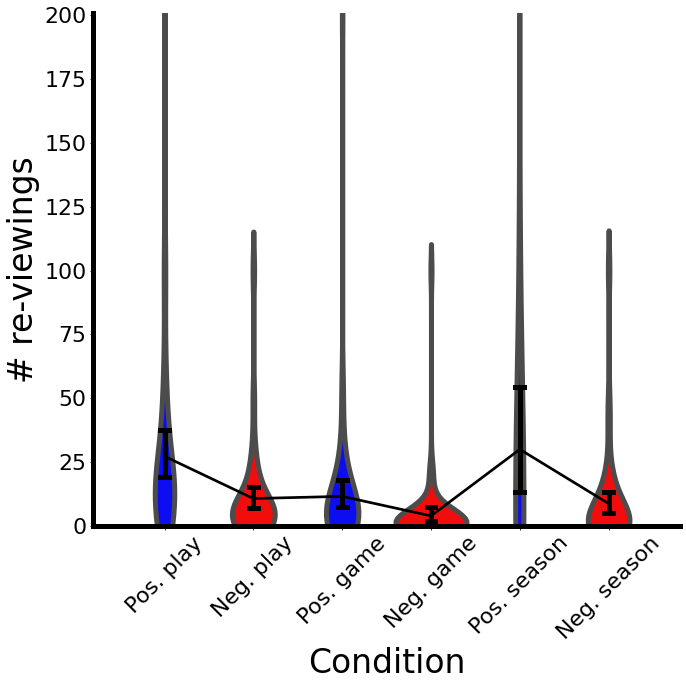

In [ ]:
# plot a range of other subject memory attributes
def barswarm_a(dp,dn,dgp,dgn,dsp,dsn,lab,yl,fn,exv):
    dat1=pd.DataFrame({'Condition':['Pos. play']*len(dp),lab:dp})
    dat2=pd.DataFrame({'Condition':['Neg. play']*len(dn),lab:dn})
    dat3=pd.DataFrame({'Condition':['Pos. game']*len(dgp),lab:dgp})
    dat4=pd.DataFrame({'Condition':['Neg. game']*len(dgn),lab:dgn})
    dat5=pd.DataFrame({'Condition':['Pos. season']*len(dsp),lab:dsp})
    dat6=pd.DataFrame({'Condition':['Neg. season']*len(dsn),lab:dsn})
    dat=dat1.append(dat2)
    dat=dat.append(dat3)
    dat=dat.append(dat4)
    dat=dat.append(dat5)
    dat=dat.append(dat6)
    f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
    colors=["blue","red","blue","red","blue","red"] #"#FF0B04", "#4374B3"
    cp = sns.set_palette(sns.color_palette(colors))
    if exv==4:
        #ax=sns.barplot(x=dat['Condition'],y=np.absolute(dat[lab]),facecolor=(1, 1, 1, 0),errcolor=".2",
        #          edgecolor=".2",palette=cp,saturation=1,linewidth=lw,capsize=.3)
        ax=sns.pointplot(x=dat['Condition'],y=dat[lab],color='k',saturation=1,
                     errwidth=lw,capsize=.1)
    else:
        #ax=sns.barplot(x=dat['Condition'],y=dat[lab],facecolor=(1, 1, 1, 0),errcolor=".2",
        #          edgecolor=".2",palette=cp,saturation=1,linewidth=lw,capsize=.3)
        ax=sns.pointplot(x=dat['Condition'],y=dat[lab],color='k',saturation=1,
                     errwidth=lw,capsize=.1)
    #ax=sns.swarmplot(x=dat['Condition'],y=dat[lab],facecolor=None,palette=cp,size=msz//3)
    ax=sns.violinplot(x=dat['Condition'],y=dat[lab],palette=cp,saturation=0.9,
                      linewidth=lw,inner=None)
    ax.tick_params(axis='x', rotation=45)
    if exv!=2:
        if exv!=0:
            ax.hlines(0,-0.5,5.5,color="black")
    ax.set_ylabel(yl,fontsize=fs)
    if exv==0:
        ax.set_yticks(np.linspace(0,6,6))
        ax.set_yticklabels(['Minutes','Hours','Days','Months','Still'])
    elif exv==1:
        ax.set_yticks(np.linspace(-5,5,11))
        ax.set_yticklabels(['Ever','Year','Month','Week','Day','Neutral','Day','Week','Month','Year','Ever']) 
    elif exv==2:
        ax.set_yticks(np.linspace(1,4,4))
        ax.set_yticklabels(['~Indifferent','Preferred team','Fave team, bball','Fave team, any']) 
    elif exv==3:
        ax.set_ylim([0,201])
    elif exv==4:
        ax.set_yticks(np.linspace(0,5,6))
        ax.set_yticklabels(['Neutral','Day','Week','Month','Year','Ever']) 
    ax.set_xlabel('Condition',fontsize=fs)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(lw)
    f.tight_layout()
    f.savefig(fn, transparent=True)

#time affected by play, game, season
def consol(ystr2,ybr2,exv2):
    #play
    qp=np.where(dfp[ystr2].isna()==0)[0]
    qn=np.where(dfn[ystr2].isna()==0)[0]
    y1,y2=dfp[ystr2].values,dfn[ystr2].values
    if exv2==4:
        y1,y2=np.absolute(dfp[ystr2].values),np.absolute(dfn[ystr2].values)
    astats3(y1[qp],y2[qn],'%s, plays' %ybr2)
    #game
    qgp=np.where(dfgp[ystr2].isna()==0)[0]
    qgn=np.where(dfgn[ystr2].isna()==0)[0]
    y1g,y2g=dfgp[ystr2].values.astype(int),dfgn[ystr2].values.astype(int)
    if exv2==4:
        y1g,y2g=np.absolute(dfgp[ystr2].values.astype(int)),np.absolute(dfgn[ystr2].values.astype(int))
    astats3(y1g[qgp],y2g[qgn],'%s, games' %ybr2)
    #season
    qsp=np.where(dfsp[ystr2].isna()==0)[0]
    qsn=np.where(dfsn[ystr2].isna()==0)[0]
    y1sz,y2sz=dfsp[ystr2].values,dfsn[ystr2].values
    y1s,y2s=y1sz[qsp].astype(int),y2sz[qsn].astype(int)
    if exv2==4:
        y1s,y2s=np.absolute(y1s),np.absolute(y2s)
    astats3(y1s,y2s,'%s, seasons' %ybr2)
    fn='figs/all_'+str(ybr2)+'.pdf'
    barswarm_a(y1[qp],y2[qn],y1g[qgp],y2g[qgn],y1s,y2s,ybr2,ybr2,fn,exv2)

ystr2,ybr2='How long affected? (1=minutes,2=hours,3=days,4=months,5=still affected)','Time affected'
consol(ystr2,ybr2,0)
ystr2='Overall emotionality w/r/t life (-5 to 5) (Day, Week, Month, Year, Ever)'
ybr2='Emotionality'
consol(ystr2,ybr2,1)
ybr2='Absolute emotionality'
consol(ystr2,ybr2,4)
ystr2,ybr2='How big a fan?','Fandom'
consol(ystr2,ybr2,2)
ystr2,ybr2='# re-viewings?','# re-viewings'
consol(ystr2,ybr2,3)

In [ ]:
# download files from colab onto computer - later, rearrange in illustrator
#https://predictivehacks.com/?all-tips=how-to-download-files-and-folders-from-colab
!zip -r /content/figs.zip /content/figs
from google.colab import files
files.download('/content/figs.zip')

updating: content/figs/ (stored 0%)
updating: content/figs/play_recalltimes.pdf (deflated 27%)
updating: content/figs/recalltimes_play.pdf (deflated 28%)
updating: content/figs/season_adj_histo_wgsurp-1.pdf (deflated 33%)
updating: content/figs/season_adj_histo_wgsurn-3.pdf (deflated 33%)
updating: content/figs/play_relsur_a_Spectacularity.pdf (deflated 36%)
updating: content/figs/all_Time affected.pdf (deflated 16%)
updating: content/figs/all_# re-viewings.pdf (deflated 17%)
updating: content/figs/season_actualVexpectedXvalence_runnerups-3-2.pdf (deflated 26%)
updating: content/figs/play_algoVexpert.pdf (deflated 33%)
updating: content/figs/game_adj_histo_fullgamesurprise_neg.pdf (deflated 33%)
updating: content/figs/game_fullgamesurprise_abs_chosengames.pdf (deflated 26%)
updating: content/figs/season_adj_histo_wgsurn-1.pdf (deflated 33%)
updating: content/figs/season_odds_records-1-2.pdf (deflated 30%)
updating: content/figs/game_fullgamesurprise_abs_chosenngames.pdf (deflated 28%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>